# Statistics - Inference

In [1]:
import warnings, platform
from IPython.display import display, HTML

In [2]:
### HTML display 조정
display(HTML("<style>.container {width :98% !important;}</style>"))

### Warning 제거
warnings.filterwarnings('ignore')

## Package Load

In [3]:
import random
import itertools
import numpy as np
import pandas as pd

import pingouin as pg
import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.datasets import load_diabetes

## Inference Basics

### (1) Sampling

#### Bootstrap
- 모집단으로부터 얻은 복원추출 표본

In [5]:
loans_income = pd.read_csv("./Practical_Statictics/data/loans_income.csv").squeeze('columns')

In [6]:
from sklearn.utils import resample

In [7]:
results = []
for nrepeat in range(1000):
    sample = resample(loans_income)
    results.append(sample.median())
results = pd.Series(results)
print('Bootstrap Statistics:')
print(f'original: {loans_income.median()}')
print(f'bias: {results.mean() - loans_income.median()}')
print(f'std. error: {results.std()}')

Bootstrap Statistics:
original: 62000.0
bias: -82.9539999999979
std. error: 223.33125897472502


#### Random sampling

In [8]:
fish_5 = np.array([2, 3, 4, 5, 6])
fish_5

array([2, 3, 4, 5, 6])

In [9]:
### Sampling
print(np.random.choice(fish_5, size=1, replace=False))
print(np.random.choice(fish_5, size=3, replace=False))

[3]
[5 6 3]


In [10]:
### Random.seed
# sample 고정
np.random.seed(1)
print(np.random.choice(fish_5, size=3, replace=False))
print(np.random.choice(fish_5, size=3, replace=False))

[4 3 6]
[2 4 6]


In [11]:
### Sample mean
np.mean(np.random.choice(fish_5, size=3, replace=False))

4.0

In [12]:
df = pd.DataFrame({'team': ['A', 'A', 'A', 'A', 'B', 'B', 'B', 'B'],
                   'position': ['G', 'G', 'F', 'G', 'F', 'F', 'C', 'C'],
                   'assists': [5, 7, 7, 8, 5, 7, 6, 9],
                   'rebounds': [11, 8, 10, 6, 6, 9, 6, 10]})
df.head()

,team,position,assists,rebounds
0,A,G,5,11
1,A,G,7,8
2,A,F,7,10
3,A,G,8,6
4,B,F,5,6


In [13]:
### DataFrame sampling
df.sample(3)

,team,position,assists,rebounds
6,B,C,6,6
3,A,G,8,6
0,A,G,5,11


In [14]:
df.sample(frac=0.2) # 비율 지정

,team,position,assists,rebounds
1,A,G,7,8
7,B,C,9,10


In [15]:
df.sample(2, axis=1) # column sampling

,rebounds,team
0,11,A
1,8,A
2,10,A
3,6,A
4,6,B
5,9,B
6,6,B
7,10,B


#### Systemetic sampling
- 첫 번째 요소는 무작위로 선정한 후 목록의 매번 k번째 요소를 표본으로 선정하는 표집방법
- 모집단의 크기를 원하는 표본의 크기로 나누어 표집간격 k 계산

In [16]:
n = 3 # sample 수
N = len(df) # 모집단 데이터 수
K = N//n # 구간 내 샘플 수

idx = df[:K].sample(1).index # first sample
sys_df = pd.DataFrame()
while len(sys_df) < n:
    sys_df = sys_df.append(df.loc[idx, :])
    idx += K
sys_df

,team,position,assists,rebounds
1,A,G,7,8
3,A,G,8,6
5,B,F,7,9


#### Stratified sampling
- 모집단을 중복되지 않는 층으로 나눈 다음 각 층에서 표본 추출
    - 비례층화추출: 원본 데이터 비율대로 추출
    - 불비례층화추출: 임의로 정한 특정 비율대로 추출

##### Proportional

In [17]:
df.groupby('team', group_keys=False).apply(lambda x: x.sample(2))

,team,position,assists,rebounds
0,A,G,5,11
2,A,F,7,10
5,B,F,7,9
4,B,F,5,6


In [18]:
# define total sample size desired
N = 4

# perform stratified random sampling
df.groupby('team', group_keys=False).apply(lambda x: x.sample(int(np.rint(N*len(x)/len(df))))).sample(frac=1).reset_index(drop=True)

,team,position,assists,rebounds
0,B,C,6,6
1,A,G,5,11
2,B,F,5,6
3,A,G,8,6


In [19]:
stratum = 'team' # 층 기준 컬럼
n = 4 # sampling 개수
prop_val = df[stratum].value_counts()/df[stratum].value_counts().sum() * n

result = pd.DataFrame()
for level in df[stratum].unique():
    tmp_df = df[df[stratum]==level].sample(int(prop_val[level]))
    result = pd.concat([result, tmp_df])
result

,team,position,assists,rebounds
2,A,F,7,10
3,A,G,8,6
7,B,C,9,10
6,B,C,6,6


##### Non-Proportional

In [20]:
stratum = 'team' # 층 기준 컬럼
n = 5 # sampling 개수
prop = {'A': 0.6, 'B': 0.4} # 층 비율

result = pd.DataFrame()
for level in list(prop.keys()):
    tmp_df = df[df[stratum]==level].sample(int(prop[level]*n))
    result = pd.concat([result, tmp_df])
result

,team,position,assists,rebounds
0,A,G,5,11
1,A,G,7,8
2,A,F,7,10
7,B,C,9,10
5,B,F,7,9


#### Cluster sampling
- 집단을 일차적으로 표집한 다음, 선정된 각 집단에서 구성원을 표본으로 추출하는 다단계 표집방법

In [21]:
#create DataFrame
df = pd.DataFrame({'tour': np.repeat(np.arange(1,11), 20),
                   'experience': np.random.normal(loc=7, scale=1, size=200)})

# view first six rows of DataFrame
df.head()

,tour,experience
0,1,7.533811
1,1,6.908027
2,1,8.913820
3,1,7.330797
4,1,8.141943


In [22]:
# randomly choose 4 tour groups out of the 10
clusters = np.random.choice(np.arange(1,11), size=4, replace=False)

# define sample as all members who belong to one of the 4 tour groups
cluster_sample = df[df['tour'].isin(clusters)]

# view first six rows of sample
cluster_sample.head()

,tour,experience
20,2,7.275718
21,2,5.909325
22,2,6.390015
23,2,7.306412
24,2,8.691826


In [23]:
cluster_sample['tour'].value_counts()

10    20
6     20
3     20
2     20
Name: tour, dtype: int64

### (2) Sampling distribution

In [24]:
# 분포에서 샘플링
sampling_norm = stats.norm.rvs(loc=4, scale=0.8, size=10)
sampling_norm

array([4.07260686, 4.92976198, 4.25742598, 5.07305427, 4.11334015,
       5.38990774, 4.30061502, 5.18260454, 2.33586625, 3.63725795])

In [25]:
np.mean(sampling_norm)

4.329244072082277

In [26]:
# 평균 4, 표준편차 0.8인 정규분포
population = stats.norm(loc=4, scale=0.8)

In [27]:
# 표본평균 여러 번 계산하기
sample_mean_array = np.zeros(10000)
np.random.seed(1)
for i in range(0, 10000):
    sample = population.rvs(size=10)
    sample_mean_array[i] = np.mean(sample)

sample_mean_array

array([3.92228729, 3.86432929, 4.06953003, ..., 4.13616562, 4.57489661,
       4.09896685])

In [28]:
# Sample의 평균과 표준편차
print(np.mean(sample_mean_array), np.std(sample_mean_array, ddof=1))

4.004202422791747 0.2513580850860402


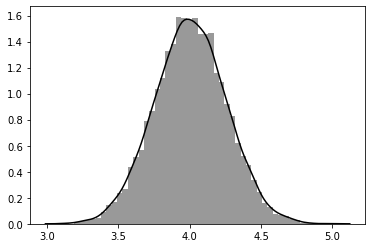

In [29]:
sns.distplot(sample_mean_array, color='black', kde=True)
plt.show()

In [30]:
### Sample size에 따른 평균과 표준편차의 변화
size_array = np.arange(start=10, stop=100100, step=100)
sample_mean_array_size = np.zeros(len(size_array))

np.random.seed(1)
for i in range(0, len(size_array)):
    sample = population.rvs(size = size_array[i])
    sample_mean_array_size[i] = np.mean(sample)

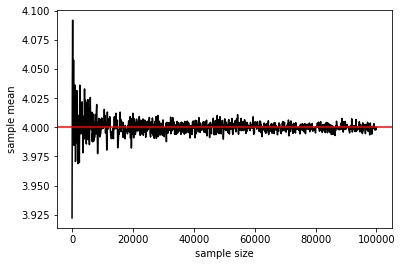

In [31]:
sns.lineplot(x=size_array, y=sample_mean_array_size, color='black')
plt.axhline(4, color='red')
plt.xlabel("sample size")
plt.ylabel("sample mean")
plt.show()

In [32]:
# 표본평균 계산 함수
def calc_sample_mean(size, n_trial):
    sample_mean_array = np.zeros(n_trial)
    for i in range(0, n_trial):
        sample = population.rvs(size=size)
        sample_mean_array[i] = np.mean(sample)
    return(sample_mean_array)

In [33]:
# 10000개 표본평균의 평균
np.random.seed(1)
np.mean(calc_sample_mean(size=10, n_trial=10000))

4.004202422791747

In [34]:
# Sample size와 표본평균
np.random.seed(1)

size_10 = calc_sample_mean(size=10, n_trial=10000)
size_10_df = pd.DataFrame({
    "sample_mean":size_10,
    "size"       :np.tile("size 10", 10000)
})

size_20 = calc_sample_mean(size=20, n_trial=10000)
size_20_df = pd.DataFrame({
    "sample_mean":size_20,
    "size"       :np.tile("size 20", 10000)
})

size_30 = calc_sample_mean(size=30, n_trial=10000)
size_30_df = pd.DataFrame({
    "sample_mean":size_30,
    "size"       :np.tile("size 30", 10000)
})


sim_result = pd.concat([size_10_df, size_20_df, size_30_df])

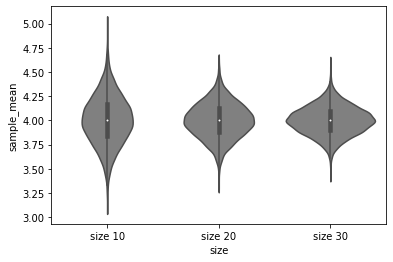

In [35]:
sns.violinplot(x="size", y="sample_mean", data=sim_result, color='gray')
plt.show()

In [36]:
# 표본평균의 표준편차
size_array = np.arange(start=2, stop=102, step=2)
sample_mean_std_array = np.zeros(len(size_array))

np.random.seed(1)
for i in range(0, len(size_array)):
    sample_mean = calc_sample_mean(size=size_array[i], n_trial=100)
    sample_mean_std_array[i] = np.std(sample_mean, ddof=1)

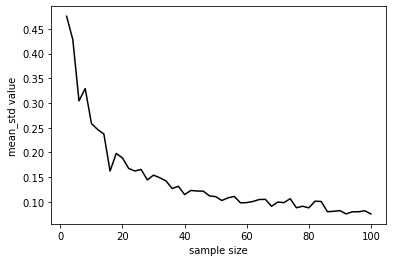

In [37]:
sns.lineplot(x=size_array, y=sample_mean_std_array, color='black')
plt.xlabel("sample size")
plt.ylabel("mean_std value")
plt.show()

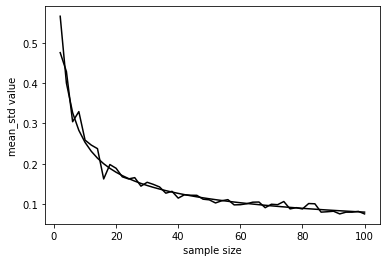

In [38]:
# Standard error
standard_error = 0.8 / np.sqrt(size_array)
sns.lineplot(x=size_array, y=sample_mean_std_array, color='black')
sns.lineplot(x=size_array, y=standard_error, color='black', linestyle='dotted')
plt.xlabel("sample size")
plt.ylabel("mean_std value")
plt.show()

In [39]:
# 표본분산의 평균 (Unbiased variance)
sample_var_array = np.zeros(10000)
np.random.seed(1)
for i in range(0, 10000):
    sample = population.rvs(size=10)
    sample_var_array[i] = np.var(sample, ddof=1)
    
np.mean(sample_var_array)

0.6385429863702334

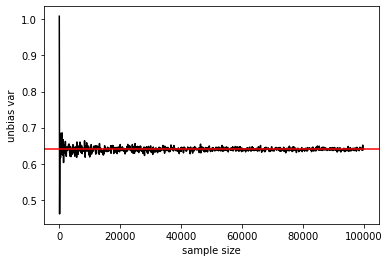

In [40]:
# 표본분산과 모분산의 관계
size_array =  np.arange(start=10, stop=100100, step=100)
unbias_var_array_size = np.zeros(len(size_array))
np.random.seed(1)
for i in range(0, len(size_array)):
    sample = population.rvs(size=size_array[i])
    unbias_var_array_size[i] = np.var(sample, ddof=1)
    
sns.lineplot(x=size_array, y=unbias_var_array_size, color='black')
plt.axhline(0.8**2, color='red')
plt.xlabel("sample size")
plt.ylabel("unbias var")
plt.show()

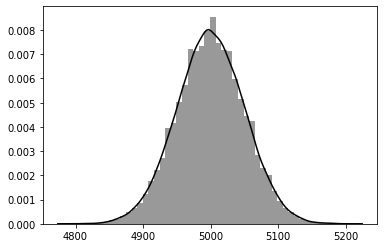

In [41]:
### Central Limit Theorem
# n이 충분히 크면, 표본평균의 분포는 정규분포를 따르게 된다
n_size = 10000
n_trial = 50000

coin = np.array([0, 1])
count_coin = np.zeros(n_trial)
np.random.seed(1)
for i in range(0, n_trial):
    count_coin[i] = np.sum(np.random.choice(coin, size=n_size, replace=True))

sns.distplot(count_coin, color='black', kde=True)
plt.show()

In [42]:
sample_data = pd.DataFrame({
    'income': loans_income.sample(1000),
    'type': 'Data',
})

sample_mean_05 = pd.DataFrame({
    'income': [loans_income.sample(5).mean() for _ in range(1000)],
    'type': 'Mean of 5',
})

sample_mean_20 = pd.DataFrame({
    'income': [loans_income.sample(20).mean() for _ in range(1000)],
    'type': 'Mean of 20',
})

results = pd.concat([sample_data, sample_mean_05, sample_mean_20])
results.head()

,income,type
43759,26000.0,Data
46518,63000.0,Data
4776,20800.0,Data
28700,70000.0,Data
16657,85000.0,Data


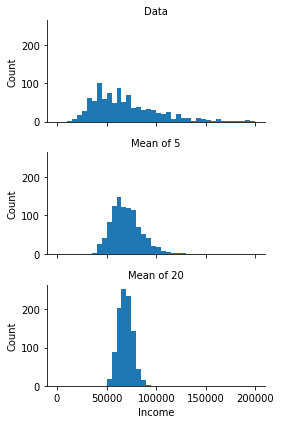

In [43]:
g = sns.FacetGrid(results, col='type', col_wrap=1, height=2, aspect=2)
g.map(plt.hist, 'income', range=[0, 200000], bins=40)
g.set_axis_labels('Income', 'Count')
g.set_titles('{col_name}')

plt.tight_layout()
plt.show()

## Estimation
- Point estimation
- Interval estimation

In [44]:
fish = pd.read_csv("./stats_for_python/3-7-1-fish_length.csv")["length"]

### (1) Point estimation
- 표본을 통해 얻은 값으로 모집단 값을 추정

In [45]:
# mean
mu = np.mean(fish)
mu

4.187039324504525

In [46]:
# variance
sigma_2 = np.var(fish, ddof=1)
sigma_2

0.6803017080832623

### (2) Interval estimation

#### Mean - One Sample

In [47]:
### 정규분포로 구간추정: 모표준편차가 알려진 경우
# 표본 개수가 작은 경우 모집단은 정규분포 가정 필요
data = np.random.randint(10, 30, 50)

# create 95% confidence interval for population mean
# sem: standard error of the mean
stats.norm.interval(alpha=0.95, loc=np.mean(data), scale=stats.sem(data))

(17.621531444065983, 20.338468555934018)

In [48]:
### T분포로 구간추정: 모표준편차를 모르는 경우
df = len(fish) - 1 # Degree of Freedom: n - 1
sigma = np.std(fish, ddof=1)
se = sigma / np.sqrt(len(fish))

# 신뢰계수(alpha), df, 표본평균, 표준오차
stats.t.interval(alpha=0.95, df=df, loc=mu, scale=se)

(3.5970100568358268, 4.777068592173223)

In [49]:
### 표본 개수가 적고, 모집단이 정규분포가 아닌 경우
### Non-parametric: Wilcoxon Signed Rank test's CI
walsh_arrange = list()
for i in range(len(fish)):
    for j in range(len(fish)):
        if i > j:
            continue
        walsh_arrange.append(np.mean([fish[i], fish[j]]))
walsh_arrange = pd.Series(sorted(walsh_arrange))

walsh_arrange.quantile([0.025]).values[0], walsh_arrange.quantile([0.975]).values[0]

(3.436159685730456, 5.486540311835267)

In [50]:
### 표본표준편차, 신뢰도, 샘플 개수에 따른 구간의 길이 비교
# 표본표준편차 * 10
se2 = (sigma*10) / np.sqrt(len(fish))
stats.t.interval(alpha=0.95, df=df, loc=mu, scale=se2)

(-1.713253352182459, 10.087332001191509)

In [51]:
# 샘플 개수
df2 = (len(fish)*10) - 1
se3 = sigma / np.sqrt(len(fish)*10)
stats.t.interval(alpha=0.95, df=df2, loc=mu, scale=se3)

(4.023380308277441, 4.350698340731609)

In [52]:
# 신뢰도
stats.t.interval(alpha=0.99, df=df, loc=mu, scale=se)

(3.339397914941399, 5.034680734067651)

In [53]:
### Interval estimation 해석
# 여러 번 추정 수행 시, 신뢰구간이 모평균을 포함하는 비율
be_included_array = np.zeros(20000, dtype = "bool")

np.random.seed(1)
norm_dist = stats.norm(loc=4, scale=0.8)
for i in range(0, 20000):
    sample = norm_dist.rvs(size=10)
    df = len(sample) - 1
    mu = np.mean(sample)
    std = np.std(sample, ddof=1)
    se = std / np.sqrt(len(sample))
    interval = stats.t.interval(0.05, df, mu, se)
    if(interval[0] <= 4 and interval[1] >= 4):
        be_included_array[i] = True
        
sum(be_included_array) / len(be_included_array)

0.0501

In [54]:
### Bootstraping for CI
def bootstrap(data, n=1000, func=np.mean, p=0.95):
    sample_size = len(data)
    simulations = [func(np.random.choice(data, size=sample_size, replace=True)) for i in range(n)]
    simulations.sort()
    u_pval = (1+p)/2.
    l_pval = (1-u_pval)
    l_indx = int(np.floor(n*l_pval))
    u_indx = int(np.floor(n*u_pval))
    return (simulations[l_indx], simulations[u_indx])

x = np.array([0.02288081, 0.44170839, 0.10549733, 0.17515196, 0.09449279, 0.07110412, 0.00893079, 0.23485109, 0.14533192, 0.05449631])

# for median, 95% confidence interval, do 
bootstrap(x, 1000, np.median, 0.95)

(0.040017455, 0.190091505)

#### Mean - Two Sample

In [55]:
### 독립적인 두 개 집단의 차이 구간추정
# 표본이 큰 경우
data_1 = np.random.randint(10, 30, 50)
data_2 = np.random.randint(15, 30, 50)

stats.norm.interval(alpha=0.95, loc=np.mean(data_1 - data_2), scale=np.var(data_1)/len(data_1) + np.var(data_2)/len(data_2))

(-6.541986667372099, -2.6180133326279007)

In [56]:
### 표본 개수가 작은 경우
# 정규분포 가정이 필수. 정규분포 가정이 없으면 비모수적 방법 사용
data_1 = np.random.normal(10, 5, 15)
data_2 = np.random.normal(15, 5, 10)

n_1 = len(data_1)
n_2 = len(data_2)
s_pooled = ((n_1 - 1)*np.var(data_1) + (n_2 - 1)*np.var(data_2)) / (n_1 + n_2 - 2)
mean_diff = np.mean(data_1) - np.mean(data_2)
stats.t.interval(alpha=0.95, df=n_1 + n_2 - 2, loc=mean_diff, scale=np.sqrt(s_pooled)*np.sqrt((1/n_1) + (1/n_2))) # 분산이 같은 경우
### mean_diff - stats.t.ppf(0.975, df=n_1 + n_2 -2)* np.sqrt(s_pooled)* np.sqrt((1/n_1) + (1/n_2)),
### mean_diff + stats.t.ppf(0.975, df=n_1 + n_2 -2)* np.sqrt(s_pooled)* np.sqrt((1/n_1) + (1/n_2))

(-8.793053457082337, -0.18530532185756687)

In [57]:
### Non-parametric: Mann-whitney test's CI
ct1 = len(data_1)  # items in dataset 1
ct2 = len(data_2)  # items in dataset 2
alpha = 0.05       #95% confidence interval
N = stats.norm.ppf(1 - alpha/2) # percent point function - inverse of cdf

# The confidence interval for the difference between the two population
# medians is derived through these nxm differences.
diffs = sorted([i-j for i in data_1 for j in data_2])

# For an approximate 100(1-a)% confidence interval first calculate K:
k = int(round(ct1*ct2/2 - (N * (ct1*ct2*(ct1+ct2+1)/12)**0.5)))

# The Kth smallest to the Kth largest of the n x m differences 
# ct1 and ct2 should be > ~20
ci = (diffs[k], diffs[len(diffs)-k])
ci

(-8.983909725228083, -0.24407534755221327)

In [58]:
# df = min([n_1, n_2]) 를 사용하기도 함
df = ((np.var(data_1)/n_1) + (np.var(data_2)/n_2))**2 / (((np.var(data_1)/n_1)**2/(n_1 - 1)) + ((np.var(data_2)/n_2)**2/(n_1 - 1))) 
stats.t.interval(alpha=0.95, df=df, loc=mean_diff, scale=np.sqrt((np.var(data_1)/n_1) + (np.var(data_2)/n_2))) # 분산이 다른 경우에는 신뢰구간이 조금 더 넓어짐

(-8.656034979194843, -0.3223237997450594)

#### Propotion - One Sample

In [59]:
### 표본비율 구간추정
# p-hat = x-bar/n
# 표준오차: sqrt(p(1-p)/n) -> p를 p-hat으로 대체하여 사용
# X ~ B(n, p)이므로, Z = (X - np)/sqrt(np(1-p)) ~ N(0, 1)

p_hat = 41/500
se = np.sqrt((p_hat*(1 - p_hat))/500)
stats.norm.interval(alpha=0.95, loc=p_hat, scale=se)

(0.05795131379112069, 0.10604868620887932)

In [60]:
from statsmodels.stats.proportion import proportion_confint

In [61]:
proportion_confint(41, 500, alpha=0.05, method='normal') # 동일한 결과

(0.05795131379112069, 0.10604868620887932)

#### Propotion - Two Sample

In [62]:
### 두 개 집단의 비율 차이 구간추정
# Z = (p-hat_1 - p-hat_2)/sqrt(((p_1*(1-p_1))/n_1) + ((p_2*(1-p_2))/n_2)) ~ N(0, 1)
p_1 = 0.6
p_2 = 0.5
n_1 = 10
n_2 = 12

se = np.sqrt(((p_1*(1 - p_1))/n_1) + ((p_2*(1 - p_2))/n_2))
stats.norm.interval(alpha=0.95, loc=np.mean(p_1 - p_2), scale=se)

(-0.3150004864990562, 0.5150004864990562)

#### Variance & Standard Deviation

In [63]:
### 분산과 표준편차 구간추정
# 모집단의 정규분포 가정 필수
# (n-1)(s**2)/sigma**2 ~ chisq(n-1)
# (n-1)(s**2)/chisq(alpha/2)(n-1) < sigma**2 < (n-1)(s**2)/chisq(1-alpha/2)(n-1)
alpha=0.05
n = len(fish)
var = np.var(fish)
interval = ((n - 1) * var)/stats.chi2.ppf(1-(alpha/2), df=n-1), ((n - 1) * var)/stats.chi2.ppf(alpha/2, df=n-1)
interval

(0.28967623922045205, 2.040610747269794)

In [64]:
### 두 개 집단의 분산비 구간추정
# 모집단의 정규분포 가정 필수
alpha=0.05
m = len(data_1)
n = len(data_2)
var1 = np.var(data_1, ddof=1)
var2 = np.var(data_2, ddof=1)

interval = stats.f.ppf(alpha/2, n-1, m-1) * (var1/var2), stats.f.ppf(1-(alpha/2), n-1, m-1) * (var1/var2)
interval

(0.3165371024048256, 3.858197999789888)

#### Correlation

In [65]:
import math

In [66]:
### 상관계수 구간추정
def r_to_z(r):
    return math.log((1 + r) / (1 - r)) / 2.0

def z_to_r(z):
    e = math.exp(2 * z)
    return((e - 1) / (e + 1))

def r_confidence_interval(r, alpha, n):
    z = r_to_z(r)
    se = 1.0 / math.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha/2)  # 2-tailed z critical value

    lo = z - z_crit * se
    hi = z + z_crit * se

    # Return a sequence
    return (z_to_r(lo), z_to_r(hi))

r = pd.DataFrame([data_1, data_2]).T.corr()[0][1]
print(r)
print(r_confidence_interval(r, 0.05, n_1))

0.5144828359271364
(-0.1703134176136683, 0.8641752004452788)


### (3) Estimate sample size
- 오차한계: d
- 모평균 추정의 sample size
    - Z 검정 (모분산을 알고 있거나, 표본이 충분히 큰 경우): n >= (Z(2/a)*sigma/d)**2
- 모비율 추정의 sample size
    - n >= ((Z(2/a)/d)**2)*p*(1-p)
    - p를 알고 있거나, 추정이 가능하다면 해당 값을 쓰고, 추정이 불가능하다면 가장 보수적으로 표본 개수를 잡을 수 있는 p=0.5 사용

In [67]:
### 모평균 추정 시 표본 크기
d = 0.75
sigma = 4
alpha = 0.1

math.ceil((stats.norm.ppf(1-(alpha/2))*sigma/d)**2)

77

In [68]:
### 모비율 추정 시 표본 크기
d = 0.05
alpha = 0.02
p = 0.5 # 최대 표본 p

math.ceil(p*(1-p)*(stats.norm.ppf(1-(alpha/2))/d)**2)

542

## Testing
- 귀무가설과 대립(연구)가설
- Critical Value, P-value
- 유의수준 (alpha)
- 단측검정/양측검정
    - alternative: less, greater(larger) / two-sided
- 제 1종 오류와 제 2종 오류: 1종 오류를 주로 컨트롤
- Power = 1 - beta = 1 - 제 2종 오류
    - 귀무 가설을 기각해야 하는 상황일 때, 실제로 귀무 가설을 기각하는 비율
    - 같은 alpha 수준에서, 검정의 정확성 정도
- 신뢰구간과 양측검정
    - 신뢰구간 안에 검정할 모수가 들어가면 귀무가설 기각하지 않음

- Parametric
    - 모수 분포의 모양을 가정(주로 정규분포)하고, 모수 분포의 확률값을 이용하는 검정
- Non-parametric
    - 모수의 형태를 가정하지 않는 통계로, 약간의 검정력 손해가 있음
    - 사용 범위
        - 범주형 데이터
        - 극단값이 존재하는 경우
        - 모수 검정의 가정을 만족하지 못하는 경우

## Pre-test Analysis
- 통계분석 전 사전 수행해야 하는 test
- 정규성 확인, 등분산성 확인 등
- 모수 검정/비모수 검정을 나누는 기준이 됨

### (1) Normality

귀무가설(H0) <br>
데이터의 분포는 정규분포를 따른다.<br>
대립가설(H1)<br>
데이터의 분포는 정규분포를 따르지 않는다.<br>

In [69]:
cats = pd.read_csv('./ADP_book_ver01/data/cats.csv')

In [70]:
cats.head()

,Sex,Bwt,Hwt
0,F,2.0,7.0
1,F,2.0,7.4
2,F,2.0,9.5
3,F,2.1,7.2
4,F,2.1,7.3


#### Shapiro-wilk Test
- 2000개 이하의 데이터에서 주로 사용
- n이 매우 작은 경우 정규성으로 판단하는 경향이 강하므로 주의 필요

In [71]:
stats.shapiro(cats['Bwt'])

ShapiroResult(statistic=0.9518789649009705, pvalue=6.730626046191901e-05)

#### Kolmogorov-smirnov (K-S) Test
- 2000개 이상의 데이터에서 주로 사용
- 두 집단의 분포 (누적확률) 비교. 데이터와 Normal distribution 제시

In [72]:
stats.kstest(cats['Bwt'], stats.norm.cdf)

KstestResult(statistic=0.9772498680518208, pvalue=5.089961007561737e-237)

#### Anderson-darling Test
- K-S test의 개선: 분포의 꼬리 부분에 가중치 부여
- 데이터 개수가 많은 경우 (5000개 이상?)

In [73]:
stats.anderson(cats['Bwt'], dist='norm')

AndersonResult(statistic=1.9228438994888393, critical_values=array([0.561, 0.639, 0.767, 0.894, 1.064]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

#### Jarque-Bera Test
- 분포의 왜도와 첨도가 정규분포의 특성을 보이는지 확인
- 왜도를 사용하므로 이상치에 민감함
- 시계열 데이터의 정규성 검정에 주로 사용

In [74]:
stats.jarque_bera(cats['Bwt'])

Jarque_beraResult(statistic=8.25725765348072, pvalue=0.01610494636172033)

[결과해석] <br>
유의수준보다 작으므로 '데이터가 정규분포를 따른다'는 귀무가설을 기각한다. 즉, cats 데이이터의 Bwt 변수는 정규분포를 따르지 않는다.

#### Empirical Methods
- 분포를 시각화하거나, 정규분포의 특성(왜도, 첨도) 값으로 판단

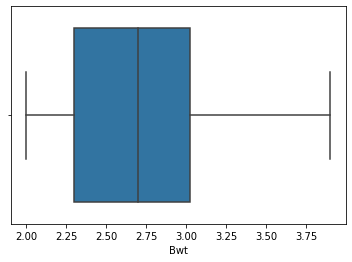

In [75]:
### Boxplot
sns.boxplot(x=cats.Bwt)
plt.show()

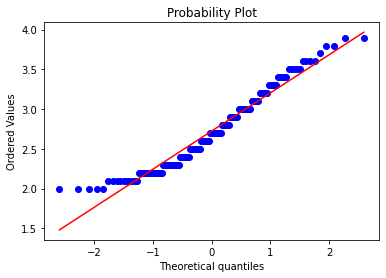

In [76]:
### Q-Q plot
stats.probplot(cats.Bwt, dist="norm", plot=plt)
plt.show()

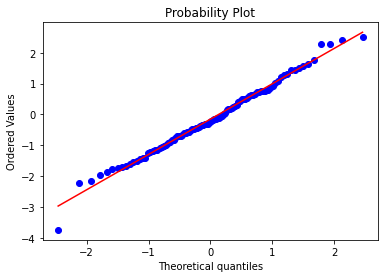

In [77]:
stats.probplot(stats.norm.rvs(size=100), plot=plt)
plt.show()

In [78]:
### Skewness, Kurtosis
# Normal의 왜도, 첨도는 0, 3
cats.Bwt.skew()

0.47862437175650524

In [79]:
cats.Bwt.kurtosis()

-0.6738392606733399

### (2) Equal variance

귀무가설(H0) <br>
집단 간 분산 차이가 없다.<br>
대립가설(H1)<br>
집단 간 분산 차이가 있다.<br>

In [80]:
female = cats.loc[cats.Sex=='F', 'Bwt']
male = cats.loc[cats.Sex=='M', 'Bwt']

#### Levene test
- 모집단이 정규분포가 아닌 경우에도 사용할 수 있음
- 집단 내 데이터 수가 달라도 가능
- median 척도가 default -> Brown-Forsythe test

In [81]:
stats.levene(female, male, center='mean')

LeveneResult(statistic=17.20136858946354, pvalue=5.759437452845422e-05)

In [82]:
stats.levene(female, male)

LeveneResult(statistic=19.43101190877999, pvalue=2.0435285255189404e-05)

#### Fligner test
- 모집단이 정규분포가 아닌 경우에도 사용할 수 있음. (Levene 보다 더 Robust test)

In [83]:
stats.fligner(female, male, center='mean')

FlignerResult(statistic=16.30243520453388, pvalue=5.399451767224576e-05)

In [84]:
stats.fligner(female, male)

FlignerResult(statistic=16.909233669160688, pvalue=3.9210381249178575e-05)

#### Bartlett test
- 정규성 필요. 모집단이 정규분포인 경우 정확도가 높음
- 집단 내 데이터 수가 달라도 가능

In [85]:
stats.bartlett(female, male)

BartlettResult(statistic=15.074702450407873, pvalue=0.00010333894088535889)

#### F-test
- 두 집단 분산의 비율 검정
- 정규성 필요
- Two sample test 파트 참조

## Sample tests
- 한 개, 또는 두 개 집단 비교

### (1) One sample test
- 연속형인 한 개 집단 검정
- T-test는 모집단의 정규분포 가정이 필요하며, 정규성이 깨지면 비모수적 방법 시행

#### Binomial probability test
- 확률 시행의 결과가 유의한지 확인

귀무가설(H0)<br>
사건의 확률은 p이다<br><br>
대립가설(H1)<br>
사건의 확률은 p가 아니다<br>

In [86]:
stats.binomtest(k=1, n=10, p=0.5, alternative='two-sided') # 성공횟수, 시행횟수, 성공확률

BinomTestResult(k=1, n=10, alternative='two-sided', proportion_estimate=0.1, pvalue=0.021484375)

#### Mean test
- Z-test: 데이터가 충분히 크거나 모분산을 알고 있는 경우
- T-test, Wilcoxon signed rank test (Sign test)

귀무가설(H0) <br>
집단의 중심 척도(평균, 중앙값)는 x이다<br><br>
대립가설(H1)<br>
집단의 중심 척도(평균, 중앙값)는 x가 아니다<br>

In [87]:
cats.head()

,Sex,Bwt,Hwt
0,F,2.0,7.0
1,F,2.0,7.4
2,F,2.0,9.5
3,F,2.1,7.2
4,F,2.1,7.3


Bwt 컬럼은 고양이의 몸무게를 의미하고, Hwt는 고양이의 길이를 의미한다. 
cats의 데이터의 정보를 info로 확인해준다. 

In [88]:
cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sex     144 non-null    object 
 1   Bwt     144 non-null    float64
 2   Hwt     144 non-null    float64
dtypes: float64(2), object(1)
memory usage: 3.5+ KB


shapiro test를 통해 데이터의 정규성을 검정한다. 고양이의 몸무게를 검정하므로 고양이의 몸무게만 추출하여 shapiro test를 진행해야 한다.

In [89]:
mu = 2.6
stats.shapiro(cats['Bwt'])

ShapiroResult(statistic=0.9518789649009705, pvalue=6.730626046191901e-05)

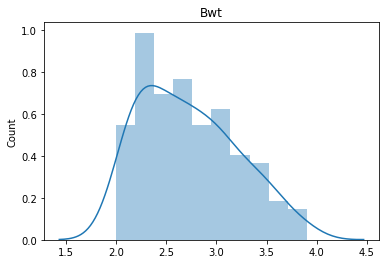

In [90]:
sns.distplot(cats.Bwt.values, bins=10)
plt.title('Bwt')
plt.ylabel('Count')
plt.show()

데이터가 정규분포를 따르지 않으므로 wilcox test를 진행한다. 

귀무가설(H0) <br>
고양이의 평균 몸무게는 2.6kg이다. -> 고양이의 몸무게 - 2.6kg의 평균은 0이다.<br><br>
대립가설(H1)<br>
고양이의 평균 몸무게는 2.6kg이 아니다 <br>

##### Wilcoxon signed rank test

In [91]:
# 평균을 빼주는 이유는, signed rank test가 원래 paired sample용임.
# sign test도 사용 가능
stats.wilcoxon(cats.Bwt - mu, alternative='two-sided')

WilcoxonResult(statistic=3573.0, pvalue=0.02524520294814093)

H0 기각. 유의수준 0.05 하에서 고양이의 평균 몸무게는 2.6kg이라고 할 수 없다.

##### Z-test

In [92]:
statsmodels.stats.weightstats.ztest(cats['Bwt'], x2=None, value=mu, alternative='two-sided')

(3.0564867998078107, 0.002239473410335702)

##### T-test

In [93]:
stats.ttest_1samp(cats.Bwt, popmean=mu)

Ttest_1sampResult(statistic=3.0564867998078107, pvalue=0.0026730362561723613)

#### Proportion test
- 정규분포를 이용한 집단의 비율 검정

H0: p = p0 (population proportion is equal to hypothesized proportion p0)

H1 (two-tailed): p ≠ p0 (two-tailed population proportion is not equal to some hypothesized value p0) <br>
H1 (left-tailed): p < p0 (left-tailed population proportion is less than some hypothesized value p0) <br>
H1 (right-tailed): p > p0 (right-tailed population proportion is greater than some hypothesized value p0)

In [94]:
# count: 성공 횟수, nobs: 전체 시행 횟수 -> 표본비율 = count/nobs
# value: 검정할 모비율
# returns z-stat, p-value
statsmodels.stats.proportion.proportions_ztest(count=70, nobs=100, value=0.86, alternative='smaller') # smaller, larger, two-side

(-3.4914862437758782, 0.0002401705999909348)

#### Variance test
- 정규성 가정이 필수 

In [95]:
def chi_var_test(x, va0, direction="two-tailed"):
    n = len(x)
    chi_stat = (n - 1) * np.var(x) / va0 
    tmp_p = stats.chi2.cdf(chi_stat, df=n-1)
    
    if direction == "lower":
        p = tmp_p
    elif direction == "upper":
        p = 1 - tmp_p 
    else:
        p = 2*(1-tmp_p) if tmp_p > 0.5 else 2*tmp_p
    
    return chi_stat, p

x = np.random.normal(0, 2, 25)
chi_var_test(x, va0=9)

(9.460306723067513, 0.007125400204493919)

In [96]:
### if not normal
# Squared Ranks test for Variances

### (2) Paired sample test
- 단일 모집단의 어떠한 처리 전후에 따른 중심 척도 차이 비교
- Paired T-test, Wilcoxon signed rank test

In [97]:
# 데이터 불러오기 및 확인
data = {'before':[7, 3, 4, 5, 2, 1, 6, 6, 5, 4], 'after':[8, 4, 5, 6, 2, 3, 6, 8, 6, 5]}
data = pd.DataFrame(data)
data

,before,after
0,7,8
1,3,4
2,4,5
3,5,6
4,2,2
5,1,3
6,6,6
7,6,8
8,5,6
9,4,5


귀무가설(H0) <br>
수면제 복용 전과 후의 수면시간 차이는 없다. (D=0)<br>
대립가설(H1)<br>
수면제 복용 전과 후의 수면시간 차이는 있다. <br>


In [98]:
### Normality test
stats.shapiro(data.before)

ShapiroResult(statistic=0.9644595384597778, pvalue=0.8352704644203186)

In [99]:
stats.shapiro(data.after)

ShapiroResult(statistic=0.9456835985183716, pvalue=0.6177982091903687)

두 집단 다 정규성을 만족하므로, Paired T-test를 진행한다.

##### Paired T-test

In [100]:
stats.ttest_rel(data['after'], data['before'], alternative='greater') # H1: D > 0

Ttest_relResult(statistic=4.743416490252569, pvalue=0.0005269356285082764)

In [101]:
data.mean()

before    4.3
after     5.3
dtype: float64

[결과해석]
p-value가 유의수준보다 작으므로 '수면영양제를 복용하기 전과 후의 평균 수면시간의 차이는 통계적으로 유의하며, 영양제를 복용한 후 수면시간이 늘었다'는 결론을 낼 수 있다. 

##### Wilcoxon Signed Rank test

In [102]:
# 두 데이터의 차이 배열을 input으로 함
# 비모수 검정의 p-value가 높음 -> 검정력이 떨어짐
stats.wilcoxon(data['after']-data['before'], alternative='greater')

WilcoxonResult(statistic=36.0, pvalue=0.00414960799764038)

##### Sign test

In [103]:
# Ordinal data
# 두 집단의 대소 비교하여, 이항검정 또는 정규근사 활용
# 중앙값과의 대소 비교로 단일 표본 검정도 수행 가능
# H0: p = 0.5
# n = 동률이 아닌 데이터 수
# z = x - np/sqrt(np(1-p)) ~ N(0, 1)

In [104]:
from statsmodels.stats import descriptivestats

In [105]:
stat, p = descriptivestats.sign_test(data['after']-data['before'], mu0=0)
print("single sample sign test p-value", p) # 양측 검정만 가능. H1: p != 0.5

single sample sign test p-value 0.0078125


In [106]:
plus = (data['after'] - data['before'] > 0).sum()
minus = (data['after'] - data['before'] < 0).sum()

stats.binomtest(k=plus, n=plus + minus, p=0.5, alternative='two-sided') # 위 결과와 동일

BinomTestResult(k=8, n=8, alternative='two-sided', proportion_estimate=1.0, pvalue=0.0078125)

In [107]:
stats.binomtest(k=plus, n=plus + minus, p=0.5, alternative='greater') # H1: p > 0.5. + 확률이 0.5보다 큰가? after의 수면시간이 더 길어지는지 검정

BinomTestResult(k=8, n=8, alternative='greater', proportion_estimate=1.0, pvalue=0.00390625)

In [108]:
### Paired proportion -> McNemer test로 진행할 수 있음

### (3) Independent Two-sample test
- 두 개의 독립된 모집단 비교
- 표본 크기가 충분한 경우, 정규분포를 이용한 test 가능
    - X_bar - Y_bar ~ N(mu_1 - mu_2, ((sigma_1)**2/n_1 + (sigma_2)**2/n_2))
- T-test, Wilcoxon Rank sum test / Mann-Whitney U test
- T-test의 경우 집단 간 등분산 검정 먼저 수행 -> equal_var 파라미터 입력

#### Mean test

In [109]:
female = cats.loc[cats.Sex=='F', 'Bwt']
male = cats.loc[cats.Sex=='M', 'Bwt']

귀무가설(H0) <br>
암컷 고양이와 수컷 고양이의 몸무게는 차이가 없다.<br>
대립가설(H1)<br>
암컷 고양이와 수컷 고양이의 몸무게는 차이가 있다. <br>

In [110]:
### Normality test
stats.shapiro(female) # not normal

ShapiroResult(statistic=0.8909613490104675, pvalue=0.00037542960490100086)

In [111]:
stats.shapiro(male)

ShapiroResult(statistic=0.9788323640823364, pvalue=0.11896143108606339)

정규성을 만족시키지 못하는 집단이 있으므로, Wilcoxon Rank sum test를 진행한다.

##### Wilcoxon Rank Sum test / Mann-Whitney U-test

In [112]:
stats.ranksums(female, male, alternative='two-sided')

RanksumsResult(statistic=-6.484649068728496, pvalue=8.893855174450822e-11)

In [113]:
stats.mannwhitneyu(female, male, alternative='two-sided')

MannwhitneyuResult(statistic=757.5, pvalue=8.200502234321752e-11)

[결과해석]
p-value가 유의수준보다 작으므로 '암컷 고양이와 수컷 고양이의 몸무게는 차이가 있다'는 결론을 낼 수 있다.

In [114]:
print(female.mean())
print(male.mean())

2.3595744680851065
2.8999999999999995


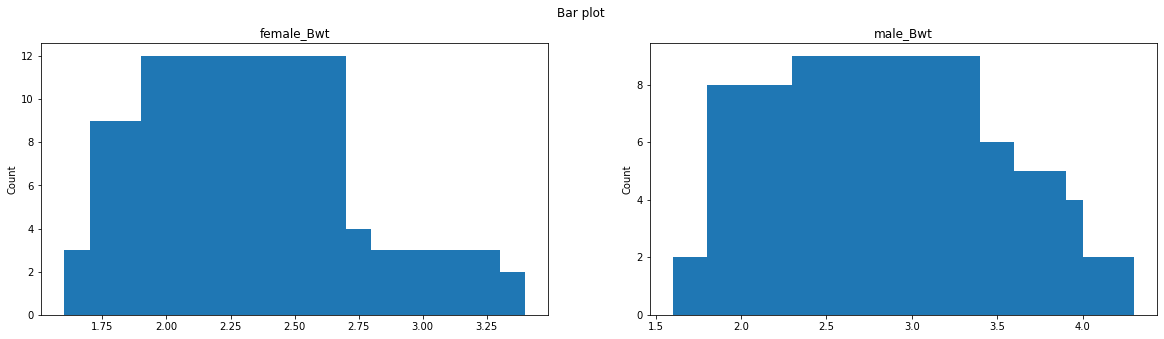

In [115]:
female_Bwt_cnt = pd.value_counts(female.values, sort=False)
male_Bwt_cnt = pd.value_counts(male.values, sort=False)

fig, axs = plt.subplots(1, 2,figsize=(20,5))
fig.suptitle('Bar plot')
width =0.4
axs[0].bar(female_Bwt_cnt.index, female_Bwt_cnt.values)
axs[0].set_title('female_Bwt')
axs[0].set_ylabel('Count')
axs[1].bar(male_Bwt_cnt.index, male_Bwt_cnt.values)
axs[1].set_title('male_Bwt')
axs[1].set_ylabel('Count')
plt.show()

##### Independent Sample T-test

In [116]:
# 등분산 만족 여부를 equal_var 파라미터로 표현
stats.ttest_ind(female, male, equal_var=False)

Ttest_indResult(statistic=-8.70948849909559, pvalue=8.831034455859356e-15)

##### Independent Sample Z-test

In [117]:
# enter IQ levels for 20 individuals from each city
cityA = [82, 84, 85, 89, 91, 91, 92, 94, 99, 99, 105, 109, 109, 109, 110, 112, 112, 113, 114, 114]
cityB = [90, 91, 91, 91, 95, 95, 99, 99, 108, 109, 109, 114, 115, 116, 117, 117, 128, 129, 130, 133]

statsmodels.stats.weightstats.ztest(cityA, cityB, value=0, alternative='two-sided')

(-1.9953236073282115, 0.04600759676133208)

#### Proportion test
- Z-statistic

In [118]:
success_cnts = np.array([70, 80])
total_cnts = np.array([100, 120])

test_stat, pval = statsmodels.stats.proportion.proportions_ztest(count=success_cnts, nobs=total_cnts, alternative='two-sided')
print('Two sided z-test: z = {:.4f}, p value = {:.4f}'.format(test_stat, pval))

Two sided z-test: z = 0.5285, p value = 0.5971


#### Variance test
- F-test

In [119]:
# 두 집단의 분산 차이 검정. 정규성에 민감
# 위에서 언급된 Equal Variance 검정 방법을 사용하는 것이 더 좋음
def f_var_test(x, y, direction="two-tailed"):
    df_1 = len(x)
    df_2 = len(y)
    f_stat = np.var(x, ddof=1) / np.var(y, ddof=1)
    
    tmp_p = stats.f.cdf(f_stat, df_1, df_2)
    if direction == "lower":
        p = tmp_p
    elif direction == "upper":
        p = 1 - tmp_p 
    else:
        p = 2*(1-tmp_p) if tmp_p > 0.5 else 2*tmp_p
    return f_stat, p

f_var_test(male, female)

(2.91119583076607, 9.872708416591713e-05)

## ANalysis Of VAriance
- 두 개 이상의 다수 집단 간 평균 비교
- 종속변수는 연속형, 독립변수는 범주형
- 각 집단의 정규분포 가정과 집단 내 등분산 가정이 필요하며, 이 가정이 깨지면 Welch의 방법 또는 비모수적 방법 시행
- 사후 검정: 적어도 한 집단에서 평균 차이가 있음이 증명되었을 때, 어떤 집단에서 차이가 존재하는지를 알아보는 방법

### (1) One-way
- 종속변수에 대한 하나의 범주형 변수의 영향 파악
- 각 집단 간 표본의 수는 동일하지 않아도 됨
- ANOVA (F-test), Kruskal-Wallis test

#### ANOVA (1)
- 종속변수와 독립변수 지정
- 회귀분석을 이용하는 경우

In [120]:
### Simple data
weather = ["cloudy", "cloudy", "rainy", "rainy", "sunny", "sunny"]
beer = [6, 8, 2, 4, 10, 12]

weather_beer = pd.DataFrame({
    "beer"   : beer,
    "weather": weather
})

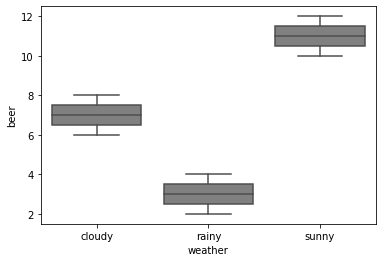

In [121]:
sns.boxplot(x="weather", y="beer", data=weather_beer, color='gray')
plt.show()

In [122]:
from statsmodels.stats.anova import anova_lm

In [123]:
anova_model = smf.ols("beer ~ weather", data=weather_beer).fit()
anova_model.summary()

/usr/local/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   beer   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     16.00
Date:                Sun, 29 Oct 2023   Prob (F-statistic):             0.0251
Time:                        23:07:10   Log-Likelihood:                -8.5136
No. Observations:                   6   AIC:                             23.03
Df Residuals:                       3   BIC:                             22.40
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.0000      1.000      7.000      0.006       3.818      10.182
weather[T.rainy]    -4.0000      1.414     -2.828      0.066      -8.501       0.501
weather[T.sunny]     4.0000      1.414      2.828      0.066      -0.501       8.501
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.333
Prob(Omnibus):                    nan   Jarque-Bera (JB):                1.000
Skew:                          -0.000   Prob(JB):                        0.607
Kurtosis:                       1.000   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [124]:
sm.stats.anova_lm(anova_model, typ=2)

,sum_sq,df,F,PR(>F)
weather,64.0,2.0,16.0,0.025095
Residual,6.0,3.0,NaN,NaN


In [125]:
# Predicted
anova_model.fittedvalues

0     7.0
1     7.0
2     3.0
3     3.0
4    11.0
5    11.0
dtype: float64

In [126]:
# Residuals
anova_model.resid

0   -1.0
1    1.0
2   -1.0
3    1.0
4   -1.0
5    1.0
dtype: float64

In [127]:
anova_model.params

Intercept           7.0
weather[T.rainy]   -4.0
weather[T.sunny]    4.0
dtype: float64

#### ANOVA (2)
- stats.f_oneway
- 각 집단별로 데이터가 변수로 구분되어 있는 경우

In [128]:
### Iris data
iris = pd.read_csv("./ADP_book_ver01/data/iris.csv")
iris.head(100)

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,Iris-versicolor
96,5.7,2.9,4.2,1.3,Iris-versicolor
97,6.2,2.9,4.3,1.3,Iris-versicolor
98,5.1,2.5,3.0,1.1,Iris-versicolor


In [129]:
iris["target"].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [130]:
iris.target.value_counts()

Iris-versicolor    50
Iris-setosa        50
Iris-virginica     50
Name: target, dtype: int64

In [131]:
target_list = iris["target"].unique()
setosa = iris[iris["target"]==target_list[0]]["sepal width"]
versicolor = iris[iris["target"]==target_list[1]]["sepal width"]
virginica = iris[iris["target"]==target_list[2]]["sepal width"]
print(target_list)

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


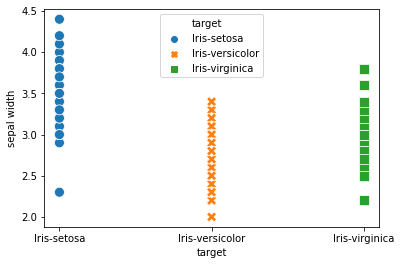

In [132]:
# Scatter plot by Groups
sns.scatterplot(x='target', 
                y='sepal width', 
                hue='target', # different colors by group
                style='target', # different shapes by group
                s=100, # marker size
                data=iris)
plt.show()

귀무가설(H0) <br>
세가지 종에 대해 sepal width의 평균 차이가 없다.<br>
대립가설(H1)<br>
적어도 하나의 종에 대한 sepal width의 평균 차이가 있다. <br>

In [133]:
### Normality test
print(stats.shapiro(setosa))
print(stats.shapiro(versicolor))
print(stats.shapiro(virginica))

ShapiroResult(statistic=0.968691885471344, pvalue=0.20465604960918427)
ShapiroResult(statistic=0.9741333723068237, pvalue=0.3379979133605957)
ShapiroResult(statistic=0.9673908352851868, pvalue=0.1809013932943344)


모든 집단이 다 정규성을 만족하므로, ANOVA를 진행한다.

In [134]:
### Equal variance test
# Levene test
stats.levene(setosa, versicolor, virginica)

LeveneResult(statistic=0.6475222363405327, pvalue=0.5248269975064537)

In [135]:
stats.f_oneway(setosa, versicolor, virginica)

F_onewayResult(statistic=47.36446140299382, pvalue=1.3279165184572242e-16)

[결과해석]
p-value가 유의수준보다 작으므로 '세가지 종의 꽃받침 폭의 평균은 차이가 있다'는 결론을 낼 수 있다.

#### Kruskal-Wallis test

In [136]:
# 서열 척도 이상의 데이터에 사용
stats.kruskal(setosa, versicolor, virginica)

KruskalResult(statistic=62.49463010053111, pvalue=2.6882119006774534e-14)

In [137]:
### (참고) Mood's Median Test
# Pearson 카이 제곱 검정의 특수한 경우
# 두 개 이상의 표본을 추출한 모집단의 중위수가 동일하다는 귀무가설을 검정하는 비모수 검정
stats.median_test(setosa, versicolor, virginica)

(50.22477971587844, 1.2411596758086847e-11, 3.0, array([[42,  8, 17],
        [ 8, 42, 33]]))

In [138]:
### if not equal variance
# Transformation / Scaling
# Welch's ANOVA

#### Welch's ANOVA
- 등분산성을 만족시키지 못하는 경우

In [139]:
### (참고) Welch's ANOVA
pg.welch_anova(data=iris, dv='sepal width', between='target')

,Source,ddof1,ddof2,F,p-unc,np2
0,target,2,97.369597,43.303381,3.519723e-14,0.391881


### (2) Two-way
- 하나의 종속변수 (연속형) 에 대한 두 개의 독립변수(범주형)의 영향을 알아보는 방법
- 교호작용 검증 필요. 교호작용이 있는 경우 주효과 검정은 의미가 없다
- ANOVA (F-test), Friedman test

In [140]:
mtcars = pd.read_csv('./ADP_book_ver01/data/mtcars.csv', index_col='Unnamed: 0')
mtcars.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [141]:
mtcars.describe()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.0000
mean,20.090625,6.187500,230.721875,146.687500,3.596563,3.217250,17.848750,0.437500,0.406250,3.687500,2.8125
std,6.026948,1.785922,123.938694,68.562868,0.534679,0.978457,1.786943,0.504016,0.498991,0.737804,1.6152
min,10.400000,4.000000,71.100000,52.000000,2.760000,1.513000,14.500000,0.000000,0.000000,3.000000,1.0000
25%,15.425000,4.000000,120.825000,96.500000,3.080000,2.581250,16.892500,0.000000,0.000000,3.000000,2.0000
50%,19.200000,6.000000,196.300000,123.000000,3.695000,3.325000,17.710000,0.000000,0.000000,4.000000,2.0000
75%,22.800000,8.000000,326.000000,180.000000,3.920000,3.610000,18.900000,1.000000,1.000000,4.000000,4.0000
max,33.900000,8.000000,472.000000,335.000000,4.930000,5.424000,22.900000,1.000000,1.000000,5.000000,8.0000


In [142]:
am0 = mtcars[mtcars.am==0]
am1 = mtcars[mtcars.am==1]

cyl4 = mtcars[mtcars.cyl==4]
cyl6 = mtcars[mtcars.cyl==6]
cyl8 = mtcars[mtcars.cyl==8]

In [143]:
### Normality test
# mpg data is normal
print(stats.shapiro(am0['mpg']))
print(stats.shapiro(am1['mpg']))

print(stats.shapiro(cyl4['mpg']))
print(stats.shapiro(cyl6['mpg']))
print(stats.shapiro(cyl8['mpg']))

ShapiroResult(statistic=0.9767745137214661, pvalue=0.8987393379211426)
ShapiroResult(statistic=0.9458037614822388, pvalue=0.5362744927406311)
ShapiroResult(statistic=0.9124392867088318, pvalue=0.26059386134147644)
ShapiroResult(statistic=0.8990352153778076, pvalue=0.32517871260643005)
ShapiroResult(statistic=0.9317531585693359, pvalue=0.3228558897972107)


In [144]:
### Equal variance test
# not equal variance
stats.levene(am0['mpg'], am1['mpg'])

LeveneResult(statistic=4.1876255537753995, pvalue=0.04957067404156203)

In [145]:
stats.levene(cyl4['mpg'], cyl6['mpg'], cyl8['mpg'])

LeveneResult(statistic=5.507064861977649, pvalue=0.009390247105110484)

In [146]:
mtcars['mpg_sqrt'] = np.sqrt(mtcars.mpg)

In [147]:
am0 = mtcars[mtcars.am==0]
am1 = mtcars[mtcars.am==1]

cyl4 = mtcars[mtcars.cyl==4]
cyl6 = mtcars[mtcars.cyl==6]
cyl8 = mtcars[mtcars.cyl==8]

In [148]:
stats.levene(am0['mpg_sqrt'], am1['mpg_sqrt'])

LeveneResult(statistic=1.8507055090956186, pvalue=0.1838361585926835)

In [149]:
stats.levene(cyl4['mpg_sqrt'], cyl6['mpg_sqrt'], cyl8['mpg_sqrt'])

LeveneResult(statistic=2.8688891317752816, pvalue=0.07296950644913348)

#### ANOVA

가설은 총 3가지로 정의할 수 있고, 상호작용 효과를 가장 먼저 검증한다.<br> <br>
귀무가설(H0) <br>
변속기 종류와 실린더 개수 간에는 상호작용 효과가 없다.<br>
대립가설(H1)<br>
변속기 종류와 실린더 개수 간에는 상호작용 효과가 있다.<br><br>
귀무가설(H0) <br>
실린더 개수에 따른 주행거리의 차이는 없다.<br>
대립가설(H1)<br>
실린더 개수에 따른 주행거리의 차이가 있다.<br><br>
귀무가설(H0) <br>
변속기 종류에 따른 주행거리의 차이는 없다.<br>
대립가설(H1)<br>
변속기 종류에 따른 주행거리의 차이는 있다. <br>


In [150]:
### Two-way ANOVA
formula = 'mpg_sqrt ~ C(cyl) + C(am) + C(cyl):C(am)'
model = smf.ols(formula, mtcars).fit()

aov_table = anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(cyl),5.634040,2.0,24.915357,9.050376e-07
C(am),0.387832,1.0,3.430212,7.540130e-02
C(cyl):C(am),0.209114,2.0,0.924763,4.092816e-01
Residual,2.939654,26.0,NaN,NaN


[결과해석]
교호작용의 p-value가 유의수준보다 크므로, 실린더 개수와 변속기 종류 간에는 교호작용이 존재하지 않는다. <br>
실린더 개수 변수에 대한 p-value는 유의수준보다 작으므로, 주효과 검정에서 귀무가설을 기각한다. 따라서 실린더 개수에 따른 주행거리 평균의 차이가 난다. <br>
변속기 종류 변수에 대한 p-value는 유의수준보다 크므로, 주효과 검정에서 귀무가설을 기각하지 않는다. 따라서 변속기 종류에 따른 주행거리 평균은 차이가 없다고 볼 수 있다.

In [151]:
from statsmodels.graphics.factorplots import interaction_plot

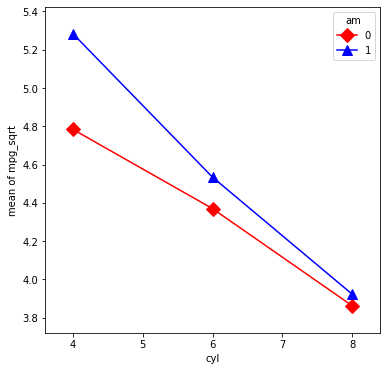

In [152]:
### interaction plot
# 교호작용 확인
# 독립변수 cyl,am와 종속변수 mpg을 Series로 변경 
cyl = mtcars["cyl"]
am = mtcars["am"]
mpg = mtcars["mpg_sqrt"]

fig, ax = plt.subplots(figsize=(6, 6))
fig = interaction_plot(cyl, am, mpg, colors=['red', 'blue'], markers=['D', '^'], ms=10, ax=ax) # 변수는 x1, x2 y 순

#### Friedman Test
- non-parametric ANOVA with blocked design
- 교호작용에 대한 검정은 Rank 특성 상 어려움

In [153]:
### pg package
pg.friedman(data=mtcars, dv="mpg", within="am", subject="cyl")

,Source,ddof1,Q,p-unc
Friedman,am,1,3.0,0.083265


In [154]:
pg.friedman(data=mtcars, dv="mpg", within="cyl", subject="am")

,Source,ddof1,Q,p-unc
Friedman,cyl,2,4.0,0.135335


[결과해석]
실린더 개수 변수에 대한 p-value는 유의수준보다 작으므로 귀무가설을 기각한다. 따라서 실린더 개수에 따른 주행거리 차이는 없다고 볼 수 있다. <br>
변속기 종류 변수에 대한 p-value는 유의수준보다 크므로 귀무가설을 기각하지 않는다. 따라서 변속기 종류에 따른 주행거리는 차이가 난다.

In [155]:
### stats package
# 각 데이터 길이가 동일해야 함
# 요약된 형태로 데이터가 주어질 때 유용
W = [1, 3, 1, 3, 1] #양식
K = [1, 3, 3, 1, 1] #한식
C = [2, 3, 3, 3, 1] #중식

data = pd.DataFrame(np.array([W, K, C]), index=['W', 'K', 'C'])

In [156]:
stats.friedmanchisquare(data.values[0], data.values[1], data.values[2])

FriedmanchisquareResult(statistic=2.666666666666673, pvalue=0.2635971381157259)

H0: 음식 종류에 따른 5명의 선호도에는 차이가 없다. <br>
H1: 음식 종류에 따른 5명의 선호도는 차이가 있다. <br>
[결과해석] Friedman test를 수행한 결과, 검정통계량 2.67, p-value 0.26으로 유의수준 0.05 하에서 귀무가설을 기각할 수 없다. 음식 종류에 따른 5명의 선호도에는 차이가 없다고 볼 수 있다.

### (3) ANCOVA
- 공변량의 영향을 고려한 분산분석
- 공변량은 연속형 변수
- ANOVA의 가정을 만족시켜야 함

In [157]:
### wt 변수를 공변량으로 설정하고, 실린더 개수 변수의 영향 측정
pg.ancova(data=mtcars, dv='mpg', covar='wt', between='cyl')

,Source,SS,DF,F,p-unc,np2
0,cyl,95.263290,2,7.285567,0.002835,0.342277
1,wt,118.203950,1,18.080056,0.000213,0.392362
2,Residual,183.058648,28,NaN,NaN,NaN


### (4) MANOVA
- 다변량 분산분석
- 종속변수 여러 개를 한 번에 검정
- 가정: 종속변수들의 정규성, Equal covariance

In [158]:
from statsmodels.multivariate.manova import MANOVA

In [159]:
maov = MANOVA.from_formula('cyl + am ~ mpg + wt', data=mtcars)
print(maov.mv_test())

                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.5871 2.0000 28.0000  9.8475 0.0006
         Pillai's trace 0.4129 2.0000 28.0000  9.8475 0.0006
 Hotelling-Lawley trace 0.7034 2.0000 28.0000  9.8475 0.0006
    Roy's greatest root 0.7034 2.0000 28.0000  9.8475 0.0006
------------------------------------------------------------
                                                            
------------------------------------------------------------
          mpg           Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.6864 2.0000 28.0000  6.3955 0.0052
         Pillai's trace 0.3136 2.0000 28.0000  6.3955 0.0052
 Hotelling-Lawley trace 0.4568 2.0000 28.0

In [160]:
### post-hoc -> 선형판별분석 진행

### (5) Post-hoc test

In [161]:
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from statsmodels.sandbox.stats.multicomp import multipletests

#### Fisher's LSD & Bonferroni adjustment
- T-test를 여러 번 수행하는 것
- 비교 대상이 많을수록 검정력이 떨어짐
- Tukey 보다 엄격함

In [162]:
mc = MultiComparison(data=iris["sepal width"], groups=iris["target"])

ret = mc.allpairtest(stats.ttest_ind, method='bonf', alpha=0.05)
ret[0] # 모든 집단의 평균이 다르다.

group1,group2,stat,pval,pval_corr,reject
Iris-setosa,Iris-versicolor,9.2828,0.0,0.0,True
Iris-setosa,Iris-virginica,6.2894,0.0,0.0,True
Iris-versicolor,Iris-virginica,-3.2058,0.0018,0.0055,True


#### Tukey's HSD
- Most powerful
- ANOVA 수행하지 않고도 결과를 볼 수 있음
- 집단별 sample 수가 동일해야 함

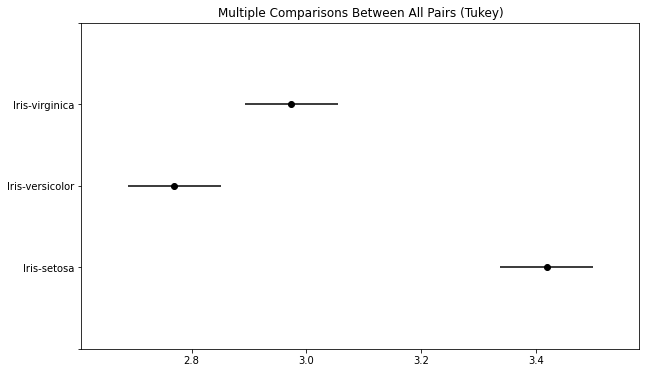

In [163]:
tukeyhsd = mc.tukeyhsd(alpha=0.05)
fig = tukeyhsd.plot_simultaneous()

In [164]:
tukeyhsd.summary() # 모든 집단의 평균이 다르다.

group1,group2,meandiff,p-adj,lower,upper,reject
Iris-setosa,Iris-versicolor,-0.648,0.0,-0.8092,-0.4868,True
Iris-setosa,Iris-virginica,-0.444,0.0,-0.6052,-0.2828,True
Iris-versicolor,Iris-virginica,0.204,0.009,0.0428,0.3652,True


In [165]:
### (참고) pingouin 패키지 사용
pg.pairwise_tukey(data=iris, dv='sepal width', between='target')

,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,Iris-setosa,Iris-versicolor,3.418,2.770,0.648,0.068084,two-sided,9.517713,0.001000,1.888937
1,Iris-setosa,Iris-virginica,3.418,2.974,0.444,0.068084,two-sided,6.521396,0.001000,1.294272
2,Iris-versicolor,Iris-virginica,2.770,2.974,-0.204,0.068084,two-sided,-2.996317,0.007891,-0.594665


In [166]:
### Two-way에서 1개 요인만 유의한 경우 사후 검정
# One-way와 동일
mc = MultiComparison(data=mtcars["mpg_sqrt"], groups=mtcars["cyl"])

ret = mc.allpairtest(stats.ttest_ind, method='bonf', alpha=0.05)
ret[0] # 모든 집단의 평균이 다르다.

group1,group2,stat,pval,pval_corr,reject
4,6,4.0877,0.0009,0.0026,True
4,8,8.2611,0.0,0.0,True
6,8,4.1621,0.0005,0.0016,True


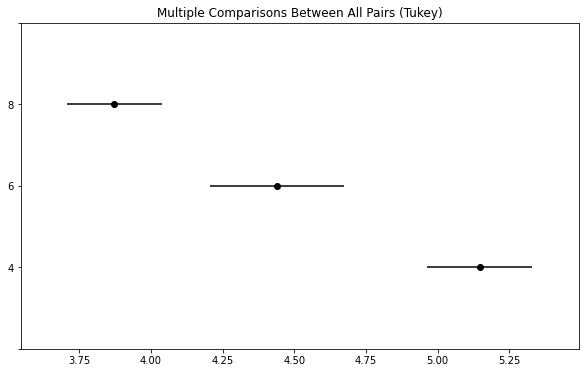

In [167]:
tukeyhsd = mc.tukeyhsd(alpha=0.05)
fig = tukeyhsd.plot_simultaneous()

In [168]:
tukeyhsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
4,6,-0.7064,0.0007,-1.1234,-0.2894,True
4,8,-1.275,0.0,-1.6224,-0.9275,True
6,8,-0.5686,0.004,-0.9678,-0.1693,True


#### Scheffe
- 가장 엄격한 Test

In [169]:
# ! pip install scikit-posthocs
import scikit_posthocs as sp

In [170]:
sp.posthoc_scheffe(iris, group_col='target', val_col='sepal width')

,Iris-setosa,Iris-versicolor,Iris-virginica
Iris-setosa,1.000000e+00,4.730163e-16,7.739781e-09
Iris-versicolor,4.730163e-16,1.000000e+00,1.281402e-02
Iris-virginica,7.739781e-09,1.281402e-02,1.000000e+00


#### Games Howell
- Equal variance가 아닌 경우 사용
- Welch's ANOVA의 사후검정 방법

In [171]:
pg.pairwise_gameshowell(data =iris, dv='sepal width', between='target')

,A,B,mean(A),mean(B),diff,se,tail,T,df,pval,hedges
0,Iris-setosa,Iris-versicolor,3.418,2.770,0.648,0.049361,two-sided,9.282773,94.525878,0.001000,1.842310
1,Iris-setosa,Iris-virginica,3.418,2.974,0.444,0.049918,two-sided,6.289385,95.395253,0.001000,1.248226
2,Iris-versicolor,Iris-virginica,2.770,2.974,-0.204,0.044997,two-sided,-3.205761,97.926827,0.004031,-0.636233


#### Duncan
- 일반적으로는 추천되지 않음
- 집단 개수가 같을 때 사용
- 비모수 검정에 사용 가능

In [172]:
sp.posthoc_dunn(iris, group_col='target', val_col='sepal width', p_adjust='holm')

,Iris-setosa,Iris-versicolor,Iris-virginica
Iris-setosa,1.000000e+00,3.247311e-14,2.292201e-07
Iris-versicolor,3.247311e-14,1.000000e+00,1.521219e-02
Iris-virginica,2.292201e-07,1.521219e-02,1.000000e+00


#### Mann-whitney
- Mann-whitney를 여러 번 수행하는 것
- 비모수적 검정

In [173]:
sp.posthoc_mannwhitney(iris, group_col='target', val_col='sepal width', alternative='two-sided') # 모든 집단의 평균이 다르다.

,Iris-setosa,Iris-versicolor,Iris-virginica
Iris-setosa,1.000000e+00,2.983442e-13,1.180877e-08
Iris-versicolor,2.983442e-13,1.000000e+00,4.572142e-03
Iris-virginica,1.180877e-08,4.572142e-03,1.000000e+00


#### Nemenyi test
- Tukey's HSD for non-parametric

In [174]:
sp.posthoc_conover(np.array([setosa, versicolor, virginica])) # 모든 집단의 평균이 다르다.

,1,2,3
1,1.000000e+00,1.765695e-18,1.356705e-10
2,1.765695e-18,1.000000e+00,1.890443e-03
3,1.356705e-10,1.890443e-03,1.000000e+00


#### Conover test
- 비모수적 검정

In [175]:
sp.posthoc_conover(np.array([setosa, versicolor, virginica])) # 모든 집단의 평균이 다르다.

,1,2,3
1,1.000000e+00,1.765695e-18,1.356705e-10
2,1.765695e-18,1.000000e+00,1.890443e-03
3,1.356705e-10,1.890443e-03,1.000000e+00


#### Post-hoc for Two way ANOVA

In [176]:
# !pip install bioinfokit
from bioinfokit.analys import stat

In [177]:
### Tukey for two-way anova
result = stat()

result.tukey_hsd(df=mtcars, res_var='mpg_sqrt', xfac_var=['cyl', 'am'], anova_model=formula)
result.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,"(6, 1)","(6, 0)",0.164238,-0.624832,0.953308,0.904417,0.900000
1,"(6, 1)","(4, 1)",0.748787,0.049352,1.448223,4.651803,0.030753
2,"(6, 1)","(4, 0)",0.249253,-0.594298,1.092804,1.283926,0.900000
3,"(6, 1)","(8, 1)",0.610588,-0.332531,1.553706,2.813145,0.376069
4,"(6, 1)","(8, 0)",0.671048,0.004162,1.337934,4.372329,0.047942
5,"(6, 0)","(4, 1)",0.913025,0.280362,1.545688,6.270767,0.001872
6,"(6, 0)","(4, 0)",0.413491,-0.375579,1.202561,2.276991,0.587789
7,"(6, 0)","(8, 1)",0.446350,-0.448371,1.341071,2.167695,0.629995
8,"(6, 0)","(8, 0)",0.506810,-0.089671,1.103291,3.691981,0.130121
9,"(4, 1)","(4, 0)",0.499534,-0.199902,1.198970,3.103330,0.274180


In [178]:
### Two-way, Non-parametric 사후 검정
# Nemenyi
sp.posthoc_nemenyi_friedman(a=mtcars, y_col='mpg_sqrt', block_col='am', group_col='cyl', melted=True)

,6,4,8
6,1.000000,0.036902,0.00331
4,0.036902,1.000000,0.00100
8,0.003310,0.001000,1.00000


In [179]:
# Conover
sp.posthoc_conover_friedman(a=mtcars, y_col='mpg_sqrt', block_col='am', group_col='cyl', melted=True)

,6,4,8
6,1.000000,0.500349,0.823937
4,0.500349,1.000000,0.630247
8,0.823937,0.630247,1.000000


In [180]:
# Mann-Whitney
# block 지정 불가
sp.posthoc_mannwhitney(a=mtcars, val_col='mpg', group_col='cyl', alternative='two-sided')

,4,6,8
4,1.000000,0.000666,0.000028
6,0.000666,1.000000,0.001013
8,0.000028,0.001013,1.000000


In [181]:
# Duncan
# block 지정 불가
sp.posthoc_dunn(a=mtcars, val_col='mpg_sqrt', group_col='cyl', p_adjust='holm')

,4,6,8
4,1.000000,0.053687,0.000001
6,0.053687,1.000000,0.053687
8,0.000001,0.053687,1.000000


## Contingency table
- 범주형 변수들 간의 관계를 설명하기 위한 방법

### (1) Chi-Square tests
- 각 범주의 기대빈도는 5 이상이어야 함
- Goodness of fit
    - 다항모집단 비율 차이 확인
    - 각 범주에 따른 데이터의 빈도분포가 이론적으로 기대하는 분포를 따르는지 검정
- Independence
    - 한 모집단 내 수준의 차이 확인 (교차분석)
    - 두 개의 변수 A, B의 관계가 독립인지 검정
- Homogeneity
    - 부분 모집단 간의 수준 차이 확인
    - 모집단이 임의의 변수에 따라 R개로 범주화되었을 때, R 개의 부분 모집단에서 추출한 표본이 C개의 범주화된 집단의 분포가 동일한지 검정

#### Goodness of fit test

In [182]:
### titanic data
df = pd.read_csv("./ADP_book_ver01/data/titanic.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   adult_male   891 non-null    bool   
 10  embark_town  889 non-null    object 
dtypes: bool(1), float64(2), int64(4), object(4)
memory usage: 70.6+ KB


In [183]:
df_t = df[df['survived']==1]
table = df_t[['sex']].value_counts()
table

sex   
female    233
male      109
dtype: int64

귀무가설(H0) <br>
타이타닉호 생존자 중 남자와 여자의 비율은 동일하다. (각 50%)<br>
대립가설(H1)<br>
타이타닉호 생존자 중 남자와 여자의 비율은 동일하지 않다. (각 50%)<br>

In [184]:
from scipy.stats import chisquare

In [185]:
expected = int(table.sum() / 2) # 50%
chi = chisquare(table, f_exp=[expected, expected]) # f_exp에 기대 빈도 입력
print('<적합도 검정>\n', chi)

<적합도 검정>
 Power_divergenceResult(statistic=44.95906432748538, pvalue=2.0119672574477238e-11)


In [186]:
### 다른 input
O = np.array([233, 109])
pr = np.array([0.5, 0.5]) # sum() =1
n = O.sum()
E = n * pr

In [187]:
chi2, p = chisquare(O, E) # f_exp에 기대 빈도 입력
print('<적합도 검정> chi-sq 통계량:', chi2, 'p-value:', p)

<적합도 검정> chi-sq 통계량: 44.95906432748538 p-value: 2.0119672574477238e-11


[결과해석]
P-value가 유의수준 (0.05)보다 작으므로 귀무가설을 기각한다. 타이타닉호 생존자의 성별 비율은 동일하다고 볼 수 없다.

#### Independence test / Homogeneity test

- 독립성 검정 <br>
귀무가설(H0) <br>
class (좌석등급) 변수와 생존 여부는 독립이다.<br>
대립가설(H1)<br>
class (좌석등급) 변수와 생존 여부는 독립이 아니다.<br>

- 동질성 검정 <br>
귀무가설(H0) <br>
class 변수의 분포는 생존 여부와 관계없이 동일하다.<br>
대립가설(H1)<br>
class 변수의 분포는 생존 여부와 관계가 있다.<br>

- 하나의 모집단에서 추출된 변수의 상관성 측적은 독립성, 두 개 모집단에서 추출된 변수의 분포 비교는 동질성 검정

In [188]:
table = pd.crosstab(df['class'], df['survived'])
table

survived,0,1
class,,
First,80,136
Second,97,87
Third,372,119


In [189]:
from scipy.stats import chi2_contingency

In [190]:
chi, p, df, expect = chi2_contingency(table) 
print('Statistic:', chi)
print('p-value:', p)
print('df:', df)
print('expect: \n', expect)

Statistic: 102.88898875696056
p-value: 4.549251711298793e-23
df: 2
expect: 
 [[133.09090909  82.90909091]
 [113.37373737  70.62626263]
 [302.53535354 188.46464646]]


[결과해석]
P-value가 유의수준 (0.05)보다 작으므로 귀무가설을 기각한다. class 변수와 생존여부 변수는 독립이 아니다. / class 변수의 분포는 생존 여부와 관계가 있다.

### (2) Fisher's exect test
- 사건 발생 가능성이 낮을 경우의 Chi-sq test
- 샘플이 적은 경우에 주로 사용
- Resampling 방법 사용하거나, 초기하분포를 이용한 계산

In [191]:
click_rate = pd.read_csv('./Practical_Statictics/data/click_rates.csv')
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
print(clicks)

Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988


In [192]:
### scipy의 exact test는 2*2만 지원
stats.fisher_exact(clicks.iloc[:2, :2].values)

(1.7606490872210954, 0.2835969483984848)

In [193]:
### unconditional exact test 
stats.barnard_exact(clicks.iloc[:2, :2].values)

BarnardExactResult(statistic=1.286298502909844, pvalue=0.20245372969560074)

In [194]:
# !pip install fisher-test-python
from fisher import fisher_test

In [195]:
fisher_test(clicks.values)

0.48241413094304153

### (3) McNemar test
- paired 범주형 변수의 Chi-sq test

- Marginal Probability가 같은지 검정 (b=c)
- Statictic: (b-c)**2/b + c ~ Chi-sq(1)
- H0: 전체에서 Before:present의 비율과, After:present의 비율이 같은가?" 또한 "Before:absent와 After:present의 비율이 같은가?"
- => 약 처방 후 환자의 상태는 변하지 않았다

In [196]:
from statsmodels.stats.contingency_tables import mcnemar

In [197]:
x = [[59, 6], [16, 80]]

In [198]:
print(mcnemar(x, exact=True, correction=True))

pvalue      0.052478790283203125
statistic   6.0


### (4) Cochran's Q test
- 세 집단 이상 대응표본 변수의 차이 검정
- Two-way randomized block designs
- Response variable (y) can take only two possible outcomes (coded as 0 and 1)
- Test if k treatments have identical effects (identical binomial proportions) <br>
H0: the treatments are equally effective <br>
H1: there is a difference in effectiveness between treat

In [199]:
from statsmodels.stats.contingency_tables import cochrans_q

In [200]:
y_true = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

y_model_1 = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

y_model_2 = np.array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

y_model_3 = np.array([1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

cochran_table = pd.DataFrame([y_true, y_model_1, y_model_2, y_model_3]).T
cochran_table.columns = ['y_true', 'y_model_1', 'y_model_2', 'y_model_3']
cochran_table

,y_true,y_model_1,y_model_2,y_model_3
0,0,1,1,1
1,0,1,1,1
2,0,1,1,1
3,0,1,1,0
4,0,1,1,0
...,...,...,...,...
95,0,0,0,0
96,0,0,0,0
97,0,0,0,0
98,0,0,0,1


In [201]:
print(cochrans_q(cochran_table))

df          3
pvalue      3.5427428824935784e-05
statistic   23.272727272727273


## Linear Regression
- Regression: 하나 혹은 그 이상의 변수들이 또 다른 변수에 미치는 영향 추론
- 모형의 적합성 확인
    - 모형이 통계적으로 유의미한가?
    - 회귀계수들이 유의미한가?
    - 모형의 설명력은 어떤가?
    - 모형이 데이터를 잘 적합하고 있는가? (잔차 확인)
    - 모형의 가정 만족
        - 독립/종속변수 간 선형성, 잔차와 독립변수의 독립성, 오차 등분산성, 관측치와 잔차의 비상관성, 잔차의 정규성
            - 정규성 가정 확인: Histogram, Q-Q plot, Jarque-bera test
            - 독립성 가정 확인: Durbin-Watson test: 잔차들의 자기상관성 평가. 2를 기준으로 0이면 양의 상관, 4면 음의 상관
- Outlier의 영향을 많이 받으므로, 적절한 처리 필요함
    - Outlier 처리
    - Robust Regression 사용

### (1) Simple Regression
- 독립변수의 개수가 하나인 경우
- statsmodels의 ols method

In [202]:
### 맥주 데이터
beer = pd.read_csv("./stats_for_python/5-1-1-beer.csv")
beer.head()

,beer,temperature
0,45.3,20.5
1,59.3,25.0
2,40.4,10.0
3,38.0,26.9
4,37.0,15.8


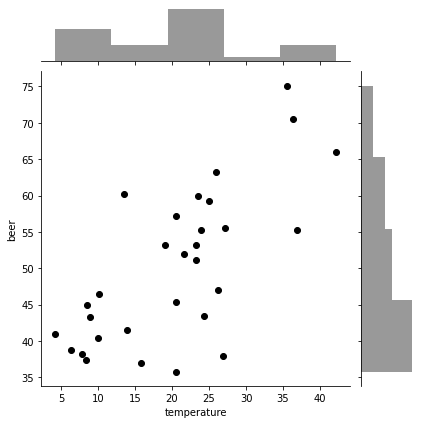

In [203]:
# 변수 확인
sns.jointplot(x="temperature", y="beer", data=beer, color='black')
plt.show()

In [204]:
### 독립변수와 종속변수 상관성 약 0.71
beer.corr()

,beer,temperature
beer,1.000000,0.709901
temperature,0.709901,1.000000


In [205]:
# Model 생성
lm_model = smf.ols(formula = "beer ~ temperature", data = beer).fit()
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   beer   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     28.45
Date:                Sun, 29 Oct 2023   Prob (F-statistic):           1.11e-05
Time:                        23:07:13   Log-Likelihood:                -102.45
No. Observations:                  30   AIC:                             208.9
Df Residuals:                      28   BIC:                             211.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      34.6102      3.235     10.699      0.000      27.984      41.237
temperature     0.7654      0.144      5.334      0.000       0.471       1.059
==============================================================================
Omnibus:                        0.587   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.746   Jarque-Bera (JB):                0.290
Skew:                          -0.240   Prob(JB):                        0.865
Kurtosis:                       2.951   Cond. No.                         52.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [206]:
# Parameters
lm_model.params

Intercept      34.610215
temperature     0.765428
dtype: float64

In [207]:
### ANOVA on regression
# 모델 유의성 확인
sm.stats.anova_lm(lm_model, typ=2)

,sum_sq,df,F,PR(>F)
temperature,1651.532489,1.0,28.446984,0.000011
Residual,1625.582178,28.0,NaN,NaN


In [208]:
### 모델 선택: 단순 회귀에서는 Null 모델과 비교
# NULL 모델
null_model = smf.ols("beer ~ 1", data = beer).fit()
null_model.aic

227.94194972563105

In [209]:
# 모델의 aic
lm_model.aic

208.90902935575437

In [210]:
# R-square
lm_model.rsquared

0.5039593230611858

In [211]:
# Adj R-square
lm_model.rsquared_adj

0.48624358459908534

In [212]:
### Prediction
y_pred = lm_model.predict()
y_pred

array([50.3014808 , 53.74590495, 42.26449113, 55.20021737, 46.70397114,
       37.82501112, 44.94348769, 54.51133254, 52.44467805, 41.11634975,
       54.66441806, 49.22988218, 53.21010564, 52.44467805, 41.03980699,
       52.59776357, 45.24965873, 61.78289462, 55.42984564, 50.3014808 ,
       42.41757665, 50.3014808 , 51.14345115, 40.6570932 , 66.91125946,
       52.9039346 , 62.85449324, 41.42252079, 62.47177945, 39.50895182])

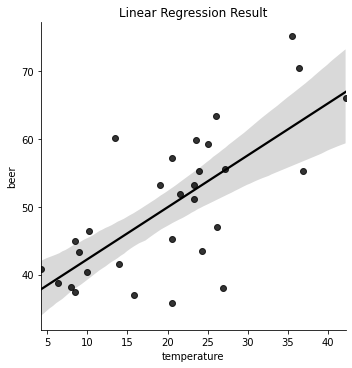

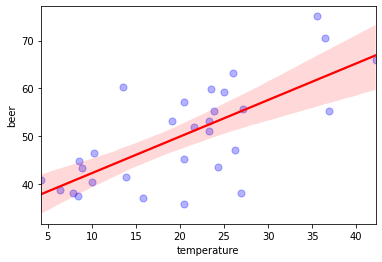

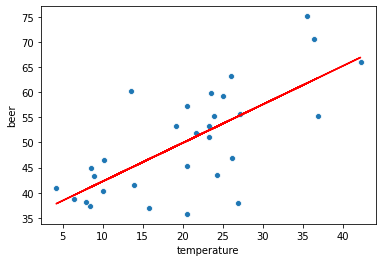

In [213]:
### 회귀직선 확인
# lmplot
sns.lmplot(x="temperature", y="beer", data=beer, scatter_kws={"color": "black"}, line_kws={"color": "black"})
plt.title('Linear Regression Result')
plt.show()

# regplot
sns.regplot(x=beer['temperature'], y=beer['beer'], scatter_kws={"fc":"b", "ec":"b", "s":50, "alpha":0.3}, color="r") # regplot으로 한줄 실행
plt.show()

# scatterplot
sns.scatterplot(x=beer['temperature'], y=beer['beer'])
plt.plot(beer['temperature'], y_pred, color='red') ## 회귀직선 추가 
plt.show()

In [214]:
# 특정 기온에 따른 매상 예측
lm_model.predict(pd.DataFrame({"temperature": [0]})) # Intercept와 일치

0    34.610215
dtype: float64

In [215]:
lm_model.predict(pd.DataFrame({"temperature":[20]}))

0    49.918767
dtype: float64

In [216]:
### Residuals
resid = lm_model.resid
resid.head(3)

0   -5.001481
1    5.554095
2   -1.864491
dtype: float64

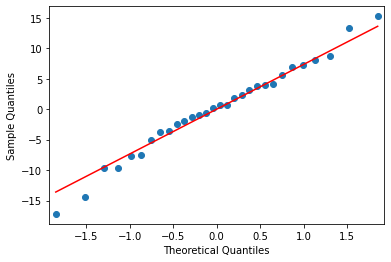

In [217]:
### Q-Q plot
# 잔차 정규성 확인
fig = sm.qqplot(resid, line="s")

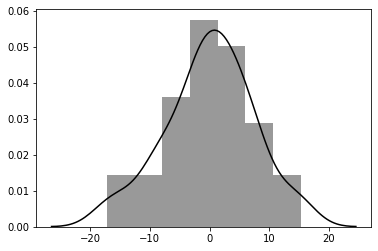

In [218]:
sns.distplot(resid, color='black', kde=True)
plt.show()

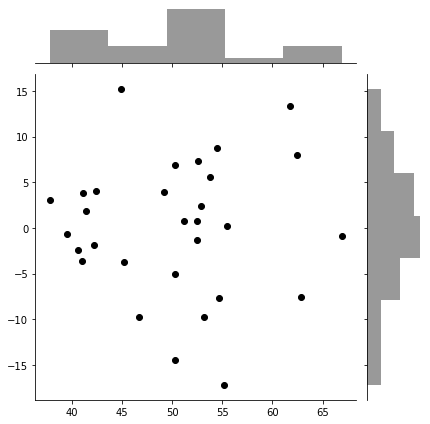

In [219]:
sns.jointplot(x=lm_model.fittedvalues, y=resid, joint_kws={"color": "black"}, marginal_kws={"color": "black"})

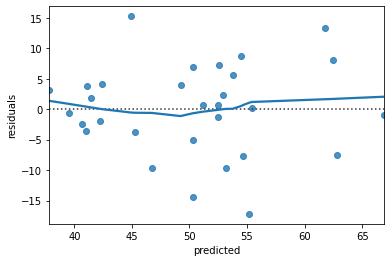

In [220]:
### Residual plot
# 잔차 등분산성 확인
# create a DataFrame of predicted values and residuals
plot_df = pd.DataFrame()
plot_df["predicted"] = y_pred
plot_df["residuals"] = lm_model.resid

### residplot
sns.residplot(data=plot_df, x="predicted", y="residuals", lowess=True)
plt.show()

### (2) Multiple Regression
- 독립변수 개수가 여러 개인 경우
- 독립변수 개수가 늘면 R-square 값은 항상 증가하므로, Adjusted R-square (변수 개수 고려)로 설명력 측정

#### Variable Selection
- 다중공선성 확인
    - VIF 10 이상
    - 독립변수 간 상관계수 0.9 이상
    - 독립변수 간 회귀분석의 허용오차(1-Rsquare) 0.1 이하
- 독립변수 선택: 최적의 회귀식 도출
    - 모든 가능한 조합
    - 단계적 변수선택: Forward, Backward, Stepwise
- 변수선택 기준
    - AIC(Akaike's Information Criteria): 모델에 변수를 추가할수록 불이익을 주는 오차 측정법
    - BIC(Bayesian Information Criteria): AIC와 유사하나, 변수 추가에 더 강한 패널티
    - Adj R-square: 모델에 변수를 추가할수록 결정계수에 불이익
    - Mallows Cp: AIC의 변형. Cp값이 작고, p+상수의 개수와 비슷할수록 편향이 작고 우수하다고 판단함
- 변수선택 방법
    - Simple Selection: VIF와 AIC 등등을 고려, 가장 낮은 오차를 가지는 모델 선택
    - Auto Selection: Simple selection 자동화. Foreward, Backward, Stepwise
    - Regularized Regression: Ridge, Lasso, ElasticNet 등으로 일부 변수 영향력 감소

##### Simple Selection

In [221]:
### Sales data
sales = pd.read_csv("./stats_for_python/5-3-1-lm-model.csv")
sales.head(3)

,humidity,price,sales,temperature,weather
0,29.5,290,229.7,17.8,rainy
1,38.1,290,206.1,26.1,rainy
2,31.5,290,202.5,22.0,rainy


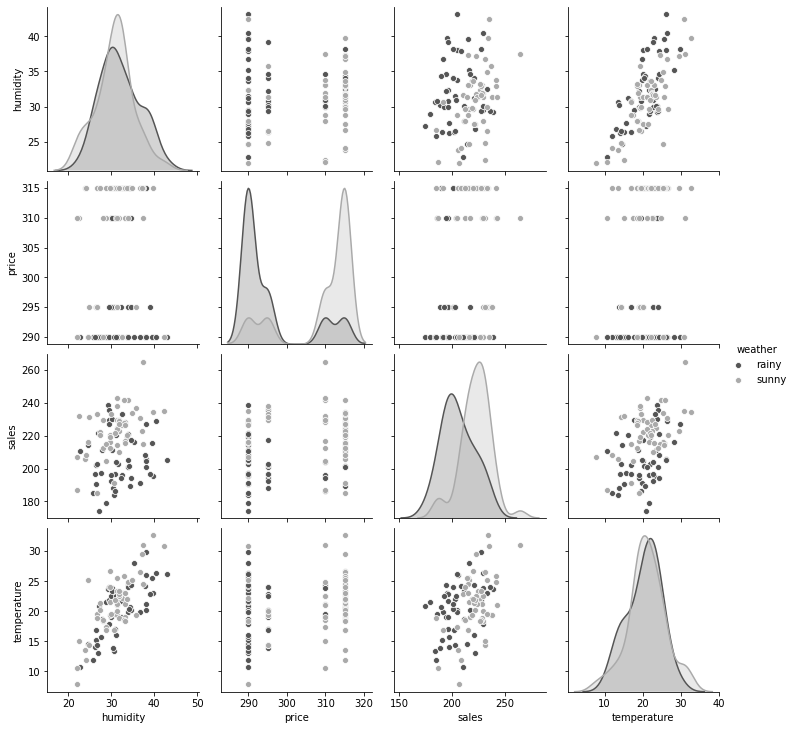

In [222]:
sns.pairplot(data=sales, hue="weather", palette="gray")
plt.show()

In [223]:
# 날씨 별 평균
sales.groupby("weather").mean()

,humidity,price,sales,temperature
weather,,,,
rainy,32.126,295.5,205.924,20.422
sunny,30.852,309.5,222.718,21.102


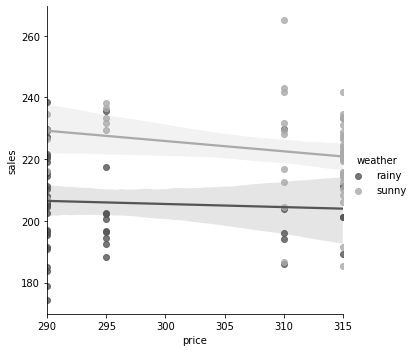

In [224]:
# 날씨 별 매상과 상품 가격
sns.lmplot(x="price", y="sales", data=sales, hue="weather", palette='gray')
plt.show()

In [225]:
from statsmodels.formula.api import ols

In [226]:
### Multiple X
lm_sales = smf.ols("sales ~ weather + humidity + temperature + price + weather:temperature", data=sales).fit()
lm_sales.params

Intercept                       280.707580
weather[T.sunny]                 15.945014
humidity                         -0.247287
temperature                       1.488547
weather[T.sunny]:temperature      0.195651
price                            -0.329064
dtype: float64

In [227]:
# Regression 계수 검정 (T-test) -> Type 2 ANOVA
lm_sales.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,280.7076,46.970,5.976,0.000,187.448,373.968
weather[T.sunny],15.9450,12.640,1.261,0.210,-9.152,41.042
humidity,-0.2473,0.458,-0.540,0.591,-1.157,0.663
temperature,1.4885,0.562,2.647,0.010,0.372,2.605
weather[T.sunny]:temperature,0.1957,0.587,0.333,0.740,-0.970,1.361
price,-0.3291,0.156,-2.113,0.037,-0.638,-0.020


In [228]:
# Null Model에서 시작하여 변수 선택
mod_null = smf.ols("sales ~ 1", sales).fit()
resid_sq_null = np.sum(mod_null.resid ** 2)
resid_sq_null

28968.525899999993

In [229]:
# 날씨가 들어간 모델
mod_1 = smf.ols("sales ~ weather", sales).fit()
sm.stats.anova_lm(mod_1).round(3)

,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.961,7050.961,31.527,0.0
Residual,98.0,21917.565,223.649,NaN,NaN


In [230]:
# 날씨 + 습도 모델
mod_2 = smf.ols("sales ~ weather + humidity", sales).fit()
sm.stats.anova_lm(mod_2).round(3)

,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.961,7050.961,33.963,0.000
humidity,1.0,1779.601,1779.601,8.572,0.004
Residual,97.0,20137.964,207.608,NaN,NaN


In [231]:
# 날씨 + 기온 모델
mod_2_2 = smf.ols("sales ~ weather + temperature", sales).fit()
sm.stats.anova_lm(mod_2_2).round(3)

,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.961,7050.961,37.781,0.0
temperature,1.0,3814.779,3814.779,20.441,0.0
Residual,97.0,18102.786,186.627,NaN,NaN


In [232]:
# 날씨 + 기온 + 습도 모델
# 습도의 효과가 높지 않음 (유의하지 않음)
mod_3_2 = smf.ols("sales ~ weather + temperature + humidity", sales).fit()
sm.stats.anova_lm(mod_3_2).round(3)

,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.961,7050.961,37.478,0.000
temperature,1.0,3814.779,3814.779,20.277,0.000
humidity,1.0,41.667,41.667,0.221,0.639
Residual,96.0,18061.119,188.137,NaN,NaN


In [233]:
# 날씨:기온 교호작용 추가 모델
# 교호작용은 없음
mod_4_2 = smf.ols("sales ~ weather + temperature + weather:temperature", sales).fit()
sm.stats.anova_lm(mod_3_2).round(3)

,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.961,7050.961,37.478,0.000
temperature,1.0,3814.779,3814.779,20.277,0.000
humidity,1.0,41.667,41.667,0.221,0.639
Residual,96.0,18061.119,188.137,NaN,NaN


In [234]:
# 전체 변수 모델
mod_full = smf.ols("sales ~ weather + humidity + temperature + price", sales).fit()
sm.stats.anova_lm(mod_full, typ=2).round(3)

,sum_sq,df,F,PR(>F)
weather,5845.878,1.0,32.208,0.000
humidity,56.425,1.0,0.311,0.578
temperature,2378.017,1.0,13.102,0.000
price,818.402,1.0,4.509,0.036
Residual,17242.717,95.0,NaN,NaN


In [235]:
# 습도 제외 모델
mod_non_humi = smf.ols("sales ~ weather + temperature + price", sales).fit()
sm.stats.anova_lm(mod_non_humi, typ=2).round(3)

,sum_sq,df,F,PR(>F)
weather,6354.966,1.0,35.266,0.000
temperature,4254.736,1.0,23.611,0.000
price,803.644,1.0,4.460,0.037
Residual,17299.142,96.0,NaN,NaN


In [236]:
# 2개 모델 비교
mod_full.compare_f_test(mod_non_humi)

(0.31087803756963617, 0.578453342712073, 1.0)

In [237]:
# AIC 비교
print("Full:", mod_full.aic.round(3))
print("습도 제외:", mod_non_humi.aic.round(3))

Full: 808.785
습도 제외: 807.112


In [238]:
# BIC 비교
print("Full:", mod_full.bic.round(3))
print("습도 제외:", mod_non_humi.bic.round(3))

Full: 821.811
습도 제외: 817.533


In [239]:
# Adj R-square 비교
print("Full:", mod_full.rsquared_adj.round(3))
print("습도 제외:", mod_non_humi.rsquared_adj.round(3))

Full: 0.38
습도 제외: 0.384


In [240]:
# Cp 계산 및 비교
n = mod_non_humi.nobs
p = mod_full.df_model
p_non_humi = mod_non_humi.df_model

print("Full:", round(sum((mod_full.resid)**2)/mod_full.mse_resid - (n-2*(p+1)), 3))
print("습도 제외:", round(sum((mod_non_humi.resid)**2)/mod_full.mse_resid - (n-2*(p_non_humi+1)), 3))

Full: 5.0
습도 제외: 3.311


##### Auto Selection

In [241]:
### 모델 선택 함수
import time
import itertools
import statsmodels.api as sm

def process_subset(x, y, feature_set):
    model = sm.OLS(y, x[list(feature_set)]) # Modeling
    regr = model.fit() # 모델 학습
    criteria = regr.aic # 모델의 AIC. 이 부분을 변경하면 기준을 바꿀 수 있음
    # regr.bic
    # regr.rsquared_adj
    
    return {"model": regr, "criteria": criteria}
        
# 전진선택법
def forward(x, y, predictors):
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    remaining_predictors = [p for p in x.columns.difference(['Intercept']) if p not in predictors]
    results = []
    for p in remaining_predictors:
        results.append(process_subset(x=x, y=y, feature_set=predictors + [p] + ['Intercept']))
        
    # 데이터프레임으로 변환
    models = pd.DataFrame(results)
    # AIC가 가장 낮은 것을 선택. 기준에 따라 변경 필요
    best_model = models.loc[models['criteria'].argmin()] # index
    print("Processed ", models.shape[0], "models on", len(predictors) + 1, "predictors in")
    print('Selected predictors:', best_model['model'].model.exog_names,' Criteria: ', best_model[0])
    
    return best_model

# 후진소거법
def backward(x, y, predictors):
    tic = time.time()
    results = []
    
    # 데이터 변수들이 미리정의된 predictors 조합 확인
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(process_subset(x=x, y=y, feature_set=list(combo) + ['Intercept']))
    models = pd.DataFrame(results)
    
    # 가장 낮은 AIC를 가진 모델을 선택. 기준에 따라 변경 필요
    best_model = models.loc[models['criteria'].argmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors) -1, "predictors in", (toc - tic))
    print('Selected predictors:',best_model['model'].model.exog_names, 'Criteria: ',best_model[0] )

    return best_model

# 단계적 선택법
def stepwise_model(x, y):
    stepmodels = pd.DataFrame(columns=["criteria", "model"])
    tic = time.time()
    predictors = []
    s_model_before = process_subset(x, y, predictors + ['Intercept'])['criteria']
    print("Criteria, Before selection:", s_model_before)

    for i in range(1, len(x.columns.difference(['Intercept'])) +1):
        forward_result = forward(x=x, y=y, predictors=predictors) 
        print('forward')
        stepmodels.loc[i] = forward_result
        predictors = stepmodels.loc[i]["model"].model.exog_names
        predictors = [ k for k in predictors if k !='Intercept']
        backward_result = backward(x=x, y=y, predictors=predictors)

        if backward_result['criteria'] < forward_result['criteria']:
            stepmodels.loc[i] = backward_result
            predictors = stepmodels.loc[i]["model"].model.exog_names
            s_model_before = stepmodels.loc[i]["criteria"]
            predictors = [k for k in predictors if k !='Intercept']
            print('backward')
            
        print("Criteria: ", stepmodels.loc[i]['criteria'])
        if stepmodels.loc[i]['criteria'] > s_model_before: # 기준에 따라 멈춤 기준 변경 필요
            break
        else:
            s_model_before = stepmodels.loc[i]["criteria"]
            
    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")

    return (stepmodels['model'][len(stepmodels['model'])])

In [242]:
### 전진선택법 구현
def forward_model(x, y):
    formodels = pd.DataFrame(columns=["criteria", "model"])
    tic = time.time()
    predictors = []
    model_result_before = process_subset(x, y, predictors + ['Intercept'])
    s_model_before = model_result_before['criteria']
    print("Criteria, Before selection:", s_model_before)

    for i in range(1, len(x.columns.difference(['Intercept'])) + 1):
        forward_result = forward(x=x, y=y, predictors=predictors) 
        print('forward')
        formodels.loc[i] = forward_result
        predictors = formodels.loc[i]["model"].model.exog_names
        predictors = [ k for k in predictors if k !='Intercept']
        print("Criteria: ", formodels.loc[i]['criteria'])
        if formodels.loc[i]['criteria'] > s_model_before:
            break
        else:
            s_model_before = formodels.loc[i]["criteria"]
            
    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")
    
    if len(predictors)==len(x.columns.difference(['Intercept'])):
        return (formodels['model'][len(formodels['model'])])
    elif len(predictors)==1:
        return model_result_before['model']
    else:
        return (formodels['model'][len(formodels['model'])-1])

### 후진선택법 구현
def backward_model(x, y):
    backmodels = pd.DataFrame(columns=["criteria", "model"])
    tic = time.time()
    predictors = list(x.columns.difference(['Intercept']))
    model_result_before = process_subset(x, y, predictors)
    s_model_before = model_result_before['criteria']
    print("Criteria, Before selection:", s_model_before)

    for i in range(1, len(x.columns.difference(['Intercept'])) + 1):
        backward_result = backward(x=x, y=y, predictors=predictors) 
        print('backward')
        backmodels.loc[i] = backward_result
        predictors = backmodels.loc[i]["model"].model.exog_names
        predictors = [ k for k in predictors if k !='Intercept']
        print("Criteria: ", backmodels.loc[i]['criteria'])
        if backmodels.loc[i]['criteria'] > s_model_before:
            break
        else:
            s_model_before = backmodels.loc[i]["criteria"]
            
    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")
    
    if len(predictors)==0:
        return (backmodels['model'][len(backmodels['model'])])
    elif len(predictors)==len(x.columns.difference(['Intercept']))-1:
        return model_result_before['model']
    else:
        return (backmodels['model'][len(backmodels['model'])-1])


In [243]:
### Cars data
# 데이터 불러오기
cars = pd.read_csv('./ADP_book_ver01/data/Cars93.csv')
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Manufacturer        93 non-null     object 
 1   Model               93 non-null     object 
 2   Type                93 non-null     object 
 3   Min.Price           93 non-null     float64
 4   Price               93 non-null     float64
 5   Max.Price           93 non-null     float64
 6   MPG.city            93 non-null     int64  
 7   MPG.highway         93 non-null     int64  
 8   AirBags             93 non-null     object 
 9   DriveTrain          93 non-null     object 
 10  Cylinders           93 non-null     object 
 11  EngineSize          93 non-null     float64
 12  Horsepower          93 non-null     int64  
 13  RPM                 93 non-null     int64  
 14  Rev.per.mile        93 non-null     int64  
 15  Man.trans.avail     93 non-null     object 
 16  Fuel.tank.

In [244]:
# ols 모델의 formula을 정의할 때, 일부 특수문자는 쓸 수 없기에, 컬럼 특수문자 제거 
cars.columns = cars.columns.str.replace(".", "")

In [245]:
model = smf.ols(formula="Price ~ EngineSize + RPM + Weight + Length + MPGcity + MPGhighway", data=cars)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     19.14
Date:                Sun, 29 Oct 2023   Prob (F-statistic):           4.88e-14
Time:                        23:07:16   Log-Likelihood:                -302.94
No. Observations:                  93   AIC:                             619.9
Df Residuals:                      86   BIC:                             637.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -32.2157     17.812     -1.809      0.074     -67.625       3.193
EngineSize     4.4732      1.410      3.172      0.002       1.670       7.276
RPM            0.0071      0.001      5.138      0.000       0.004       0.010
Weight         0.0056      0.003      1.634      0.106      -0.001       0.012
Length        -0.0464      0.094     -0.496      0.621      -0.232       0.139
MPGcity       -0.3478      0.448     -0.776      0.440      -1.239       0.544
MPGhighway     0.0582      0.460      0.126      0.900      -0.856       0.973
==============================================================================
Omnibus:                       62.984   Durbin-Watson:                   1.446
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              383.289
Skew:                           2.074   Prob(JB):                     5.89e-84
Kurtosis:                      12.039   Cond. No.                     1.61e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [246]:
### correlation 확인
cars[['EngineSize', 'RPM', 'Weight', 'Length', 'MPGcity', 'MPGhighway']].corr()

,EngineSize,RPM,Weight,Length,MPGcity,MPGhighway
EngineSize,1.000000,-0.547898,0.845075,0.780283,-0.710003,-0.626795
RPM,-0.547898,1.000000,-0.427931,-0.441249,0.363045,0.313469
Weight,0.845075,-0.427931,1.000000,0.806274,-0.843139,-0.810658
Length,0.780283,-0.441249,0.806274,1.000000,-0.666239,-0.542897
MPGcity,-0.710003,0.363045,-0.843139,-0.666239,1.000000,0.943936
MPGhighway,-0.626795,0.313469,-0.810658,-0.542897,0.943936,1.000000


In [247]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [248]:
### VIF 계산
y, x = dmatrices("Price ~ EngineSize + RPM + Weight + Length + MPGcity + MPGhighway", data=cars, return_type="dataframe")

# 독립변수끼리의 VIF값을 계산하여 데이터프레임으로 만드는 과정 
vif_list = []
for i in range(1, len(x.columns)): 
    vif_list.append([variance_inflation_factor(x.values, i), x.columns[i]])
pd.DataFrame(vif_list, columns=['vif', 'variable'])

,vif,variable
0,4.605118,EngineSize
1,1.446859,RPM
2,8.685973,Weight
3,4.013002,Length
4,13.668288,MPGcity
5,12.943133,MPGhighway


In [249]:
### VIF 10 이상인 변수를 지우는 함수
def apply_vif(data, target_col):
    vif_df = pd.DataFrame()
    x_columns = list(data.columns.difference([target_col]))
    for j in range(len(x_columns)):
        x_str = ''
        for i, column in enumerate(x_columns):
            if i == len(x_columns) -1:
                x_str += column
            else:
                x_str += column + ' + '
    
        y, x = dmatrices(f"{target_col} ~ {x_str}", data=data, return_type="dataframe")
    
        vif_list = []
        for i in range(1, len(x.columns)): 
            vif_list.append([variance_inflation_factor(x.values, i), x.columns[i]])
        vif_df = pd.DataFrame(vif_list, columns=['vif', 'variable'])
        
        if vif_df['vif'].max() > 10:
            del_column = vif_df['variable'][vif_df['vif']==vif_df['vif'].max()].values[0]
            x_columns.remove(del_column)
        else:
            break
    
    return y, x, vif_df

In [250]:
y, x, vif_df = apply_vif(cars[['EngineSize', 'RPM', 'Weight', 'Length', 'MPGcity', 'MPGhighway', 'Price']], "Price")
vif_df

,vif,variable
0,4.471987,EngineSize
1,3.456037,Length
2,3.281779,MPGhighway
3,1.445721,RPM
4,8.597026,Weight


In [251]:
### MPGcity 변수 제거
model = smf.ols(formula="Price ~ EngineSize + RPM + Weight + MPGhighway", data=cars)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     28.98
Date:                Sun, 29 Oct 2023   Prob (F-statistic):           2.26e-15
Time:                        23:07:16   Log-Likelihood:                -303.29
No. Observations:                  93   AIC:                             616.6
Df Residuals:                      88   BIC:                             629.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -37.7063     14.846     -2.540      0.013     -67.210      -8.203
EngineSize     4.5884      1.343      3.418      0.001       1.920       7.256
RPM            0.0071      0.001      5.232      0.000       0.004       0.010
Weight         0.0049      0.003      1.690      0.095      -0.001       0.011
MPGhighway    -0.2646      0.221     -1.200      0.234      -0.703       0.174
==============================================================================
Omnibus:                       62.072   Durbin-Watson:                   1.398
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              368.013
Skew:                           2.047   Prob(JB):                     1.22e-80
Kurtosis:                      11.843   Cond. No.                     1.35e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

다중공선성 변수(MPGcity) 제거 후 MPGhighway의 유의성이 올라갔음.

In [252]:
### Stepwise selection
stepwise_model(x=x, y=y).summary()

Criteria, Before selection: 686.7529864151061
Processed  5 models on 1 predictors in
Selected predictors: ['Weight', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0xffff3a814c10>
forward
Processed  1 models on 0 predictors in 0.0008149147033691406
Selected predictors: ['Intercept'] Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0xffff3a882e10>
Criteria:  638.2790669305498
Processed  4 models on 2 predictors in
Selected predictors: ['Weight', 'RPM', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0xffff3a814f90>
forward
Processed  2 models on 1 predictors in 0.0012569427490234375
Selected predictors: ['Weight', 'Intercept'] Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0xffff3a882350>
Criteria:  624.5241529342444
Processed  3 models on 3 predictors in
Selected predictors: ['Weight', 'RPM', 'EngineSize', 'Intercept'] 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     37.98
Date:                Sun, 29 Oct 2023   Prob (F-statistic):           6.75e-16
Time:                        23:07:16   Log-Likelihood:                -304.05
No. Observations:                  93   AIC:                             616.1
Df Residuals:                      89   BIC:                             626.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Weight         0.0073      0.002      3.372      0.001       0.003       0.012
RPM            0.0071      0.001      5.208      0.000       0.004       0.010
EngineSize     4.3054      1.325      3.249      0.002       1.673       6.938
Intercept    -51.7933      9.106     -5.688      0.000     -69.887     -33.699
==============================================================================
Omnibus:                       62.441   Durbin-Watson:                   1.406
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              361.880
Skew:                           2.076   Prob(JB):                     2.62e-79
Kurtosis:                      11.726   Cond. No.                     8.27e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [253]:
### Backward selection
backward_model(x=x, y=y).summary()

Criteria, Before selection: 621.0794757132377
Processed  5 models on 4 predictors in 0.00379180908203125
Selected predictors: ['EngineSize', 'MPGhighway', 'RPM', 'Weight', 'Intercept'] Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0xffff3a8307d0>
backward
Criteria:  616.5890684898023
Processed  4 models on 3 predictors in 0.002960205078125
Selected predictors: ['EngineSize', 'RPM', 'Weight', 'Intercept'] Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0xffff3a83c390>
backward
Criteria:  616.0976497740975
Processed  3 models on 2 predictors in 0.0022420883178710938
Selected predictors: ['RPM', 'Weight', 'Intercept'] Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0xffff3a882a10>
backward
Criteria:  624.5241529342444
Total elapsed time: 0.015240669250488281 seconds.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     37.98
Date:                Sun, 29 Oct 2023   Prob (F-statistic):           6.75e-16
Time:                        23:07:16   Log-Likelihood:                -304.05
No. Observations:                  93   AIC:                             616.1
Df Residuals:                      89   BIC:                             626.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
EngineSize     4.3054      1.325      3.249      0.002       1.673       6.938
RPM            0.0071      0.001      5.208      0.000       0.004       0.010
Weight         0.0073      0.002      3.372      0.001       0.003       0.012
Intercept    -51.7933      9.106     -5.688      0.000     -69.887     -33.699
==============================================================================
Omnibus:                       62.441   Durbin-Watson:                   1.406
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              361.880
Skew:                           2.076   Prob(JB):                     2.62e-79
Kurtosis:                      11.726   Cond. No.                     8.27e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [254]:
### Forward selection
forward_model(x=x, y=y).summary()

Criteria, Before selection: 686.7529864151061
Processed  5 models on 1 predictors in
Selected predictors: ['Weight', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0xffff3a7d8110>
forward
Criteria:  638.2790669305498
Processed  4 models on 2 predictors in
Selected predictors: ['Weight', 'RPM', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0xffff3a830790>
forward
Criteria:  624.5241529342444
Processed  3 models on 3 predictors in
Selected predictors: ['Weight', 'RPM', 'EngineSize', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0xffff3a814b10>
forward
Criteria:  616.0976497740975
Processed  2 models on 4 predictors in
Selected predictors: ['Weight', 'RPM', 'EngineSize', 'MPGhighway', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0xffff3a830d50>
forward
Criteria:  616.5890684898023
Total e

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     37.98
Date:                Sun, 29 Oct 2023   Prob (F-statistic):           6.75e-16
Time:                        23:07:16   Log-Likelihood:                -304.05
No. Observations:                  93   AIC:                             616.1
Df Residuals:                      89   BIC:                             626.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Weight         0.0073      0.002      3.372      0.001       0.003       0.012
RPM            0.0071      0.001      5.208      0.000       0.004       0.010
EngineSize     4.3054      1.325      3.249      0.002       1.673       6.938
Intercept    -51.7933      9.106     -5.688      0.000     -69.887     -33.699
==============================================================================
Omnibus:                       62.441   Durbin-Watson:                   1.406
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              361.880
Skew:                           2.076   Prob(JB):                     2.62e-79
Kurtosis:                      11.726   Cond. No.                     8.27e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

[결과해석]
- (1) 모델 설명 <br>
Stepwise selection을 통해 Weight, RPM, EngineSize가 포함된 다중 선형 회귀 모델을 채택하였다. 이 모델은  Adj.R-square 값이 0.547로 전체 데이터의 약 54.7%를 설명한다. <br>
설명력이 높은 모델은 아니므로 추가적인 변수를 찾아 데이터를 보완해야 할 필요성이 있다.
- (2) 회귀식  <br>
y = 0.0073Weight + 0.0071RPM + 4.3054EngineSize - 51.7933
- (3) 회귀계수 설명  <br>
모델의 성능이 좋지 않아 회귀계수의 값이 정확하다고 말할 수는 없지만, 회귀식에서 차량의 가격에 가장 큰 영향을 주는 변수는 EngineSize라고 할 수 있다. <br>
반면 Weight, RPM은 유의한 변수이지만, 회귀계수가 너무 작아 영향력이 거의 없다.

#### Influential Values
- 영향도 높은 데이터 (이상치) 확인
- Methods
    - Leverage H
    - Cook's distance
    - DFFITS
    - DFBETAS

In [255]:
house = pd.read_csv('./Practical_Statictics/data/house_sales.csv', sep='\t')
house_98105 = house.loc[house['ZipCode']==98105, ]

In [256]:
house_outlier = smf.ols('AdjSalePrice ~ SqFtTotLiving + SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_98105)
result_98105 = house_outlier.fit()
result_98105.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     238.7
Date:                Sun, 29 Oct 2023   Prob (F-statistic):          1.69e-103
Time:                        23:07:16   Log-Likelihood:                -4226.0
No. Observations:                 313   AIC:                             8464.
Df Residuals:                     307   BIC:                             8486.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -7.725e+05   9.83e+04     -7.861      0.000   -9.66e+05   -5.79e+05
SqFtTotLiving   209.6023     24.408      8.587      0.000     161.574     257.631
SqFtLot          38.9333      5.330      7.305      0.000      28.445      49.421
Bathrooms      2282.2641      2e+04      0.114      0.909    -3.7e+04    4.16e+04
Bedrooms      -2.632e+04   1.29e+04     -2.043      0.042   -5.17e+04    -973.867
BldgGrade        1.3e+05   1.52e+04      8.533      0.000       1e+05     1.6e+05
==============================================================================
Omnibus:                       82.127   Durbin-Watson:                   1.508
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              586.561
Skew:                           0.859   Prob(JB):                    4.26e-128
Kurtosis:                       9.483   Cond. No.                     5.63e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [257]:
from statsmodels.stats.outliers_influence import OLSInfluence

In [258]:
influence = OLSInfluence(result_98105)
sresiduals = influence.resid_studentized_internal # 잔차를 표준편차 추정치로 나눈 것

print(sresiduals.idxmin(), sresiduals.min())

24333 -4.3267318040785705


In [259]:
result_98105.resid.loc[sresiduals.idxmin()] # s-residual이 가장 작은 1개 선택

-757753.6192115839

In [260]:
### Outlier 확인
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

outlier = house_98105.loc[sresiduals.idxmin(), :]
print('AdjSalePrice', outlier[outcome], '\n')
print(outlier[predictors])

AdjSalePrice 119748.0 

SqFtTotLiving    2900
SqFtLot          7276
Bathrooms           3
Bedrooms            6
BldgGrade           7
Name: 24333, dtype: object


##### Leverage H
- y가 y-hat에 미치는 영향도
- 2*(p+1)/n 이상의 값은 레버리지가 높다고 볼 수 있음

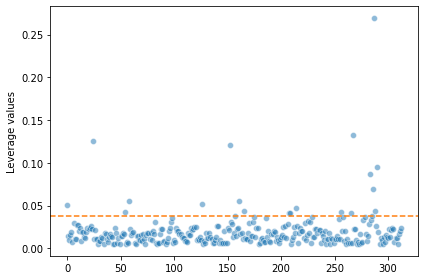

In [261]:
cutoff = 2*(len(predictors)+1)/len(house_98105)
influence = OLSInfluence(result_98105)
sns.scatterplot(data=pd.Series(influence.hat_matrix_diag), alpha=0.5)
plt.axhline(cutoff, linestyle='--', color='C1')
plt.ylabel('Leverage values')
plt.tight_layout()
plt.show()

##### Cook's distance
- 관측치가 회귀 모델의 영향을 주는 크기 측정
- 해당 관측치를 제거한 회귀 모델과, 그렇지 않은 회귀모델의 관측치 적합 값 비교
- 4/(n-p-1)보다 클 경우 영향력이 높다고 판단, 1보다 크면 영향치로 간주

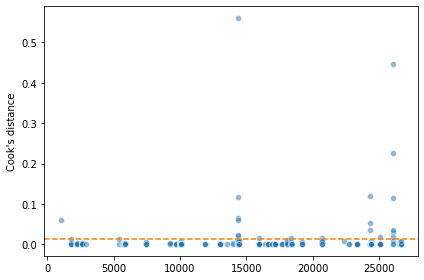

In [262]:
cutoff = 4/(len(house_98105)-len(predictors)-1)
sns.scatterplot(x=influence.cooks_distance[0].index, y=influence.cooks_distance[0].values, alpha=0.5)
# sns.scatterplot(x=influence.hat_matrix_diag, y=influence.resid_studentized_internal, size=100000 * np.sqrt(influence.cooks_distance[0]), alpha=0.5) #
plt.axhline(cutoff, linestyle='--', color='C1')
plt.ylabel("Cook's distance")
plt.tight_layout()
plt.show()

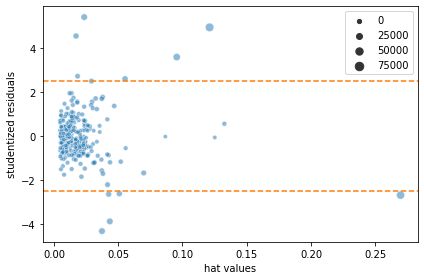

In [263]:
sns.scatterplot(x=influence.hat_matrix_diag, y=influence.resid_studentized_internal, size=100000 * np.sqrt(influence.cooks_distance[0]), alpha=0.5) # 레버리지 / s-residual plot
plt.axhline(2.5, linestyle='--', color='C1')
plt.axhline(-2.5, linestyle='--', color='C1')
plt.xlabel('hat values')
plt.ylabel('studentized residuals')
plt.tight_layout()
plt.show()

In [264]:
### 쿡 거리가 cutoff 이상인 것 제거
mask = [abs(dist) < cutoff for dist in influence.cooks_distance[0]]
house_infl = house_98105.loc[mask]

ols_infl = smf.ols('AdjSalePrice ~ SqFtTotLiving + SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_infl)
result_infl = ols_infl.fit()

pd.DataFrame({
    'Original': result_98105.params,
    'Influential removed': result_infl.params,
})

,Original,Influential removed
Intercept,-772549.862447,-644099.894427
SqFtTotLiving,209.602346,201.831088
SqFtLot,38.933315,42.587827
Bathrooms,2282.264145,1664.945299
Bedrooms,-26320.268796,-23734.888963
BldgGrade,130000.099737,111175.451630


##### DFFITS
- Difference in fits
- i 번째 관측값이 회귀계수 전체에 미치는 영향력을 추정함. i 번째 관측값을 제거함으로써 회귀계수의 추정값의 변화를 측정
- DFFIT 통계량은 i 번째 관측값을 제거하고 추정한 회귀모형에서의 i 번째 설명변수에 대한 적합값(yi(i) hat)에서 전체 관측값을 고려한 회귀모형에서의 i 번째 설명변수에 대한 적합값(yi hat) 차이이며, 이를 표준화한 DFFITS 사용
- 2 * sqrt((p+1)/n) 보다 크면 영향치 가능성 높음

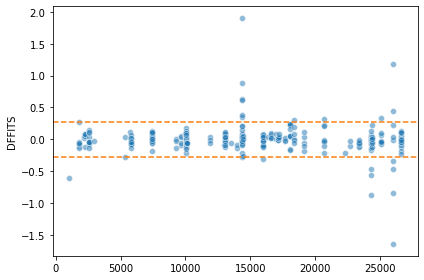

In [265]:
cutoff = 2*np.sqrt((len(predictors)+1)/len(house_98105))
sns.scatterplot(x=influence.dffits[0].index, y=influence.dffits[0].values, alpha=0.5)
plt.axhline(cutoff, linestyle='--', color='C1')
plt.axhline(-cutoff, linestyle='--', color='C1')
plt.ylabel("DFFITS")
plt.tight_layout()
plt.show()

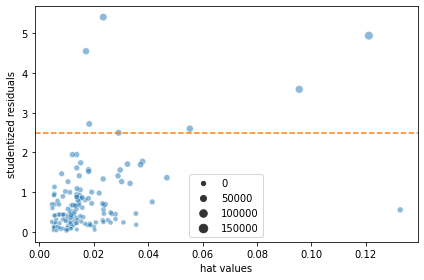

In [266]:
sns.scatterplot(x=influence.hat_matrix_diag, y=influence.resid_studentized_internal, size=100000 * np.sqrt(influence.dffits[0]), alpha=0.5)
plt.axhline(2.5, linestyle='--', color='C1')
plt.xlabel('hat values')
plt.ylabel('studentized residuals')

plt.tight_layout()
plt.show()

In [267]:
### DFFITS cutoff를 넘는 데이터 제거
mask = [abs(dist) < cutoff for dist in influence.dffits[0]]
house_infl = house_98105.loc[mask]

ols_infl = smf.ols('AdjSalePrice ~ SqFtTotLiving + SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_infl)
result_infl = ols_infl.fit()

pd.DataFrame({
    'Original': result_98105.params,
    'Influential removed': result_infl.params,
})

,Original,Influential removed
Intercept,-772549.862447,-644099.894427
SqFtTotLiving,209.602346,201.831088
SqFtLot,38.933315,42.587827
Bathrooms,2282.264145,1664.945299
Bedrooms,-26320.268796,-23734.888963
BldgGrade,130000.099737,111175.451630


##### DFBETAS
- i 번째 관측값이 각각의 회귀계수에 끼치는 영향력을 측정
- DFBETA는 모든 관측값을 고려 한 후 추정한 회귀계수와 i 번째 관측값이 제거된 이후 계산된 k 번째 회귀계수의 차이를 나타내는 통계량이고, 이를 표준화한 것이 DFBETAS
- 각 독립변수마다 값을 구할 수 있음
- 기준값은 2 또는 2/sqrt(n)

In [268]:
influence.dfbetas.T.shape

(6, 313)

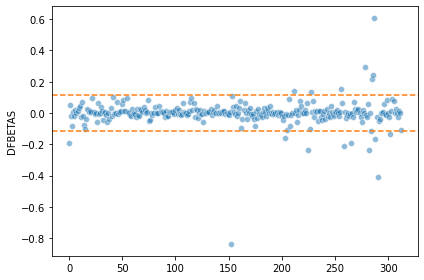

In [269]:
cutoff = 2/np.sqrt(len(house_98105))
sns.scatterplot(data=pd.Series(influence.dfbetas.T[0]), alpha=0.5) # 첫 번째 변수(SqFtTotLiving)의 DFBETAS
plt.axhline(cutoff, linestyle='--', color='C1')
plt.axhline(-cutoff, linestyle='--', color='C1')
plt.ylabel("DFBETAS")
plt.tight_layout()
plt.show()

#### Residual distrubution
- Residual plots

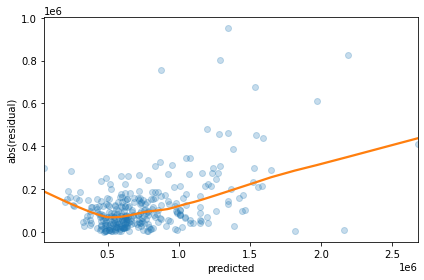

In [270]:
### 이분산 오차 확인
# 예측 값에 따른 잔차의 변화 파악
sns.regplot(x=result_98105.fittedvalues, y=np.abs(result_98105.resid), scatter_kws={'alpha': 0.25}, line_kws={'color': 'C1'}, lowess=True)
plt.xlabel('predicted')
plt.ylabel('abs(residual)')
plt.tight_layout()
plt.show()

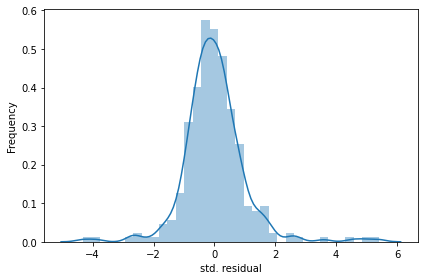

In [271]:
sns.distplot(pd.Series(influence.resid_studentized_internal)) # studentized 잔차 분포 확인
plt.xlabel('std. residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

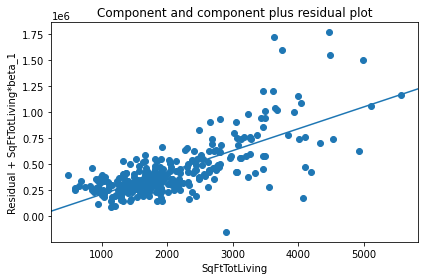

In [272]:
### Partial Residual plots
# partial residual = residual + biXi
# 예측값과 잔차 결합
# 비선형 회귀 고려
sm.graphics.plot_ccpr(result_98105, 'SqFtTotLiving')

plt.tight_layout()
plt.show()

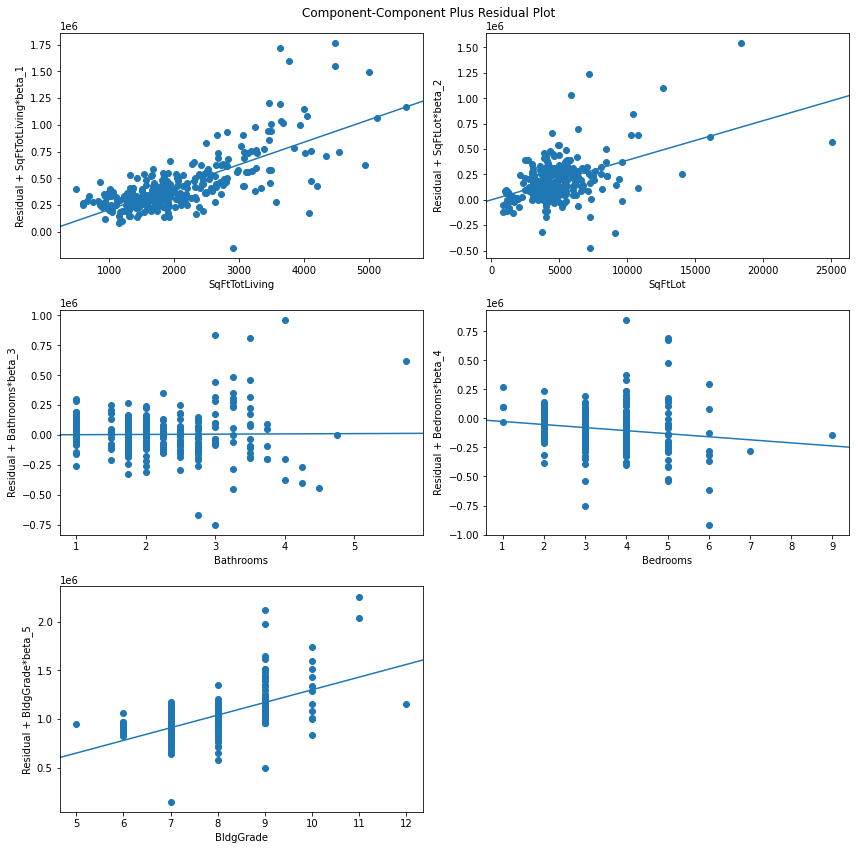

In [273]:
### 전체 Partial residual plot
fig = plt.figure(figsize=(12, 12))
sm.graphics.plot_ccpr_grid(result_98105, fig=fig)
plt.show()

eval_env: 1


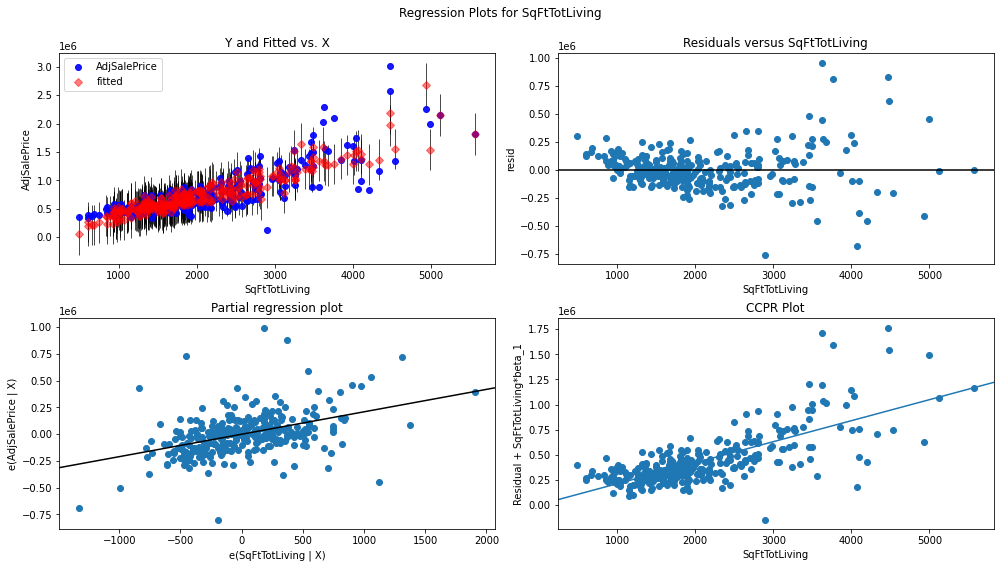

In [274]:
### Residual plot (detailed)
fig = plt.figure(figsize=(14, 8))
sm.graphics.plot_regress_exog(result_98105, 'SqFtTotLiving', fig=fig) # 변수명 또는 변수 번호 (1부터 시작) 입력
plt.show()

## Robust-linear Regression

### (1) WLS Regression
- Weighted Least Square 사용
- Outlier 영향을 덜 받으며, 오차의 등분산성이 만족되지 않을 때 보정을 위해 주로 사용

In [275]:
bp = pd.read_csv('./data/blood_pressure.csv')
bp.head()

,Age,DBP
0,27,73
1,21,66
2,22,63
3,24,75
4,25,71


In [276]:
slm = smf.ols('DBP ~ Age', data=bp).fit() ## 단순선형회귀모형 적합

### 가중치 측정
bp['Abs_Residual'] = abs(slm.resid)
std_fit = smf.ols('Abs_Residual ~ Age', data=bp).fit() ## 잔차의 절대값 ~ 연령

wls_fit = smf.wls('DBP ~ Age', data=bp, weights = 1/np.square(std_fit.fittedvalues)).fit()
wls_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                    DBP   R-squared:                       0.521
Model:                            WLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     56.64
Date:                Sun, 29 Oct 2023   Prob (F-statistic):           7.19e-10
Time:                        23:07:18   Log-Likelihood:                -181.26
No. Observations:                  54   AIC:                             366.5
Df Residuals:                      52   BIC:                             370.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     55.5658      2.521     22.042      0.000      50.507      60.624
Age            0.5963      0.079      7.526      0.000       0.437       0.755
==============================================================================
Omnibus:                        7.974   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                2.701
Skew:                           0.122   Prob(JB):                        0.259
Kurtosis:                       1.932   Cond. No.                         100.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

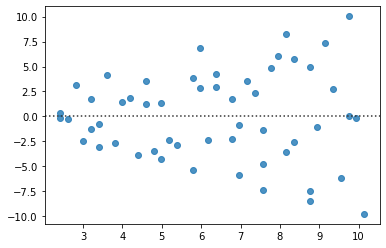

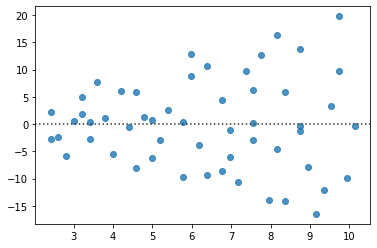

In [277]:
# 오차 경향성 완화
sns.residplot(x=std_fit.predict(bp['Age']), y=std_fit.resid)
plt.show()

sns.residplot(x=std_fit.predict(bp['Age']), y=wls_fit.resid)
plt.show()

### (2) Huber Regression
- Huber loss fuction 사용

In [278]:
boston = pd.read_csv('./data/housing.csv')
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [279]:
x = boston.drop('MEDV', axis=1)
y = boston['MEDV']

In [280]:
# The predictor variables should include a constant term.
x = sm.add_constant(x)

# Fit the robust regression model
robust_model = sm.RLM(y, x, M=sm.robust.norms.HuberT())
robust_results = robust_model.fit()
robust_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                   MEDV   No. Observations:                  506
Model:                            RLM   Df Residuals:                      492
Method:                          IRLS   Df Model:                           13
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 29 Oct 2023                                         
Time:                        23:07:18                                         
No. Iterations:                    30                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.9275      3.744      5.056      0.000      11.590      26.265
CRIM          -0.1058      0.024     -4.390      0.000      -0.153      -0.059
ZN             0.0352      0.010      3.496      0.000       0.015       0.055
INDUS      -3.553e-05      0.045     -0.001      0.999      -0.088       0.088
CHAS           1.6097      0.632      2.547      0.011       0.371       2.848
NOX          -10.3676      2.802     -3.700      0.000     -15.860      -4.876
RM             5.0559      0.307     16.491      0.000       4.455       5.657
AGE           -0.0234      0.010     -2.412      0.016      -0.042      -0.004
DIS           -1.1057      0.146     -7.557      0.000      -1.392      -0.819
RAD            0.1957      0.049      4.021      0.000       0.100       0.291
TAX           -0.0112      0.003     -4.058      0.000      -0.017      -0.006
PTRATIO       -0.7722      0.096     -8.046      0.000      -0.960      -0.584
B              0.0110      0.002      5.585      0.000       0.007       0.015
LSTAT         -0.3418      0.037     -9.187      0.000      -0.415      -0.269
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

### (5) Quantile Regression
- 조건부 분위수를 모델링
- 선형 회귀 조건이 충족되지 않을 때 사용되는 선형 회귀의 비모수적 방법
- 이상치가 많아 이에 대한 영향을 줄인 선형 회귀선을 구할 수 있고, 이분산 데이터 모델링도 가능
- 점 추정이 아닌 구간추정을 통해 결과의 정확도를 높일 수 있음

In [281]:
diabetes = load_diabetes()
x = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = diabetes.target

q_df = x.copy()
q_df['y'] = pd.Series(y)

In [282]:
qs = [0.1, 0.25, 0.5, 0.75, 0.9]
intercepts = []
slopes = []
pred_dict = dict()
for q in qs:
    quantile_reg = smf.quantreg('y ~ ' + (' + '.join(list(x.columns))), q_df).fit(q=q)
    pred_dict[q] = quantile_reg.predict(x)
    
pred_df = pd.concat([pd.DataFrame(pred_dict).reset_index(drop=True), q_df['y'].reset_index(drop=True)], axis=1)
pred_df.head()

,0.1,0.25,0.5,0.75,0.9,y
0,114.389089,160.512754,203.995040,250.617046,286.236587,151.0
1,33.529759,54.411765,74.999999,79.408675,114.958581,75.0
2,104.742620,141.000000,174.844178,208.955978,247.041323,141.0
3,75.182544,116.052301,165.542551,218.154601,249.463834,206.0
4,54.849095,91.124629,135.293448,157.830135,199.391970,135.0


In [283]:
### 0.5 quantile regression summary
quantile_reg = smf.quantreg('y ~ ' + (' + '.join(list(x.columns))), q_df).fit(q=0.5)
quantile_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                      y   Pseudo R-squared:               0.3383
Model:                       QuantReg   Bandwidth:                       34.91
Method:                 Least Squares   Sparsity:                        140.3
Date:                Sun, 29 Oct 2023   No. Observations:                  442
Time:                        23:07:18   Df Residuals:                      431
                                        Df Model:                           10
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    151.8520      3.336     45.517      0.000     145.295     158.409
age            9.3919     77.386      0.121      0.903    -142.709     161.493
sex         -326.3453     79.294     -4.116      0.000    -482.196    -170.494
bmi          465.8559     86.173      5.406      0.000     296.484     635.228
bp           407.0552     84.733      4.804      0.000     240.513     573.597
s1          -856.7186    539.681     -1.587      0.113   -1917.453     204.016
s2           414.4578    439.111      0.944      0.346    -448.608    1277.524
s3           147.1359    275.268      0.535      0.593    -393.899     688.171
s4           257.9128    209.140      1.233      0.218    -153.149     668.975
s5           762.2344    222.644      3.424      0.001     324.631    1199.838
s6            50.7769     85.462      0.594      0.553    -117.196     218.750
==============================================================================
"""

In [284]:
### Least Absoloue Deviations (LAD) Regression

In [285]:
### Iteratively Reweighted Least Squares (IRLS) Regression

In [286]:
### Least Median of Squares (LMS) Regression 

## Non-linear Regression

### (1) Polymonial Regression
- 다항 함수 추가

In [287]:
df = pd.DataFrame({'x': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'y': [5, 3, 2, 3, 4, 6, 10, 12, 18]})
df

,x,y
0,1,5
1,2,3
2,3,2
3,4,3
4,5,4
5,6,6
6,7,10
7,8,12
8,9,18


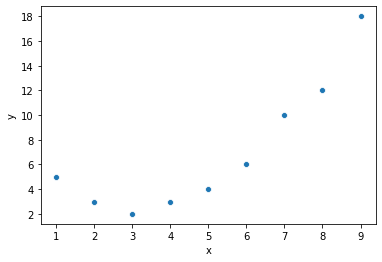

In [288]:
x = df['x']
y = df['y']

sns.scatterplot(x=x, y=y)
plt.show()

In [289]:
model = smf.ols(formula="y ~ x", data=df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     16.99
Date:                Sun, 29 Oct 2023   Prob (F-statistic):            0.00445
Time:                        23:07:19   Log-Likelihood:                -21.732
No. Observations:                   9   AIC:                             47.46
Df Residuals:                       7   BIC:                             47.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1667      2.230     -0.523      0.617      -6.439       4.106
x              1.6333      0.396      4.122      0.004       0.696       2.570
==============================================================================
Omnibus:                        1.451   Durbin-Watson:                   0.696
Prob(Omnibus):                  0.484   Jarque-Bera (JB):                1.008
Skew:                           0.668   Prob(JB):                        0.604
Kurtosis:                       2.051   Cond. No.                         12.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

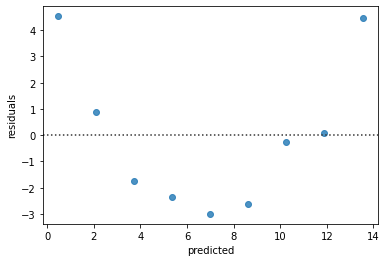

In [290]:
### Manual residual plot
# create a DataFrame of predicted values and residuals
plot_df = pd.DataFrame()
plot_df["predicted"] = result.predict(x)
plot_df["residuals"] = result.resid

sns.residplot(data=plot_df, x="predicted", y="residuals") # 2차식이 필요해 보인다.
plt.show()

In [291]:
x_sq = x**2
df['x_sq'] = x_sq

In [292]:
model = smf.ols(formula="y ~ x + x_sq", data=df)
result = model.fit()

y_pred = result.predict(x)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     292.2
Date:                Sun, 29 Oct 2023   Prob (F-statistic):           1.05e-06
Time:                        23:07:19   Log-Likelihood:                -6.6251
No. Observations:                   9   AIC:                             19.25
Df Residuals:                       6   BIC:                             19.84
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.1667      0.787      9.103      0.000       5.240       9.093
x             -2.9121      0.361     -8.056      0.000      -3.797      -2.028
x_sq           0.4545      0.035     12.893      0.000       0.368       0.541
==============================================================================
Omnibus:                        0.843   Durbin-Watson:                   3.026
Prob(Omnibus):                  0.656   Jarque-Bera (JB):                0.023
Skew:                          -0.122   Prob(JB):                        0.989
Kurtosis:                       2.962   Cond. No.                         173.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

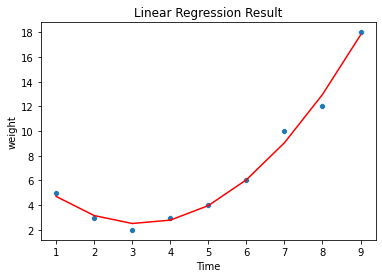

In [293]:
sns.scatterplot(x=x, y=y)
plt.plot(x, y_pred, color='red') ## 회귀직선 추가 
plt.xlabel('Time', fontsize=10)
plt.ylabel('weight',fontsize=10)
plt.title('Linear Regression Result')
plt.show()

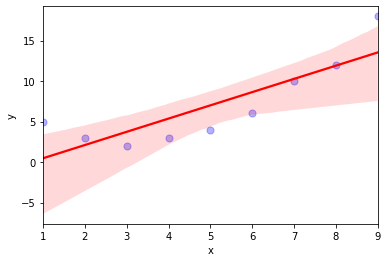

In [294]:
sns.regplot(x=x, y=y, scatter_kws={"fc":"b", "ec":"b", "s":50, "alpha":0.3}, color="r") # regplot으로 한줄 실행
plt.show()

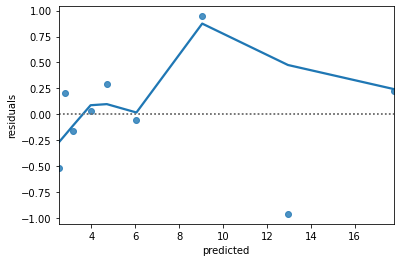

In [295]:
### Manual residual plot
# create a DataFrame of predicted values and residuals
plot_df = pd.DataFrame()
plot_df["predicted"] = result.predict(x)
plot_df["residuals"] = result.resid

sns.residplot(data=plot_df, x="predicted", y="residuals", lowess=True)
plt.axhline(y=0, color='gray', linestyle='dotted')
plt.show()

In [296]:
### house data before
# 2차항 추가
model_poly = smf.ols(formula='AdjSalePrice ~ SqFtTotLiving + np.power(SqFtTotLiving, 2) + SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_98105)
result_poly = model_poly.fit()
result_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     211.6
Date:                Sun, 29 Oct 2023   Prob (F-statistic):          9.95e-106
Time:                        23:07:19   Log-Likelihood:                -4217.9
No. Observations:                 313   AIC:                             8450.
Df Residuals:                     306   BIC:                             8476.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                  -6.159e+05   1.03e+05     -5.953      0.000   -8.19e+05   -4.12e+05
SqFtTotLiving                  7.4521     55.418      0.134      0.893    -101.597     116.501
np.power(SqFtTotLiving, 2)     0.0388      0.010      4.040      0.000       0.020       0.058
SqFtLot                       32.5594      5.436      5.990      0.000      21.863      43.256
Bathrooms                  -1435.1231   1.95e+04     -0.074      0.941   -3.99e+04     3.7e+04
Bedrooms                   -9191.9441   1.33e+04     -0.693      0.489   -3.53e+04    1.69e+04
BldgGrade                   1.357e+05   1.49e+04      9.087      0.000    1.06e+05    1.65e+05
==============================================================================
Omnibus:                       75.161   Durbin-Watson:                   1.625
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              637.978
Skew:                           0.699   Prob(JB):                    2.92e-139
Kurtosis:                       9.853   Cond. No.                     7.37e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.37e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

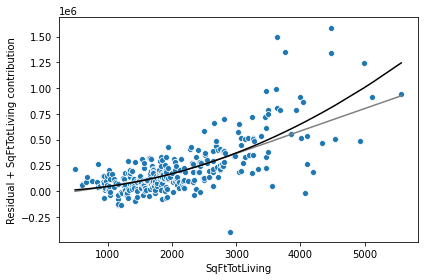

0.03879128168230191


In [297]:
def partialResidualPlot(model, df, outcome, feature):
    y_pred = model.predict(df)
    copy_df = df.copy()
    for c in copy_df.columns:
        if c == feature:
            continue
        copy_df[c] = 0.0
    feature_prediction = model.predict(copy_df)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': df[outcome] - y_pred,
        'ypartial': feature_prediction - model.params[0],
    })
    results = results.sort_values(by=['feature'])
    smoothed = sm.nonparametric.lowess(results.ypartial, results.feature, frac=1/3)
    
    sns.scatterplot(x=results.feature, y = results.ypartial + results.residual)
    sns.lineplot(x=smoothed[:, 0], y=smoothed[:, 1], color='gray') # spline line
    sns.lineplot(x=results.feature, y=results.ypartial, color='black')
    plt.xlabel(feature)
    plt.ylabel(f'Residual + {feature} contribution')

partialResidualPlot(result_poly, house_98105, 'AdjSalePrice', 'SqFtTotLiving')

plt.tight_layout()
plt.show()
print(result_poly.params[2])

### (2) Spline Regression
- 다항 구간들을 부드러운 곡선 형태로 적합
- Knot: Spline 구간을 구분하는 값

In [298]:
### house data - continued
model_spline = smf.ols(formula='AdjSalePrice ~ bs(SqFtTotLiving, df=6, degree=3) + SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_98105) # b-spline added
result_spline = model_spline.fit()
result_spline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     131.8
Date:                Sun, 29 Oct 2023   Prob (F-statistic):          7.10e-104
Time:                        23:07:20   Log-Likelihood:                -4211.4
No. Observations:                 313   AIC:                             8445.
Df Residuals:                     302   BIC:                             8486.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                            -4.142e+05   1.43e+05     -2.899      0.004   -6.95e+05   -1.33e+05
bs(SqFtTotLiving, df=6, degree=3)[0] -1.995e+05   1.86e+05     -1.076      0.283   -5.65e+05    1.66e+05
bs(SqFtTotLiving, df=6, degree=3)[1] -1.206e+05   1.23e+05     -0.983      0.326   -3.62e+05    1.21e+05
bs(SqFtTotLiving, df=6, degree=3)[2] -7.164e+04   1.36e+05     -0.525      0.600    -3.4e+05    1.97e+05
bs(SqFtTotLiving, df=6, degree=3)[3]  1.957e+05   1.62e+05      1.212      0.227   -1.22e+05    5.14e+05
bs(SqFtTotLiving, df=6, degree=3)[4]  8.452e+05   2.18e+05      3.878      0.000    4.16e+05    1.27e+06
bs(SqFtTotLiving, df=6, degree=3)[5]  6.955e+05   2.14e+05      3.255      0.001    2.75e+05    1.12e+06
SqFtLot                                 33.3258      5.454      6.110      0.000      22.592      44.059
Bathrooms                            -4778.2080   1.94e+04     -0.246      0.806    -4.3e+04    3.34e+04
Bedrooms                             -5778.7045   1.32e+04     -0.437      0.663   -3.18e+04    2.03e+04
BldgGrade                             1.345e+05   1.52e+04      8.842      0.000    1.05e+05    1.64e+05
==============================================================================
Omnibus:                       58.816   Durbin-Watson:                   1.633
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              622.021
Skew:                           0.330   Prob(JB):                    8.51e-136
Kurtosis:                       9.874   Cond. No.                     1.97e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

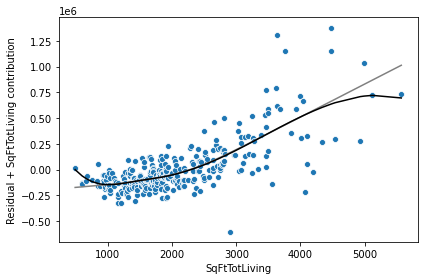

In [299]:
partialResidualPlot(result_spline, house_98105, 'AdjSalePrice', 'SqFtTotLiving')
plt.tight_layout()
plt.show()

In [300]:
from statsmodels.gam.api import GLMGam, BSplines

In [301]:
### Generalized Additive Models
# Spline 회귀를 찾는 데 사용가능
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

x_spline = house_98105[predictors]
bs = BSplines(x_spline, df=[10] + [3] * 4, degree=[3] + [2] * 4)

# penalization weight
alpha = np.array([0] * 5)

formula = 'AdjSalePrice ~ SqFtTotLiving + SqFtLot + Bathrooms + Bedrooms + BldgGrade'
gam_sm = GLMGam.from_formula(formula, data=house_98105, smoother=bs, alpha=alpha)
res_sm = gam_sm.fit()
print(res_sm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           AdjSalePrice   No. Observations:                  313
Model:                         GLMGam   Df Residuals:                   295.00
Model Family:                Gaussian   Df Model:                        17.00
Link Function:               identity   Scale:                      2.7471e+10
Method:                         PIRLS   Log-Likelihood:                -4196.6
Date:                Sun, 29 Oct 2023   Deviance:                   8.1039e+12
Time:                        23:07:22   Pearson chi2:                 8.10e+12
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9901
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -3.481e+05   1.18e+05  

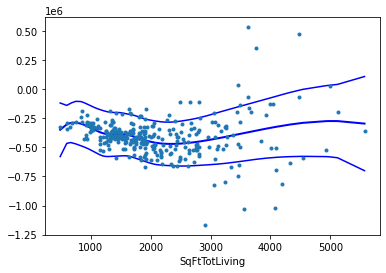

In [302]:
res_sm.plot_partial(0, cpr=True);

### (3) Logistic Regression
- Statistics version
- 잔차 분석은 수행하지 않아도 됨

In [303]:
test_result = pd.read_csv("./stats_for_python/6-3-1-logistic-regression.csv")
test_result.head(3)

,hours,result
0,0,0
1,0,0
2,0,0


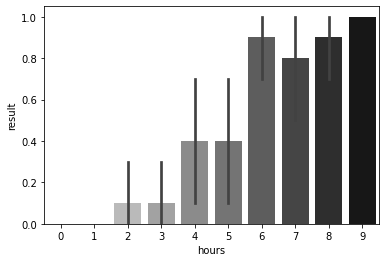

In [304]:
# 공부시간 별 시험 합격률
sns.barplot(x="hours", y="result", data=test_result, palette='gray_r')
plt.show()

In [305]:
# 공부 시간 당 합격률
test_result.groupby("hours").mean()

,result
hours,
0,0.0
1,0.0
2,0.1
3,0.1
4,0.4
5,0.4
6,0.9
7,0.8
8,0.9


In [306]:
# Modeling
mod_glm = smf.glm(formula = "result ~ hours", data=test_result, family=sm.families.Binomial()).fit()
mod_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 result   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -34.014
Date:                Sun, 29 Oct 2023   Deviance:                       68.028
Time:                        23:07:22   Pearson chi2:                     84.9
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5032
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.5587      0.901     -5.061      0.000      -6.324      -2.793
hours          0.9289      0.174      5.345      0.000       0.588       1.270
==============================================================================
"""

In [307]:
### Null과 AIC 비교
# Null Model
mod_glm_null = smf.glm("result ~ 1", data=test_result, family=sm.families.Binomial()).fit()
print("Null 모델:", mod_glm_null.aic.round(3))
print("변수가 있는 모델:", mod_glm.aic.round(3))

Null 모델: 139.989
변수가 있는 모델: 72.028


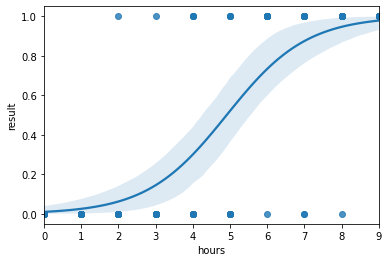

In [308]:
# plot logistic regression curve
sns.regplot(x='hours', y='result', data=test_result, logistic=True, ci=95)
plt.show()

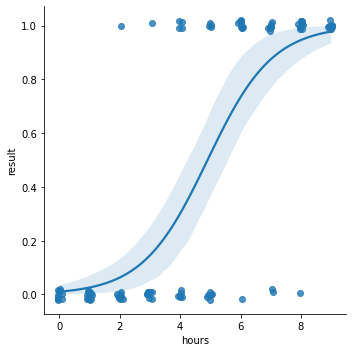

In [309]:
# lmplot 회귀 곡선
sns.lmplot(x="hours", y="result", data=test_result, logistic=True, x_jitter=0.1, y_jitter=0.02)
plt.show()

In [310]:
# 합격 확률 예측
pred = mod_glm.predict(pd.DataFrame({"hours": np.arange(0, 10, 1)}))
pred

0    0.010367
1    0.025836
2    0.062920
3    0.145291
4    0.300876
5    0.521427
6    0.733929
7    0.874741
8    0.946467
9    0.978147
dtype: float64

In [311]:
### Odds ratio 계산
# 공부시간 1시간일 때의 합격률
exp_val_1 = pd.DataFrame({"hours": [1]})
pred_1 = mod_glm.predict(exp_val_1)

# 공부시간 2시간일 때의 합격률
exp_val_2 = pd.DataFrame({"hours": [2]})
pred_2 = mod_glm.predict(exp_val_2)

# Odds
odds_1 = pred_1 / (1 - pred_1)
odds_2 = pred_2 / (1 - pred_2)

# Log Odds ratio -> Parameter
np.log(odds_2 / odds_1)

0    0.92889
dtype: float64

In [312]:
mod_glm.params["hours"]

0.9288901756284967

In [313]:
### Pearson Residual
mod_glm.resid_pearson.head(3)

0   -0.102351
1   -0.102351
2   -0.102351
dtype: float64

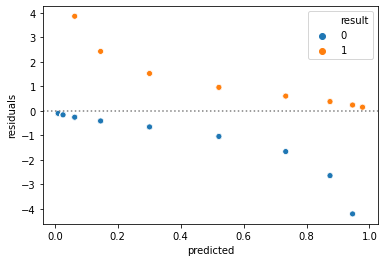

In [314]:
plot_df = pd.DataFrame()
plot_df["predicted"] = mod_glm.predict(test_result['hours'])
plot_df["residuals"] = mod_glm.resid_pearson

sns.scatterplot(data=plot_df, x="predicted", y="residuals", hue=test_result['result'])
plt.axhline(y=0, color='gray', linestyle='dotted')
plt.show()

In [315]:
### Pearson chi-square statistic
mod_glm.pearson_chi2

84.91138782569999

In [316]:
np.sum(mod_glm.resid_pearson**2)

84.91138782569999

In [317]:
### Deviance Residual
mod_glm.resid_deviance.head(3)

0   -0.144369
1   -0.144369
2   -0.144369
dtype: float64

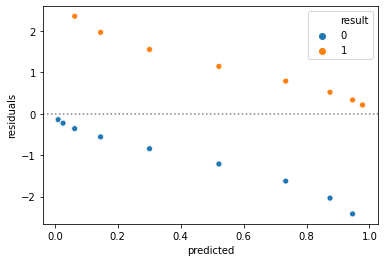

In [318]:
plot_df["residuals"] = mod_glm.resid_deviance

sns.scatterplot(data=plot_df, x="predicted", y="residuals", hue=test_result['result'])
plt.axhline(y=0, color='gray', linestyle='dotted')
plt.show()

In [319]:
### Deviance statistic
# summary의 Deviance 값과 일치
# logistic에서는 cross-entropy 개념과 동일
np.sum(mod_glm.resid_deviance ** 2)

68.02788118117269

In [320]:
### Logit function 이용한 분석
logit = sm.Logit(test_result['result'], test_result['hours']).fit()
logit.summary2()

Optimization terminated successfully.
         Current function value: 0.636798
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Logit
===============================================================
Model:              Logit            Pseudo R-squared: 0.077   
Dependent Variable: result           AIC:              129.3595
Date:               2023-10-29 23:07 BIC:              131.9647
No. Observations:   100              Log-Likelihood:   -63.680 
Df Model:           0                LL-Null:          -68.994 
Df Residuals:       99               LLR p-value:      nan     
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     5.0000                                     
-----------------------------------------------------------------
            Coef.    Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
hours       0.1330     0.0419   3.1756   0.0015   0.0509   0.2151
===============================================================

"""

In [321]:
### Odds ratio
np.exp(logit.params)

hours    1.142245
dtype: float64

In [322]:
### Multiple Logistic - Cars data
mtcars.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,mpg_sqrt
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4,4.582576
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4,4.582576
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1,4.774935
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1,4.626013
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2,4.324350


In [323]:
model = smf.glm(formula="vs ~ mpg + am", data=mtcars, family=sm.families.Binomial())
results = model.fit()

print(results.summary()) # coef에 대해서는 wald test 결과를 보여줌

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     vs   No. Observations:                   32
Model:                            GLM   Df Residuals:                       29
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10.323
Date:                Sun, 29 Oct 2023   Deviance:                       20.646
Time:                        23:07:25   Pearson chi2:                     20.2
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5159
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.7051      4.625     -2.747      0.0

In [324]:
results.aic

26.64629286928622

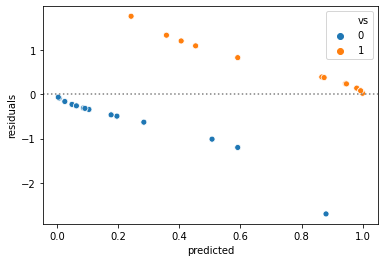

In [325]:
plot_df = pd.DataFrame()
plot_df["predicted"] = results.predict(mtcars.loc[:, ['mpg', 'am']])
plot_df["residuals"] = results.resid_pearson

sns.scatterplot(data=plot_df, x="predicted", y="residuals", hue=mtcars['vs'])
plt.axhline(y=0, color='gray', linestyle='dotted')
plt.show()

In [326]:
results.cov_params()

,Intercept,mpg,am
Intercept,21.392589,-1.155050,4.406337
mpg,-1.155050,0.063693,-0.267584
am,4.406337,-0.267584,2.558336


### (4) Poisson Regression
- Statistics version
- 연속형 변수가 카운트(개수, 빈도) 변수에 미치는 영향 파악
- Pearson chi-sq, deviance 통계량 검정에서 귀무가설을 기각하지 않으면 모델이 유의함 (H0: 회귀모델이 유효하다)

In [327]:
# 맥주 판매 개수 예측
beer = pd.read_csv("./stats_for_python/6-5-1-poisson-regression.csv")
beer.head(3)

,beer_number,temperature
0,6,17.5
1,11,26.6
2,2,5.0


In [328]:
# Modeling
mod_pois = smf.glm("beer_number ~ temperature", beer, family=sm.families.Poisson()).fit()
mod_pois.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            beer_number   No. Observations:                   30
Model:                            GLM   Df Residuals:                       28
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -57.672
Date:                Sun, 29 Oct 2023   Deviance:                       5.1373
Time:                        23:07:25   Pearson chi2:                     5.40
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9708
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.4476      0.199      2.253      0.024       0.058       0.837
temperature     0.0761      0.008      9.784      0.000       0.061       0.091
===============================================================================
"""

In [329]:
### Pearson chi-sq test
pstats = ((beer['beer_number'] - mod_pois.fittedvalues)**2/mod_pois.fittedvalues).sum()
pval = 1 - stats.chi2.cdf(pstats, mod_pois.df_resid)
print('pstats:', pstats, ", p-value:", pval)

pstats: 5.4047036003047575 , p-value: 0.9999989639266061


In [330]:
### Deviance test
dstats = (np.log(beer['beer_number']/mod_pois.fittedvalues)*beer['beer_number']).sum()*2 - (beer['beer_number'] - mod_pois.fittedvalues).sum()*2
pval = (1 - stats.chi2.cdf(dstats, mod_pois.df_resid))**2
print('dstats:', dstats, ", p-value:", pval)

dstats: 5.1372626625991495 , p-value: 0.999998848203124


In [331]:
stats.chi2.cdf(pstats, mod_pois.df_resid)

1.036073393842833e-06

In [332]:
### Null과 AIC 비교
# Null Model
mod_pois_null = smf.glm("beer_number ~ 1", data=beer, family=sm.families.Poisson()).fit()
print("Null 모델:", mod_pois_null.aic.round(3))
print("변수가 있는 모델:", mod_pois.aic.round(3))

Null 모델: 223.363
변수가 있는 모델: 119.343


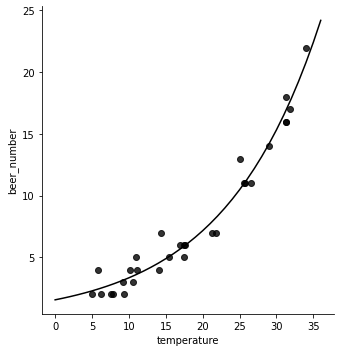

In [333]:
x_plot = np.arange(0, 37)
pred = mod_pois.predict(pd.DataFrame({"temperature": x_plot}))

sns.lmplot(y="beer_number", x="temperature", data=beer, fit_reg = False,
          scatter_kws = {"color":"black"})
sns.lineplot(x=x_plot, y=pred, color="black")
plt.show()

In [334]:
# 기온이 1도일 때 판매 개수 기댓값
exp_val_1 = pd.DataFrame({"temperature": [1]})
pred_1 = mod_pois.predict(exp_val_1)

# 기온이 2도일 때 판매 개수 기댓값
exp_val_2 = pd.DataFrame({"temperature": [2]})
pred_2 = mod_pois.predict(exp_val_2)

# 비율 확인
pred_2 / pred_1

0    1.079045
dtype: float64

In [335]:
np.exp(mod_pois.params["temperature"])

1.079045054586893

### (5) Probit Regression
- Dose-Response analysis
- 정규분포 누적확률변수를 이용한 이진 분류
- 이진 변수 y는 베르누이 분포를 따른다고 가정

In [336]:
hmda = pd.read_csv("./r_csv/AER/HMDA.csv", index_col="Unnamed: 0")
hmda.head()

,deny,pirat,hirat,lvrat,chist,mhist,phist,unemp,selfemp,insurance,condomin,afam,single,hschool
1,no,0.221,0.221,0.800000,5,2,no,3.9,no,no,no,no,no,yes
2,no,0.265,0.265,0.921875,2,2,no,3.2,no,no,no,no,yes,yes
3,no,0.372,0.248,0.920398,1,2,no,3.2,no,no,no,no,no,yes
4,no,0.320,0.250,0.860465,1,2,no,4.3,no,no,no,no,no,yes
5,no,0.360,0.350,0.600000,1,1,no,3.2,no,no,no,no,no,yes


In [337]:
hmda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2380 entries, 1 to 2380
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   deny       2380 non-null   object 
 1   pirat      2380 non-null   float64
 2   hirat      2380 non-null   float64
 3   lvrat      2380 non-null   float64
 4   chist      2380 non-null   int64  
 5   mhist      2380 non-null   int64  
 6   phist      2380 non-null   object 
 7   unemp      2380 non-null   float64
 8   selfemp    2380 non-null   object 
 9   insurance  2380 non-null   object 
 10  condomin   2380 non-null   object 
 11  afam       2380 non-null   object 
 12  single     2380 non-null   object 
 13  hschool    2380 non-null   object 
dtypes: float64(4), int64(2), object(8)
memory usage: 278.9+ KB


In [338]:
hmda["deny_binary"] = hmda["deny"].apply(lambda x: 1 if x=="yes" else 0)

In [339]:
from statsmodels.discrete.discrete_model import Probit

In [340]:
x = hmda["pirat"]
x = sm.add_constant(x)
y = hmda["deny_binary"]

probit = Probit(y, x).fit()
probit.summary()

Optimization terminated successfully.
         Current function value: 0.349493
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:            deny_binary   No. Observations:                 2380
Model:                         Probit   Df Residuals:                     2378
Method:                           MLE   Df Model:                            1
Date:                Sun, 29 Oct 2023   Pseudo R-squ.:                 0.04620
Time:                        23:07:25   Log-Likelihood:                -831.79
converged:                       True   LL-Null:                       -872.09
Covariance Type:            nonrobust   LLR p-value:                 2.783e-19
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1942      0.129    -17.010      0.000      -2.447      -1.941
pirat          2.9679      0.359      8.265      0.000       2.264       3.672
==============================================================================
"""

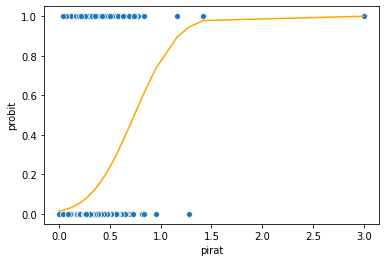

In [341]:
## 시각화
hmda["probit"]= probit.predict(x)

plt.xlabel("pirat")
plt.ylabel("deny")
sns.scatterplot(x=hmda["pirat"], y=hmda["deny_binary"])
sns.lineplot(data=hmda, x="pirat", y="probit", color='orange')
plt.show()

In [342]:
## new_data
pirat = np.array([0.3, 0.4])
const = np.array([1, 1])

x_new = pd.DataFrame([const, pirat]).T
x_new.columns = ["const", "pirat"]
probit.predict(x_new).diff()[1] ### 0.3 -> 0.4로 갈 때의 deny 확률 변화

0.060815194105097836

In [343]:
### Race의 deny 영향도
hmda["black"] = hmda["afam"].apply(lambda x :1 if x=="yes" else 0)

x2 = hmda[["pirat", "black"]]
x2 = sm.add_constant(x2)

probit2 = Probit(y, x2).fit()
probit2.summary()

Optimization terminated successfully.
         Current function value: 0.334931
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:            deny_binary   No. Observations:                 2380
Model:                         Probit   Df Residuals:                     2377
Method:                           MLE   Df Model:                            2
Date:                Sun, 29 Oct 2023   Pseudo R-squ.:                 0.08594
Time:                        23:07:27   Log-Likelihood:                -797.14
converged:                       True   LL-Null:                       -872.09
Covariance Type:            nonrobust   LLR p-value:                 2.818e-33
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2587      0.130    -17.391      0.000      -2.513      -2.004
pirat          2.7416      0.360      7.624      0.000       2.037       3.446
black          0.7082      0.083      8.488      0.000       0.545       0.872
==============================================================================
"""

In [344]:
## new_data
black =np.array([0, 1])
pirat =np.array([0.3, 0.3])
const = np.array([1, 1])

x_new = pd.DataFrame([const, pirat, black]).T
x_new.columns = ["const", "pirat", "black"]
probit2.predict(x_new).diff()[1] ### black 여부에 따른 확률 변화

0.15781349122942923

### (6) Isotonic Regression
- x가 커질 때 y도 같이 커지는(monotonous increase) 경우

In [345]:
n = 20
x = np.arange(n)
print('Input:\n',x)
y = np.random.randint(0, 20, size=n) + 10 * np.log1p(np.arange(n))
print("Target :\n",y)

Input:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Target :
 [ 8.         21.93147181 20.98612289 27.86294361 26.09437912 24.91759469
 36.45910149 30.79441542 35.97224577 34.02585093 24.97895273 42.8490665
 44.64949357 33.3905733  35.08050201 41.72588722 38.33213344 47.90371758
 29.44438979 32.95732274]


In [346]:
from sklearn.isotonic import IsotonicRegression

In [347]:
ir = IsotonicRegression() 
  
# Fit isotonic regression model
y_ir = ir.fit_transform(x, y) # fit the model and transform the data
print('Isotonic Regression Predictions  :\n', y_ir)

Isotonic Regression Predictions  :
 [ 8.         21.45879735 21.45879735 26.29163914 26.29163914 26.29163914
 32.44611327 32.44611327 32.44611327 32.44611327 32.44611327 38.48145402
 38.48145402 38.48145402 38.48145402 38.48145402 38.48145402 38.48145402
 38.48145402 38.48145402]


In [348]:
from matplotlib.collections import LineCollection

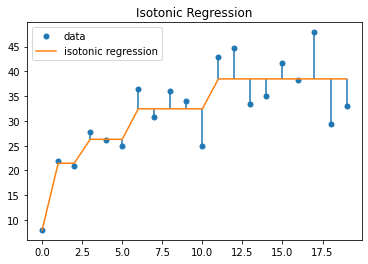

In [349]:
lines=[[[i,y[i]],[i,y_ir[i]]] for i in range(n)]
  
# Line to measure the difference between actual and target value
lc=LineCollection(lines)
  
# plt.figure(figsize=(10,4))
plt.plot(x, y, '.', markersize=10, label='data')
plt.plot(x, y_ir, '-', markersize=10,label='isotonic regression' )
  
plt.gca().add_collection(lc)
plt.legend() # add a legend
  
plt.title("Isotonic Regression")
plt.show()

### (7) Bayesian Regression
- Likeilhood (관측값에서 모델이 가지는 가능도)를 최소화하는 회귀식 도출
- MCMC (Markov Chain Monte Carlo): Markov Chain을 이용하는 표본 생성 방법
    - 어떤 상태가 끊임없이 움직이고 있는 체인 상태의 샘플링
    - Markov Chain인의 수렴분포가 원하는 분포 𝑝(𝑥)가 되도록 하는 마코프 체인을 만들고 이 마코프 체인을 𝑡′시간 이상 가동하면 그 다음부터는 원하는 분포의 표본을 얻을 수 있음
    - Metropolis-Hastings(MH) 알고리즘
        - 사전분포를 제안하고, 현재 샘플링 파라미터 θt가 다음 샘플 θnew 로 전이될 확률을 사후확률의 비로 결정
    - 수행 단계
        - 현재 위치에서 시작한다
        - 새로 이동할 위치를 조사한다 → 주변의 sample을 조사
        - 데이터와 사전확률분포에 따른 위치를 바탕으로 새로운 위치를 수용하거나 기각한다 → sample이 해당 사후확률분포에서 나올 가능성을 조사
        - 수용한다면 새로운 위치로 이동하고 1단계로 돌아간다.

#### PyStan

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/ADPclass/ADP_book_ver01/main/data/26_problem7.csv")
df.head()

In [ ]:
import pystan

In [12]:
X1 = df['height']
X2 = df['waistline']
Y = df['weight']

data = {'N' : len(df), 'x1': X1, 'x2': X2, 'Y': Y}

# Stan 코드
model_code = """
data {
  int<lower=0> N;
  vector[N] x1;
  vector[N] x2;
  vector[N] Y;
}

parameters {
  real a;
  real b1;
  real b2;
  real<lower=0> sigma;
}

model {
  Y ~ normal(a + b1 * x1 + b2 * x2, sigma);
  a ~ normal(0, 1000);
  b1 ~ normal(0, 1000);
  b2 ~ normal(0, 1000);
  sigma ~ gamma(0.005, 0.005);
}
"""

model = pystan.StanModel(model_code=model_code,verbose=True,)
fit = model.sampling(data=data, iter=10000, warmup=1000, chains=1, seed=1234)
fit.summary

<bound method StanFit4Model.summary of Inference for Stan model: anon_model_20749f6857fc9ffcabb643021d4bad8f.
1 chains, each with iter=10000; warmup=1000; thin=1; 
post-warmup draws per chain=9000, total post-warmup draws=9000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a     -124.5    1.08  30.21 -183.7 -144.7 -124.1 -104.5 -66.41    776    1.0
b1      1.04  1.8e-3   0.06   0.92    1.0   1.04   1.08   1.15   1123    1.0
b2      0.22    0.02   0.46  -0.65  -0.08   0.22   0.52   1.14    723    1.0
sigma   1.69  1.2e-3   0.06   1.58   1.65   1.68   1.73   1.81   2422    1.0
lp__  -420.3    0.03   1.44 -423.9 -421.0 -420.0 -419.2 -418.5   1976    1.0

Samples were drawn using NUTS at Mon Aug 28 03:32:59 2023.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).>

In [32]:
b1 = round(fit['b1'].mean(), 2)
b2 = round(fit['b2'].mean(), 2)
a = round(fit['a'].mean(), 2)

<Axes: xlabel='waistline', ylabel='pred'>

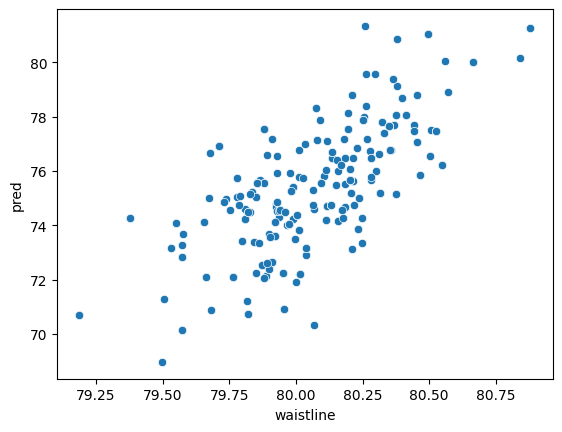

In [43]:
df['pred'] = df['height'] * b1 + df['waistline'] * b2  + a
sns.scatterplot(x=df['waistline'],y=df['pred'])

In [44]:
result = 180 * b1 + 85 * b2 + a
round(result, 2)

81.34


#### ARDRegression
- Automatic Relevance Determination Regression (ARD)
- Lasso Regression의 Bayesian 버전

In [350]:
from sklearn.linear_model import ARDRegression

In [351]:
data = pd.read_csv("https://raw.githubusercontent.com/ADPclass/ADP_book_ver01/main/data/26_problem7.csv")

In [352]:
x = data[["height", "weight"]]
y = data["waistline"]

In [353]:
# 1000번의 burn-in 이후 10,000의 MCMC를 수행
# 회귀계수의 사전분포는 부적절한 균일분포(inproper uniform prior distribution),
# 오차항의 분산의 사전분포는 역감마 분포로 지정. 형상(Shape)모수와 척도(Scale)모수는 각각 0.005로 지정.
ard = ARDRegression(threshold_lambda=10000, alpha_2=0.005, lambda_2=0.005, fit_intercept=False) ## 부적절한 균일분포, inverse gamma를 0.005로 지정
ard.fit(x, y)

ARDRegression(alpha_2=0.005, fit_intercept=False, lambda_2=0.005,
              threshold_lambda=10000)

In [354]:
ard.coef_

array([ 0.54450434, -0.20484747])

In [355]:
ard.predict([[180, 85]])

array([80.59874677])

#### BayesianRidge

In [356]:
from sklearn.linear_model import BayesianRidge

In [357]:
# 1000번의 burn-in 이후 10,000의 MCMC를 수행
# 회귀계수의 사전분포는 부적절한 균일분포(inproper uniform prior distribution),
# 오차항의 분산의 사전분포는 역감마 분포로 지정. 형상(Shape)모수와 척도(Scale)모수는 각각 0.005로 지정.
bridge = BayesianRidge(alpha_2=0.005, lambda_2=0.005, fit_intercept=False) ## 부적절한 균일분포, inverse gamma를 0.005로 지정
bridge.fit(x, y)

BayesianRidge(alpha_2=0.005, fit_intercept=False, lambda_2=0.005)

In [358]:
bridge.coef_

array([ 0.54469948, -0.20530278])

In [359]:
bridge.predict([[180, 85]])

array([80.59517033])

## Correlation Analysis
- 두 변수의 관계를 알아보기 위함
- 상관계수를 구하고, 상관계수의 유의성 검정 진행
    - H0: 변수 간 상관성이 없다 (상관계수가 0이다)
    - 검정통계량은 df n-2인 T분포
- 상관계수 종류
    - Covariance
    - Pearson correlation: 선형 관계 측정. 일반적으로 사용
    - Spearman correlation: Rank correlation으로, 비선형 관계도 측정 가능
    - Kendall's Tau
    - Cramer's V
    - Auto-correlation coef

In [360]:
mtcars.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,mpg_sqrt
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4,4.582576
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4,4.582576
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1,4.774935
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1,4.626013
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2,4.324350


### (1) Covariance matrix

In [361]:
mtcars.cov()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,mpg_sqrt
mpg,36.324103,-9.172379,-633.097208,-320.732056,2.195064,-5.116685,4.509149,2.017137,1.803931,2.135685,-5.363105,3.969323
cyl,-9.172379,3.189516,199.660282,101.931452,-0.668367,1.367371,-1.886855,-0.729839,-0.465726,-0.649194,1.520161,-1.013710
disp,-633.097208,199.660282,15360.799829,6721.158669,-47.064019,107.684204,-96.051681,-44.377621,-36.564012,-50.802621,79.068750,-71.086270
hp,-320.732056,101.931452,6721.158669,4700.866935,-16.451109,44.192661,-86.770081,-24.987903,-8.320565,-6.358871,83.036290,-35.688275
drat,2.195064,-0.668367,-47.064019,-16.451109,0.285881,-0.372721,0.087141,0.118649,0.190151,0.275988,-0.078407,0.240487
wt,-5.116685,1.367371,107.684204,44.192661,-0.372721,0.957379,-0.305482,-0.273661,-0.338105,-0.421081,0.675790,-0.571500
qsec,4.509149,-1.886855,-96.051681,-86.770081,0.087141,-0.305482,3.193166,0.670565,-0.204960,-0.280403,-1.894113,0.496569
vs,2.017137,-0.729839,-44.377621,-24.987903,0.118649,-0.273661,0.670565,0.254032,0.042339,0.076613,-0.463710,0.223013
am,1.803931,-0.465726,-36.564012,-8.320565,0.190151,-0.338105,-0.204960,0.042339,0.248992,0.292339,0.046371,0.195682
gear,2.135685,-0.649194,-50.802621,-6.358871,0.275988,-0.421081,-0.280403,0.076613,0.292339,0.544355,0.326613,0.237664


### (2) Correlation

#### Pearson
- scipy.stats 라이브러리를 이용할 경우, 상관계수에 대한 유의검정 p-value 추출 가능

In [362]:
mtcars.loc[:, ['drat', 'disp']].corr() # pearson corr

,drat,disp
drat,1.000000,-0.710214
disp,-0.710214,1.000000


In [363]:
stats.pearsonr(mtcars.drat, mtcars.disp) # 2개 column 상관분석

(-0.7102139271692702, 5.282021688157183e-06)

In [364]:
mtcars.rcorr() # pingouin import 후에 사용 가능. pearson correlation

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,mpg_sqrt
mpg,-,***,***,***,***,***,*,***,***,**,**,***
cyl,-0.852,-,***,***,***,***,***,***,**,**,**,***
disp,-0.848,0.902,-,***,***,***,*,***,***,***,*,***
hp,-0.776,0.832,0.791,-,**,***,***,***,,,***,***
drat,0.681,-0.7,-0.71,-0.449,-,***,,*,***,***,,***
wt,-0.868,0.782,0.888,0.659,-0.712,-,,***,***,***,*,***
qsec,0.419,-0.591,-0.434,-0.708,0.091,-0.175,-,***,,,***,*
vs,0.664,-0.811,-0.71,-0.723,0.44,-0.555,0.745,-,,,***,***
am,0.6,-0.523,-0.591,-0.243,0.713,-0.692,-0.23,0.168,-,***,,***
gear,0.48,-0.493,-0.556,-0.126,0.7,-0.583,-0.213,0.206,0.794,-,,**


In [365]:
mtcars.corr()["mpg"].sort_values(ascending=False)

mpg         1.000000
mpg_sqrt    0.996157
drat        0.681172
vs          0.664039
am          0.599832
gear        0.480285
qsec        0.418684
carb       -0.550925
hp         -0.776168
disp       -0.847551
cyl        -0.852162
wt         -0.867659
Name: mpg, dtype: float64

#### Spearman
- 범주형 번수의 Pearson 상관계수

In [366]:
stats.spearmanr(mtcars.wt, mtcars.cyl)

SpearmanrResult(correlation=0.8577281622201577, pvalue=3.5741568243795586e-10)

In [367]:
mtcars.corr(method='spearman')

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,mpg_sqrt
mpg,1.000000,-0.910801,-0.908882,-0.894665,0.651455,-0.886422,0.466936,0.706597,0.562006,0.542782,-0.657498,1.000000
cyl,-0.910801,1.000000,0.927652,0.901791,-0.678881,0.857728,-0.572351,-0.813789,-0.522071,-0.564310,0.580068,-0.910801
disp,-0.908882,0.927652,1.000000,0.851043,-0.683592,0.897706,-0.459782,-0.723664,-0.624068,-0.594470,0.539778,-0.908882
hp,-0.894665,0.901791,0.851043,1.000000,-0.520125,0.774677,-0.666606,-0.751593,-0.362328,-0.331402,0.733379,-0.894665
drat,0.651455,-0.678881,-0.683592,-0.520125,1.000000,-0.750390,0.091869,0.447457,0.686571,0.744816,-0.125223,0.651455
wt,-0.886422,0.857728,0.897706,0.774677,-0.750390,1.000000,-0.225401,-0.587016,-0.737713,-0.676128,0.499812,-0.886422
qsec,0.466936,-0.572351,-0.459782,-0.666606,0.091869,-0.225401,1.000000,0.791571,-0.203332,-0.148200,-0.658718,0.466936
vs,0.706597,-0.813789,-0.723664,-0.751593,0.447457,-0.587016,0.791571,1.000000,0.168345,0.282662,-0.633695,0.706597
am,0.562006,-0.522071,-0.624068,-0.362328,0.686571,-0.737713,-0.203332,0.168345,1.000000,0.807688,-0.064365,0.562006
gear,0.542782,-0.564310,-0.594470,-0.331402,0.744816,-0.676128,-0.148200,0.282662,0.807688,1.000000,0.114887,0.542782


In [368]:
mtcars.rcorr(method='spearman')

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,mpg_sqrt
mpg,-,***,***,***,***,***,**,***,***,**,***,***
cyl,-0.911,-,***,***,***,***,***,***,**,***,***,***
disp,-0.909,0.928,-,***,***,***,**,***,***,***,**,***
hp,-0.895,0.902,0.851,-,**,***,***,***,*,,***,***
drat,0.651,-0.679,-0.684,-0.52,-,***,,*,***,***,,***
wt,-0.886,0.858,0.898,0.775,-0.75,-,,***,***,***,**,***
qsec,0.467,-0.572,-0.46,-0.667,0.092,-0.225,-,***,,,***,**
vs,0.707,-0.814,-0.724,-0.752,0.447,-0.587,0.792,-,,,***,***
am,0.562,-0.522,-0.624,-0.362,0.687,-0.738,-0.203,0.168,-,***,,***
gear,0.543,-0.564,-0.594,-0.331,0.745,-0.676,-0.148,0.283,0.808,-,,**


#### Kendall's Tau
- Measure of the correspondence between two rankings
- 순위 일치도
- 순위의 상관계수

In [369]:
from scipy.stats import kendalltau

In [370]:
x = [1, 2, 3, 4, 5, 6, 7]
y = [1, 3, 6, 2, 7, 4, 5]
  
# Calculating Kendall Rank correlation
kendalltau(x, y)

KendalltauResult(correlation=0.4285714285714286, pvalue=0.2388888888888889)

#### Kendall's W
- Kendall's coefficient of concordance
- Non-parametric statistic for rank correlation
- 세 집단 이상의 상관성 계산 가능

In [371]:
# !pip install kendall-w
import kendall_w.kendall_w as kw

In [372]:
annotations = [[1, 1, 1, 2], [2, 2, 2, 3], [3, 3, 3, 1]]

m = len(annotations)
n = len(annotations[0]) 
W = kw.compute_w(annotations)

statistic = m*(n-1)*W
p = stats.chi2.cdf(statistic, df=n-1)
2*p if p<=0.5 else 2*(1-p) # two-sided

0.5365851395296919

#### Cramer's V
- 명목형 (범주형) 변수의 상관관계 계산
- 0~1 사이의 값을 가지며, 0.2 이하이면 연관성이 약하고, 0.6 이상이면 연관성이 높다고 판단함
- Contingency table 형식으로 input 생성해야 함

In [373]:
dataset = np.array([[13, 17, 11], [4, 6, 9], [20, 31, 42]])
dataset

array([[13, 17, 11],
       [ 4,  6,  9],
       [20, 31, 42]])

In [374]:
# Finding Chi-squared test statistic, sample size, and minimum of rows and columns
chi_2 = stats.chi2_contingency(dataset, correction=False)[0]
n = np.sum(dataset)
minimum_dimension = min(dataset.shape)-1
  
# Calculate Cramer's V
result = np.sqrt((chi_2/n) / minimum_dimension)
  
# Print the result
print(result)

0.12181939439334678


In [375]:
stats.contingency.association(dataset, method='cramer')

0.12181939439334678

### (3) Partial Correlation
- 일반적인 다중 상관관계 분석을 통한 변수간의 상관계수는 특정 두 변수간의 순수한 상관관계를 나타낸다고 할 수 없음
- 특정 변수의 영향을 제거한 상태에서의 두 변수간의 순수한 상관관계를 파악하기 위해선 편(부분) 상관관계 분석이라는 기법을 사용해야 함
- 두 변수 x, y 각각에서 제 3의 변수 z에 의해 선형적으로 설명되는 부분을 제거하고 남은 잔차들간의 상관계수를 구해야 함

In [376]:
from pingouin import partial_corr

In [377]:
# Pearson
partial_corr(data=mtcars, x='mpg', y='cyl', covar='wt', method='pearson') # covar -> 통제하고자 하는 공변량

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,32,-0.559577,"[-0.76, -0.26]",0.313126,0.265756,0.000869,44.102,0.931768


In [378]:
# Spearman
partial_corr(data=mtcars, x='mpg', y='cyl', covar='wt', method='spearman') # covar -> 통제하고자 하는 공변량

,n,r,CI95%,r2,adj_r2,p-val,power
spearman,32,-0.583685,"[-0.77, -0.3]",0.340688,0.295218,0.000454,0.953915


### (4) Auto Correlation
- 시계열 데이터 사이의 상관성
- 특정 시점(t)의 데이터와 t+n의 데이터 간의 상관계수 파악
- ACF function

#### ACF

In [379]:
arima_data = pd.read_csv('./ADP_book_ver01/data/arima_data.csv', names=['day', 'price'])
arima_data.head()

,day,price
0,2013-01-01,3794
1,2013-02-01,3863
2,2013-03-01,5190
3,2013-04-01,5783
4,2013-05-01,6298


In [380]:
from statsmodels.tsa.stattools import acf

In [381]:
acf(arima_data['price'], nlags=20, fft=False)

array([ 1.        ,  0.77575788,  0.47639678,  0.16797485, -0.0878652 ,
       -0.3509353 , -0.41848041, -0.33608992, -0.10503294,  0.09613129,
        0.3563047 ,  0.58874409,  0.70429246,  0.52473355,  0.2821513 ,
        0.03539529, -0.17125724, -0.37462784, -0.42056632, -0.34696581,
       -0.16477475])

In [382]:
acf(arima_data['price'], nlags=20, qstat=True) # Ljung-Box q statistic & p-value 추가. 잔차가 white noise를 따르는 지 확인 -> H0: 잔차가 white noise를 따른다.

(array([ 1.        ,  0.77575788,  0.47639678,  0.16797485, -0.0878652 ,
        -0.3509353 , -0.41848041, -0.33608992, -0.10503294,  0.09613129,
         0.3563047 ,  0.58874409,  0.70429246,  0.52473355,  0.2821513 ,
         0.03539529, -0.17125724, -0.37462784, -0.42056632, -0.34696581,
        -0.16477475]),
 array([ 37.94401844,  52.50037174,  54.34180767,  54.85465569,
         63.18445145,  75.24867676,  83.17693947,  83.96614588,
         84.64021172,  94.08551774, 120.40031253, 158.8424724 ,
        180.63576012, 187.07373436, 187.17730135, 189.65693865,
        201.79850112, 217.46466365, 228.38742506, 230.91244191]),
 array([7.28039383e-10, 3.97822304e-12, 9.48671046e-12, 3.48496886e-11,
        2.66598267e-12, 3.41146236e-14, 3.09359282e-15, 7.75246413e-15,
        1.92493244e-14, 8.26131919e-16, 1.50616176e-20, 9.03974065e-28,
        1.25875615e-31, 2.36853084e-32, 8.44659679e-32, 9.67338596e-32,
        1.24496569e-33, 3.13582644e-36, 7.12714627e-38, 7.85057907e-38]))

In [383]:
acf(arima_data['price'], nlags=20, alpha=0.05) # Confidence Interval

(array([ 1.        ,  0.77575788,  0.47639678,  0.16797485, -0.0878652 ,
        -0.3509353 , -0.41848041, -0.33608992, -0.10503294,  0.09613129,
         0.3563047 ,  0.58874409,  0.70429246,  0.52473355,  0.2821513 ,
         0.03539529, -0.17125724, -0.37462784, -0.42056632, -0.34696581,
        -0.16477475]), array([[ 1.        ,  1.        ],
        [ 0.52272762,  1.02878815],
        [ 0.10078526,  0.85200831],
        [-0.24451169,  0.5804614 ],
        [-0.50470823,  0.32897783],
        [-0.76896243,  0.06709184],
        [-0.85496247,  0.01800165],
        [-0.79754545,  0.12536562],
        [-0.58190307,  0.3718372 ],
        [-0.38221769,  0.57448028],
        [-0.12327958,  0.83588897],
        [ 0.09250097,  1.08498722],
        [ 0.16518078,  1.24340414],
        [-0.07037744,  1.11984454],
        [-0.34187969,  0.9061823 ],
        [-0.5967507 ,  0.66754128],
        [-0.80353011,  0.46101562],
        [-1.00986363,  0.26060796],
        [-1.06979327,  0.22866063],
  

In [384]:
from statsmodels.graphics.tsaplots import plot_acf

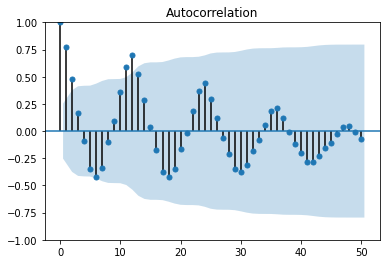

In [385]:
plot_acf(x=arima_data['price'], lags=50)
plt.show()

#### Partial ACF
- 특정 시점(t)의 데이터와 t+n의 데이터 간의 상관계수 파악하되, 그 사이에 있는 시점 데이터의 영향도 제거

In [386]:
from statsmodels.tsa.stattools import pacf

In [387]:
pacf(arima_data['price'], nlags=20)

array([ 1.        ,  0.78890632, -0.34306071, -0.22423997, -0.1232589 ,
       -0.39768343,  0.30771301,  0.13977001,  0.35822355, -0.02132234,
        0.41418364,  0.4704723 ,  0.23373142, -0.65603062, -0.59451517,
       -0.34472427,  0.29950263,  0.57985284, -0.04939371, -1.34571401,
        0.33253078])

In [388]:
pacf(arima_data['price'], nlags=20, alpha=0.05)

(array([ 1.        ,  0.78890632, -0.34306071, -0.22423997, -0.1232589 ,
        -0.39768343,  0.30771301,  0.13977001,  0.35822355, -0.02132234,
         0.41418364,  0.4704723 ,  0.23373142, -0.65603062, -0.59451517,
        -0.34472427,  0.29950263,  0.57985284, -0.04939371, -1.34571401,
         0.33253078]), array([[ 1.        ,  1.        ],
        [ 0.53587606,  1.04193658],
        [-0.59609098, -0.09003045],
        [-0.47727023,  0.02879029],
        [-0.37628916,  0.12977137],
        [-0.65071369, -0.14465316],
        [ 0.05468275,  0.56074328],
        [-0.11326026,  0.39280027],
        [ 0.10519328,  0.61125381],
        [-0.2743526 ,  0.23170792],
        [ 0.16115338,  0.6672139 ],
        [ 0.21744204,  0.72350257],
        [-0.01929885,  0.48676168],
        [-0.90906088, -0.40300035],
        [-0.84754543, -0.3414849 ],
        [-0.59775453, -0.09169401],
        [ 0.04647237,  0.5525329 ],
        [ 0.32682258,  0.8328831 ],
        [-0.30242398,  0.20363655],
  

In [389]:
from statsmodels.graphics.tsaplots import plot_pacf

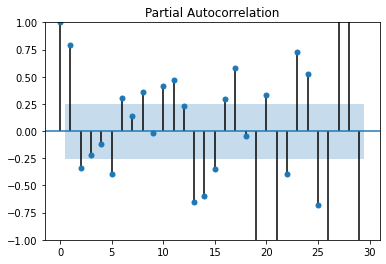

In [390]:
plot_pacf(x=arima_data['price'], lags=29)
plt.show()

### (5) CCA
- Canonical Correlation Analysis (정준상관분석)
- 각 집단의 두 선형 결합에 대한 상관분석. 요인분석과 다변량 회귀분석의 역할을 결합한 분석방법으로 알려져 있음
- 모든 변수들은 원칙적으로 연속형이어야 하지만 범주형 변수일 경우 더미 변수화하여 분석에 사용할 수 있음
- 각각 p, q 개로 이루어진 두 변수 그룹 X와 Y가 있을 때, X와 Y를 소속된 개별 변수들간의 선형결합으로 이루어진 정준변수라 하고, 정준변수 X와 Y 사이의 상관계수 p를 정준상관계수라고 함
- 가능한 모든 선형결합 중 두 변수 X,Y 간 상관계수를 최대화 시키는 선형결합 X,Y를 찾으며 이때, 선형결합을 나타내는 개별 변수들의 계수들을 정준계수라고 함
- 정준변수간 상관계수가 최대일 때는 제1 정준상관계수라고 하고 이에 대응되는 정준변수는 제1 정준변수라 함
- X와 Y의 가능한 모든 선형결합 중에서 제1 정준변수 쌍과는 서로 상관 없으면서 상관계수를 가장 크게 해주는 또 다른 선형결합 X와 Y가 제2 정준변수
- 정준상관분석의 목적은 정준상관계수와 정준변수를 추정하는 것 외에도 정준적재량과 교차적재량을 통해 두 변수 그룹간의 관계에 대한 각 변수의 상대적 영향력을 확인하는 것
    - 정준적재량 (canonical loadings): 정준변수와 해당 정준변수를 구성하는 측정변수들 사이의 상관계수
    - 교차적재량 (cross loadings): 정준변수와 대립하는 정준변수의 측정 변수들 사이의 상관계수
    - 이를 통해 변수 그룹들 사이에 내포된 상대적 중요도의 의미를 파악할 수 있음
- 차원축소 방법으로도 사용

In [391]:
from sklearn.cross_decomposition import CCA

In [392]:
cca_data = pd.read_excel('./data/cca_data.xlsx')

x = cca_data[['Weight', 'Waist', 'Pulse']].values ## 설명 변수 집단: 생리적 변수
y = cca_data[['Chins', 'Situps', 'Jumps']].values ## 종속 변수 집단: 운동량 변수

In [393]:
# 귀무가설: 생리적 변수는 운동량과 연관성이 없다
# 연구가설: 생리적 변수는 운동량과 유의한 상관관계를 가지고 있다.

# 정준변수 구하기
cca = CCA(n_components=1).fit(x, y)
x_c, y_c = cca.transform(x, y)

In [394]:
x_c1 = pd.DataFrame(x_c)[0]
y_c1 = pd.DataFrame(x_c)[0]
print(x_c)
print('\n', y_c)

[[-0.02468003]
 [ 0.28186932]
 [ 0.46275646]
 [ 0.15657182]
 [-0.25055945]
 [ 0.10792552]
 [ 0.15097223]
 [-0.203494  ]
 [-1.2698048 ]
 [-0.23314634]
 [-0.19259852]
 [-0.42858299]
 [ 0.00978148]
 [ 1.77820899]
 [-0.04172843]
 [ 0.00339145]
 [ 0.50445943]
 [-0.54821989]
 [-0.25950936]
 [-0.00361289]]

 [[-0.095968  ]
 [ 0.71700988]
 [ 0.76491769]
 [ 0.03728794]
 [-0.42811337]
 [ 0.54137737]
 [ 0.2989697 ]
 [ 0.11422451]
 [-1.29213118]
 [ 0.1778875 ]
 [-0.39350495]
 [-0.52661561]
 [-0.74610916]
 [ 1.42618716]
 [ 0.72020543]
 [-0.4237238 ]
 [ 0.88430825]
 [-1.05155077]
 [-1.26193648]
 [ 0.53727785]]


In [395]:
# 정준상관계수 구하기
cc_1 = stats.pearsonr(x_c1, y_c1)
print('제1정준상관계수:', cc_1)

# 정준적재량, 교차적재량
print('생리적 정준변수와 해당 변수들간 정준적재량:', np.corrcoef(x_c1.T, x.T)[0, 1:])
print('생리적 정준변수와 운동량 변수들간 교차적재량:', np.corrcoef(x_c1.T, y.T)[0, 1:])
print('운동량 정준변수와 해당 변수들간 정준적재량:', np.corrcoef(y_c1.T, y.T)[0, 1:])
print('운동량 정준변수와 생리적 변수들간 교차적재량:', np.corrcoef(y_c1.T, x.T)[0, 1:])

제1정준상관계수: (1.0, 0.0)
생리적 정준변수와 해당 변수들간 정준적재량: [ 0.62065861  0.92543282 -0.33284891]
생리적 정준변수와 운동량 변수들간 교차적재량: [-0.57890573 -0.65059385 -0.12904413]
운동량 정준변수와 해당 변수들간 정준적재량: [-0.57890573 -0.65059385 -0.12904413]
운동량 정준변수와 생리적 변수들간 교차적재량: [ 0.62065861  0.92543282 -0.33284891]


In [396]:
print(cca.coef_)

[[  2.23882453  29.77930328   4.84091049]
 [ -4.56024769 -60.65727657  -9.86042029]
 [  0.17069351   2.2704476    0.36908297]]


## Survival Analysis
- 관심 있는 사건이 발생할 때까지 예상되는 기간 조사
    - Event: 관심 경험 (생존/사망 또는 체류/사퇴)
    - Survival time: event가 발생할 때 까지의 기간
- Survival Function: T는 사건이 발생하고 t가 관측 중인 임의의 시점일 때 생존 S(t)는 T가 t보다 클 확률
- Censorship Problem(절단 문제): 관측 중단 관측치(Censored observations)는 사건이 일부 개인에 대해 기록되지 않은 경우 사건 발생 시간 데이터에서 발생함
    - 이벤트가 아직 발생하지 않은 경우(즉, 생존 시간을 알 수 없음/아직 사임하지 않은 사람의 경우 오해의 소지가 있음)
    - 데이터가 누락되거나(즉, 드롭아웃) contact 하는 포인트를 잃게 된 것 경우
- Censorship Problem Type
    - 좌측 관측 중단(Left-Censored): 생존 기간이 관찰된 기간보다 작음
    - 우측 관측 중단(Right-Censored): 생존 기간이 관찰된 기간보다 큼
    - 구간 관측 중단됨(Interval-Censored): 생존 기간을 정확히 정의할 수 없음
- Hazard Function
    - 위험 함수 또는 위험률 h(t)는 개인이 시간 t까지 생존하고 정확히 시간 t에 관심 있는 사건을 경험할 확률
    - 조위험함수는 조건부 확률로 정의되어 있다. 즉, 모든 개체에 대한 사건이 아니라 시간 t까지 살아있는 개체들에 대한 위험율
    - 위험함수는 아주 짧은 시간에 일아날 사건의 확률로서 순간적인(instantaneous)인 의미를 가지며, 아주 짧은 시간에 일어나는 극한의 의미임
    - 위험함수는 확률로서 정의되지만 발생률(rate)로 이해할 수 있음 분모는 확률이고 분자는 시간으로 표시되기 때문에 단위 시간당 일어나는 발생률로 이해할 수 있음

### (1) Kaplan-Meier Estimator
- 우측 관측 중단 관측치 처리
- 비모수적 방법으로 분포 가정이 필요하지 않음

In [397]:
df = pd.read_csv('./data/HR-Employee-Attrition.csv')
df[['YearsAtCompany', 'Attrition']].head()

,YearsAtCompany,Attrition
0,6,Yes
1,10,No
2,0,Yes
3,8,No
4,2,No


In [398]:
# !pip install lifelines
from sklearn.preprocessing import LabelEncoder
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

In [399]:
# Convert the Attrition into binary variable
encoder = LabelEncoder()
df['Attrition'] = encoder.fit_transform(df['Attrition'])

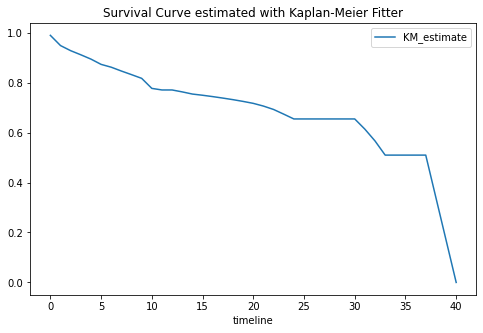

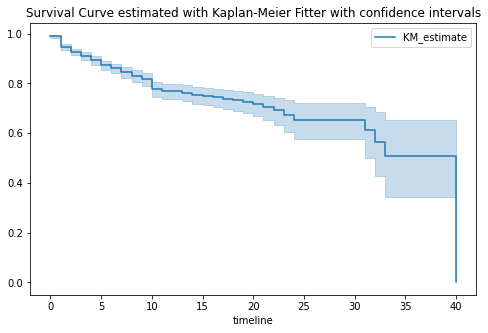

In [400]:
kmf = KaplanMeierFitter()
kmf.fit(durations=df['YearsAtCompany'], event_observed=df['Attrition'])

kmf.survival_function_.plot(figsize=(8, 5))
plt.title('Survival Curve estimated with Kaplan-Meier Fitter')
plt.show()

kmf.plot_survival_function(figsize=(8, 5))
plt.title('Survival Curve estimated with Kaplan-Meier Fitter with confidence intervals')
plt.show()

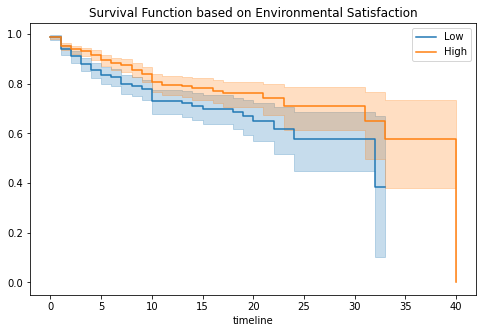

In [401]:
EnvironmentalLow = ((df['EnvironmentSatisfaction']==1) | (df['EnvironmentSatisfaction']==2))
EnvironmentalHigh = ((df['EnvironmentSatisfaction']==3) | (df['EnvironmentSatisfaction']==4))

ax = plt.subplot()
kmf = KaplanMeierFitter()

kmf.fit(durations=df[EnvironmentalLow]['YearsAtCompany'], 
        event_observed=df[EnvironmentalLow]['Attrition'], 
        label='Low')
kmf.plot_survival_function(figsize=(8, 5), ax=ax)

kmf.fit(durations=df[EnvironmentalHigh]['YearsAtCompany'], 
        event_observed=df[EnvironmentalHigh]['Attrition'], 
        label='High')
kmf.plot_survival_function(figsize=(8, 5), ax=ax)
plt.title('Survival Function based on Environmental Satisfaction')
plt.show();

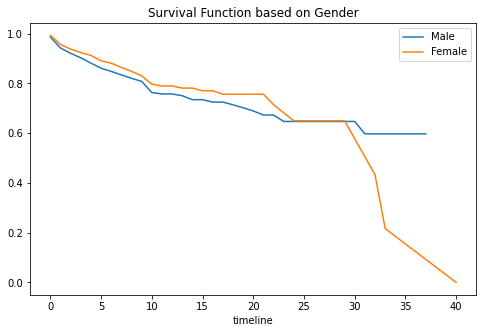

In [402]:
male = (df['Gender']=='Male')
female = (df['Gender']=='Female')

ax = plt.subplot()
kmf = KaplanMeierFitter()

kmf.fit(durations=df[male]['YearsAtCompany'], event_observed=df[male]['Attrition'], label='Male')
kmf.survival_function_.plot(figsize=(8, 5), ax=ax)
kmf.fit(durations=df[female]['YearsAtCompany'], event_observed=df[female]['Attrition'], label='Female')
kmf.survival_function_.plot(figsize=(8, 5), ax=ax)
plt.title('Survival Function based on Gender')
plt.show();

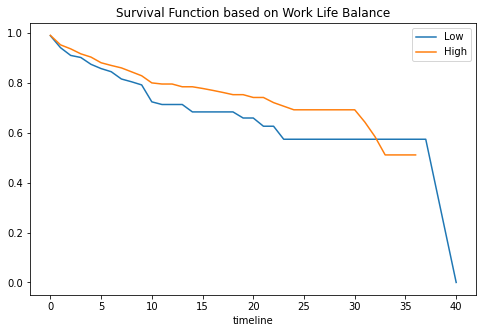

In [403]:
worklifelow = ((df['WorkLifeBalance'] == 1) | (df['WorkLifeBalance'] == 2))
worklifehigh = ((df['WorkLifeBalance'] == 3) | (df['WorkLifeBalance'] == 4))

ax = plt.subplot()
kmf = KaplanMeierFitter()

kmf.fit(durations=df[worklifelow]['YearsAtCompany'], 
        event_observed=df[worklifelow]['Attrition'], 
        label='Low')
kmf.survival_function_.plot(figsize=(8,5), ax=ax)

kmf.fit(durations=df[worklifehigh]['YearsAtCompany'], 
        event_observed=df[worklifehigh]['Attrition'], 
        label='High')
kmf.survival_function_.plot(figsize=(8,5), ax=ax)
plt.title('Survival Function based on Work Life Balance')
plt.show();

In [404]:
### Log rank test
# H0: both groups have the same distribution curve
# H1: the two groups are different
output = logrank_test(durations_A = df[worklifelow]['YearsAtCompany'],
                      durations_B = df[worklifehigh]['YearsAtCompany'],
                      event_observed_A = df[worklifelow]['Attrition'],
                      event_observed_B = df[worklifehigh]['Attrition'])
output.print_summary

<bound method StatisticalResult.print_summary of <lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.40 0.04      4.80>

In [405]:
### Probability predict
kmf.predict(6)

0.8689826396104314

BusinessTravel ['Travel_Rarely', 'Travel_Frequently', 'Non-Travel']
Department ['Sales', 'Research & Development', 'Human Resources']
EducationField ['Life Sciences', 'Other', 'Medical', 'Marketing', 'Technical Degree', 'Human Resources']
Gender ['Female', 'Male']
JobRole ['Sales Executive', 'Research Scientist', 'Laboratory Technician', 'Manufacturing Director', 'Healthcare Representative', 'Manager', 'Sales Representative', 'Research Director', 'Human Resources']
MaritalStatus ['Single', 'Married', 'Divorced']
Over18 ['Y']
OverTime ['Yes', 'No']


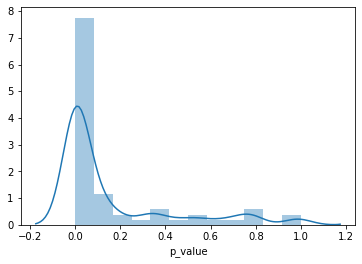

In [406]:
group_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']
results = []
for col in group_cols:
    choices = list(df[col].unique())
    print(col, choices)
    candidates = list(itertools.combinations(choices, 2))
    for a_group, b_group in candidates:
        A_GROUP = df.query(f"{col}=='{a_group}'")
        B_GROUP = df.query(f"{col}=='{b_group}'")

        output = logrank_test(durations_A = A_GROUP['YearsAtCompany'],
                            durations_B = B_GROUP['YearsAtCompany'],
                            event_observed_A = A_GROUP['Attrition'],
                            event_observed_B = B_GROUP['Attrition'])
        p_value = output.p_value
        results.append([col,a_group,b_group,p_value])
result_table = pd.DataFrame(results,columns=['column', "a_group", "b_group", "p_value"])
sns.distplot(result_table['p_value'])
plt.show()

### (2) Cox Proportional-Hazards Model
- 생존 기간과 영향을 미치는 여러 가지 요인들을 알아보는 분석 방법
- hazrad assumption이 유지된다는 가정
    - 샘플 간 생존 시간은 독립적
    - 예측 변수와 hazard 사이에 곱셈 관계
    - 시간이 지남에 따라 일정한 위험 비율
- 위험(Hazard)은 생존 곡선의 기울기로 정의됨. 피험자가 얼마나 빨리 죽어가는지를 측정
- 위험 비율은 두 그룹 비교. 위험비가 2.0이면 한 그룹의 사망률은 다른 그룹의 사망률의 두 배

In [407]:
from lifelines import CoxPHFitter

In [408]:
columns_selected = ['Attrition', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 
                    'PercentSalaryHike', 'RelationshipSatisfaction', 'StockOptionLevel', 'TrainingTimesLastYear', 'YearsAtCompany']
df = df[columns_selected]

In [409]:
coxph = CoxPHFitter()
coxph.fit(df, duration_col='YearsAtCompany', event_col='Attrition')

# Current employees
df_new = df.loc[df['Attrition'] == 0]

# Years at the company of current employees
df_new_obs = df_new['YearsAtCompany']

# Predict survival function for the employes still in the company
predictions = coxph.predict_survival_function(df_new, conditional_after=df_new_obs)
pd.DataFrame(predictions).head(11).iloc[:, :5]

,1,3,4,5,6
0.0,1.000000,1.000000,1.000000,1.000000,1.000000
1.0,0.986432,0.954723,0.960284,0.962204,0.988253
2.0,0.986432,0.832633,0.916395,0.921246,0.978083
3.0,0.967805,0.809508,0.861182,0.810189,0.966473
4.0,0.945323,0.809508,0.827520,0.789045,0.951264
5.0,0.932830,0.778306,0.780170,0.789045,0.941632
6.0,0.915764,0.741487,0.733267,0.760458,0.927576
7.0,0.896696,0.721424,0.683692,0.726633,0.913012
8.0,0.873145,0.694475,0.556009,0.708160,0.896843
9.0,0.842240,0.664989,0.532844,0.683295,0.850746


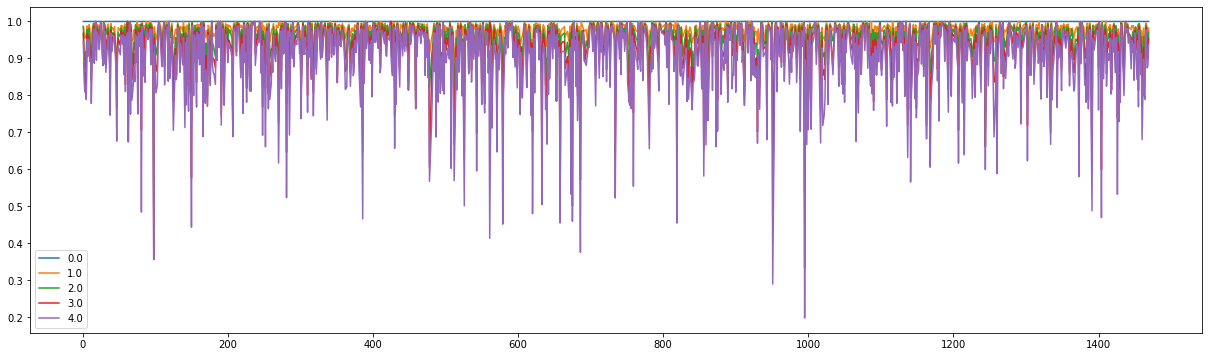

In [410]:
pd.DataFrame(predictions).head().T.plot(figsize=(21, 6))

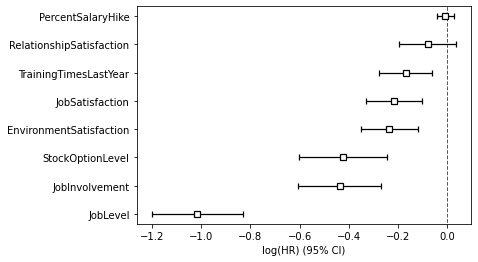

In [411]:
coxph.plot()

In [412]:
coxph.check_assumptions(df)

Proportional hazard assumption looks okay.


[]

### (3) Accelerated Failure Time (AFT) Model
- Cox-PH 모델의 비례 위험 가정 기준을 만족하지 못하는 경우에는 파라메트릭 모델을 사용하는 것이 더 나은 접근 방식이며, AFT는 파라메트릭 모델 중 하나
- 생존 함수가 모수적 연속 분포를 따른다고 가정 (Weibull 분포 또는 로그 정규 분포 등)
- 두 모집단(예: P 및 Q)에서 파생된 생존 함수가 공변량의 함수로 모델링할 수 있는 acceleration 계수 람다(λ)와 관련이 있다고 가정
- 공변량을 기반으로 고장 시간을 가속화하거나 감속

In [413]:
from lifelines import WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter

In [414]:
# Instantiate each fitter
wb = WeibullFitter()
ex = ExponentialFitter()
log = LogNormalFitter()
loglogis = LogLogisticFitter()

# Fit to data
for model in [wb, ex, log, loglogis]:
    model.fit(durations = df["YearsAtCompany"].replace(0 , 0.000001), event_observed=df["Attrition"])
    # Print AIC
    print("The AIC value for", model.__class__.__name__, "is",  model.AIC_)

The AIC value for WeibullFitter is 2138.2708129525727
The AIC value for ExponentialFitter is 2263.9437336059136
The AIC value for LogNormalFitter is 2276.8859677966007
The AIC value for LogLogisticFitter is 2151.579769001517


In [415]:
LogLogistic_aft = LogLogisticFitter() # best model
LogLogistic_aft.fit(durations=df['YearsAtCompany'].replace(0 , 0.000001), event_observed=df['Attrition'])
LogLogistic_aft.summary

,coef,se(coef),coef lower 95%,coef upper 95%,cmp to,z,p,-log2(p)
alpha_,123.012803,26.194356,71.672809,174.352796,1.0,4.657981,3.193261e-06,18.256538
beta_,0.580608,0.034575,0.512843,0.648373,1.0,-12.130000,7.324924e-34,110.072741


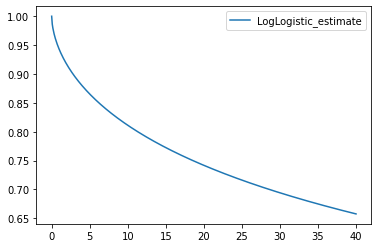

In [416]:
LogLogistic_aft.survival_function_.plot()
plt.show()

In [417]:
# 공변량의 단위 증가는 평균/중간 생존 시간이 exp(계수)만큼 변경됨을 나타냅니다.
# 계수가 양수이면 exp(계수)가 >1이 되어 사건/이벤트 시간이 느려지며, 마찬가지로 음의 계수는 평균/중간 생존 시간을 줄입니다.
LogLogistic_aft.median_survival_time_

123.01280287855722

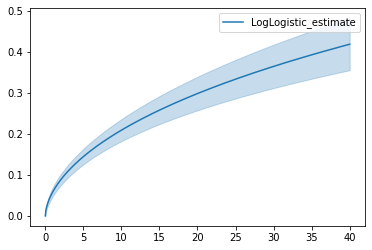

In [418]:
LogLogistic_aft.plot()

## Association Analysis
- 사건의 연관규칙을 찾는 방법
- A -> B

### (1) Run test
#### One sample
- 샘플의 무작위 추출 여부 검정
- 수치형 데이터의 경우 중앙값을 기준으로 이진화한 다음 검정

In [419]:
data = ['a', 'a', 'b', 'b', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'a', 'a', 'b', 'b', 'a', 'b', 'b']

test_df = pd.DataFrame(data, columns=["product"])
test_df.head()

,product
0,a
1,a
2,b
3,b
4,a


귀무가설(H0) <br>
연속적인 관측값이 임의적이다.<br>
대립가설(H1)<br>
연속적인 관측값이 임의적이지 않다 (연관이 있다).<br>

In [420]:
from statsmodels.sandbox.stats.runs import runstest_1samp

In [421]:
# Run-test를 위한 데이터 변환 
test_df.loc[test_df['product']=='a', 'product']=1
test_df.loc[test_df['product']=='b', 'product']=0

# Perform Runs test
runstest_1samp(test_df['product'], cutoff=0.5, correction=True)

(-1.1144881152070183, 0.26506984027306035)

[결과해석]
P-value가 유의수준 (0.05)보다 크므로 귀무가설을 기각하지 않는다. 즉, 상품 a와 b의 구매에는 연관이 없다.

#### Two sample
- 두 표본이 같은 분포에서 나왔는지 테스트
- Wald–Wolfowitz Run test

H0: The two populations have the same distribution. <br>
H1: The two populations have different distributions. 

In [422]:
from statsmodels.sandbox.stats.runs import runstest_2samp

In [423]:
x = [31.8, 32.8, 39.2, 36, 30, 34.5, 37.4]
y = [35.5, 27.6, 21.3, 24.8, 36.7, 30]

res = runstest_2samp(x, y)
res

ties detected


(0.022428065200812752, 0.9821064931864921)

[결과해석]
P-value가 유의수준 (0.05)보다 크므로 귀무가설을 기각하지 않는다. 즉, x와 y는 같은 분포에서 온 것으로 볼 수 있다.

### (2) Association rules
- 조건-결과 식으로 표현되는 유용한 패턴을 발견해 내는 것
- 장바구니분석, 서열분석
- 구현과 이해가 쉽고 간단하지만, 품목수가 많으면 계산량이 기하급수적으로 증가하므로, 적절한 품목 결정 필요
- 거래량이 적은 경우 규칙 발견 시 제외되기 쉬움 -> 유사 품목과 함께 묶는 것으로 해결 가능
- 측정 지표
    - 지지도 (Support): 전체 거래 중 품목 A, B가 동시에 포함되는 거래의 비율. 전체 구매 경향 파악
    - 신뢰도 (Confidence): 품목 A가 포함된 거래 중 A, B가 동시에 포함되는 거래의 비율. A -> B 연관성 정도
    - 향상도 (Lift): 품목 B를 구매한 고객 중, A를 구매한 후 B를 구매할 확률. 1이면 A, B가 독립, 1보다 크면 양의 상관관계
- 파생 측정 지표
    - 레버리지 (Leverage): A와 B가 동시에 포함된 빈도와 A와 B가 독립인 경우 예상되는 빈도의 차이. A & B의 지지도 - A의 지지도 * B의 지지도
    - 확신 (Conviction): 결과절이 조건절에 의지하는 정도로 1일 경우 A와 B는 독립이고, 1보다 크면 유의미한 연관성이 있다고 판단함. (1 - B의 지지도)/(1 - (A -> B의 신뢰도))
- 연관규칙 생성 알고리즘
    - Apriori
        - 계산량을 줄이기 위해, 빈발집합(Frequent Item Sets)만을 고려해서 연관 규칙 생성
        - Frequent Item set: 최소지지도 이상의 지지도 값을 갖는 item
    - FP-Growth
        - FP-Tree (Frequency Pattern Tree) 생성하고, 분할정복 방식 사용
        - Apriori보다 빠른 탐색 가능

In [424]:
df = pd.read_csv('./ADP_book_ver01/data/groceries.csv')
df

,"citrus fruit,semi-finished bread,margarine,ready soups"
0,"tropical fruit,yogurt,coffee"
1,whole milk
2,"pip fruit,yogurt,cream cheese,meat spreads"
3,"other vegetables,whole milk,condensed milk,lon..."
4,"whole milk,butter,yogurt,rice,abrasive cleaner"
...,...
9829,"sausage,chicken,beef,hamburger meat,citrus fru..."
9830,cooking chocolate
9831,"chicken,citrus fruit,other vegetables,butter,y..."
9832,"semi-finished bread,bottled water,soda,bottled..."


In [425]:
### Comma로 데이터 분할
df_split = df.iloc[:, 0].str.split(',', expand=True)
df_split.values

array([['tropical fruit', 'yogurt', 'coffee', ..., None, None, None],
       ['whole milk', None, None, ..., None, None, None],
       ['pip fruit', 'yogurt', 'cream cheese', ..., None, None, None],
       ...,
       ['chicken', 'citrus fruit', 'other vegetables', ..., None, None,
        None],
       ['semi-finished bread', 'bottled water', 'soda', ..., None, None,
        None],
       ['chicken', 'tropical fruit', 'other vegetables', ..., None, None,
        None]], dtype=object)

In [426]:
### None 제거
df_split_ary = df_split.values
groceries = []
for i in range(len(df_split_ary)) : 
    temp = list(filter(None, df_split_ary[i]))
    groceries.append(temp)

In [427]:
from mlxtend.preprocessing import TransactionEncoder

In [428]:
te = TransactionEncoder()
groceries_tr = te.fit_transform(groceries)
groceries_tr = pd.DataFrame(groceries_tr, columns=te.columns_)
groceries_tr.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False


In [429]:
# !pip install mlxtend
from mlxtend.frequent_patterns import apriori, fpgrowth
from mlxtend.frequent_patterns import association_rules

In [430]:
### 지지도가 5% 이상인 빈번 항목 집합 탐색
# apriori
groceries_ap = apriori(groceries_tr, min_support=0.05, use_colnames=True)
groceries_ap[:10]

,support,itemsets
0,0.052471,(beef)
1,0.080537,(bottled beer)
2,0.110535,(bottled water)
3,0.064877,(brown bread)
4,0.055420,(butter)
5,0.077690,(canned beer)
6,0.082672,(citrus fruit)
7,0.058064,(coffee)
8,0.053285,(curd)
9,0.063453,(domestic eggs)


In [431]:
# fp-growth
groceries_fset = fpgrowth(groceries_tr, min_support=0.05, use_colnames=True)
groceries_fset[:10]

,support,itemsets
0,0.139516,(yogurt)
1,0.104942,(tropical fruit)
2,0.058064,(coffee)
3,0.255542,(whole milk)
4,0.075656,(pip fruit)
5,0.193512,(other vegetables)
6,0.055420,(butter)
7,0.183954,(rolls/buns)
8,0.080537,(bottled beer)
9,0.110535,(bottled water)


In [432]:
# 신뢰도가 0.3 이상인 빈번 항목 집합 탐색
association_rules(groceries_ap, metric="confidence", min_threshold=0.3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(other vegetables),(whole milk),0.193512,0.255542,0.074842,0.386758,1.513480,0.025392,1.213971
1,(rolls/buns),(whole milk),0.183954,0.255542,0.056640,0.307905,1.204909,0.009632,1.075659
2,(yogurt),(whole milk),0.139516,0.255542,0.056030,0.401603,1.571575,0.020378,1.244088


In [433]:
rules = association_rules(groceries_ap, metric="lift", min_threshold=1)

# 규칙의 길이 컬럼 생성 
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
0,(whole milk),(other vegetables),0.255542,0.193512,0.074842,0.292877,1.513480,0.025392,1.140520,1
1,(other vegetables),(whole milk),0.193512,0.255542,0.074842,0.386758,1.513480,0.025392,1.213971,1
2,(rolls/buns),(whole milk),0.183954,0.255542,0.056640,0.307905,1.204909,0.009632,1.075659,1
3,(whole milk),(rolls/buns),0.255542,0.183954,0.056640,0.221647,1.204909,0.009632,1.048428,1
4,(whole milk),(yogurt),0.255542,0.139516,0.056030,0.219260,1.571575,0.020378,1.102139,1
5,(yogurt),(whole milk),0.139516,0.255542,0.056030,0.401603,1.571575,0.020378,1.244088,1


In [434]:
rules[(rules['antecedent_len'] >=1) & (rules['confidence'] >=0.4) & (rules['lift'] >=1)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
5,(yogurt),(whole milk),0.139516,0.255542,0.05603,0.401603,1.571575,0.020378,1.244088,1


In [435]:
# 특정 consequents 찾기
rules[(rules.consequents == frozenset({'whole milk'})) | (rules.consequents == frozenset({'yogurt'}))]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
1,(other vegetables),(whole milk),0.193512,0.255542,0.074842,0.386758,1.513480,0.025392,1.213971,1
2,(rolls/buns),(whole milk),0.183954,0.255542,0.056640,0.307905,1.204909,0.009632,1.075659,1
4,(whole milk),(yogurt),0.255542,0.139516,0.056030,0.219260,1.571575,0.020378,1.102139,1
5,(yogurt),(whole milk),0.139516,0.255542,0.056030,0.401603,1.571575,0.020378,1.244088,1


In [436]:
### sample: frozenset data extract
[i for i in rules.consequents[0]]

['other vegetables']

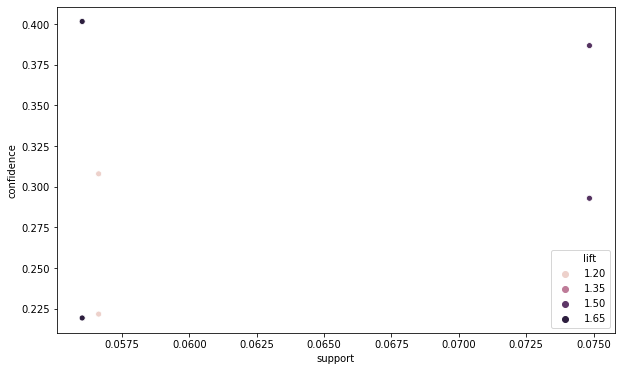

In [437]:
# 성능변수 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rules['support'], y=rules['confidence'], hue=rules['lift'])
plt.show()

In [438]:
import networkx as nx

In [439]:
### Visualize network
def draw_graph(rules, rules_to_show):
    G1 = nx.DiGraph()
   
    color_map = []
    colors = np.random.rand(rules_to_show)    
    strs = ["R"+str(i+1) for i in range(rules_to_show + 2)]
   
    for i in range (rules_to_show):      
        G1.add_nodes_from(["R"+str(i)])
     
        for a in rules.iloc[i]['antecedents']:
            G1.add_nodes_from([a])
            G1.add_edge(a, "R"+str(i), color=colors[i] , weight=2)
       
        for c in rules.iloc[i]['consequents']:
            G1.add_nodes_from([])
            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)
 
    for node in G1:
        found_a_string = False
        for item in strs: 
            if node==item:
                found_a_string = True
        if found_a_string:
            color_map.append('yellow')
        else:
            color_map.append('green')       

    edges = G1.edges()
    
    colors = [G1[u][v]['color'] for u, v in edges]
    weights = [G1[u][v]['weight'] for u, v in edges]
    pos = nx.spring_layout(G1, k=16, scale=1)
    nx.draw(G1, pos, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)            
   
    for p in pos:  # raise text positions
        pos[p][1] += 0.07
    nx.draw_networkx_labels(G1, pos)
    plt.show()

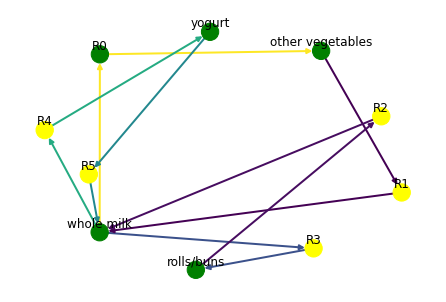

In [440]:
draw_graph(rules, 6)

## Time-Series Analysis
- 시간에 흐름에 따른 데이터 분석
- 미래의 변화에 대한 추세 분석

### (1) Time-Series EDA
- 정상성 확인
    - 정상성 정의
        - 평균이 일정
        - 분산이 시점과 독립
        - 공분산은 시차에만 의존
    - ACF 그래프
    - ADF(Augmented Dickey Fuller), KPSS(Kwiatowski-Philips-Schmidt-Shin) test
    - 정상 시계열로 변환
        - Log/Box-cox Transformation(분산 변동폭 제거), Differencing(추세와 계절성 제거)
- 자기상관 확인
    - ACF, PACF 그래프
    - Ljung-box, Drubin-watson test
- Decomposition -> preprocessing 부분 참고

In [441]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

In [442]:
arima_data = pd.read_csv('./ADP_book_ver01/data/arima_data.csv', names=['day', 'price'])
arima_data.head()

arima_data['day'] = pd.to_datetime(arima_data['day'], format="%Y-%m-%d")
arima_data.set_index('day', inplace=True)
arima_data.head(3)

,price
day,
2013-01-01,3794
2013-02-01,3863
2013-03-01,5190


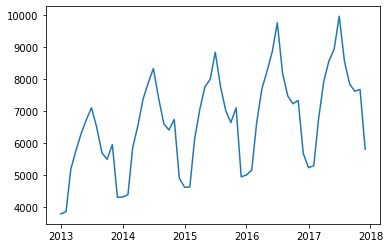

In [443]:
plt.plot(arima_data.index, arima_data['price'])
plt.show()

In [444]:
# Train, Test 데이터 구분
training = arima_data[:"2016-12-01"]
test = arima_data.drop(training.index)

In [445]:
### 정상성 검정
# ADF test
# H0: 데이터가 정상성을 갖지 않는다
# H1: 데이터가 정상성을 갖는다
adf = adfuller(training, regression='ct')
print('ADF Statistic: {}'.format(adf[0]))
print('p-value : {}'.format(adf[1])) # 비정상 시계열

ADF Statistic: -1.9997199341327319
p-value : 0.6015863303794438


In [446]:
# KPSS test
# H0: 데이터가 정상시계열과 차이가 없다 (정상 시계열)
# H1 데이터가 정상시계열과 차이가 있다
adf = kpss(training, regression='ct')
print('KPSS Statistic: {}'.format(adf[0]))
print('p-value : {}'.format(adf[1])) # 정상 시계열로 판단되나, p-value가 꽤 낮음

KPSS Statistic: 0.03220767562835514
p-value : 0.1


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [447]:
### 자기상관 확인
# Ljung-box test
# H0: 데이터가 일련의 상관관계를 나타내지 않는다 (자기상관이 없다)
# H1: 데이터가 일련의 상관관계를 나타낸다
acorr_ljungbox(training, return_df=True, auto_lag=True).head(3) # 자기상관 있음

,lb_stat,lb_pvalue
1,29.583761,5.355171e-08
2,40.293075,1.780205e-09
3,41.296580,5.657406e-09


In [448]:
# Durbin-Watson test
# 통계량이 2에 가까우면 자기상관 없음
# 통계량이 0 또는 4에 가까우면 자기상관 있음
durbin_watson(training)

array([0.0176216])

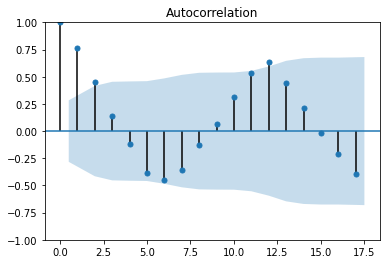

In [449]:
# ACF 그래프 확인
# 시차에 따라 값이 값이 빠르게 떨어지지 않으면 비정상
# 그래프의 임계영역을 벗어나는 값들이 있으므로, 자기 상관 있음
plot_acf(training)
plt.show()

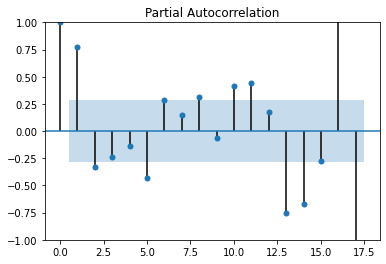

In [450]:
# PACF 그래프 확인
# PACF 그래프의 임계영역을 벗어나는 시차 1, 2, 7 .. 등이 자기상관이 있음
plot_pacf(training)
plt.show()

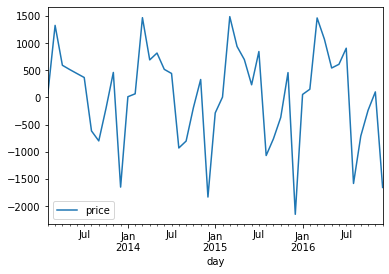

In [451]:
### 데이터 정상화
# 차분 실행
diff_data = training.diff(1)
diff_data = diff_data.dropna()
diff_data.plot()

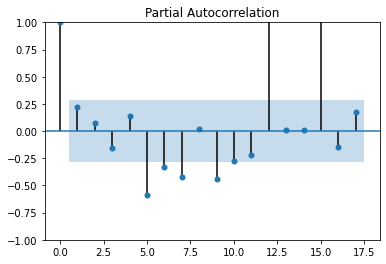

In [452]:
plot_pacf(diff_data) # AR(p)의 값 확인 가능?
plt.show()

In [453]:
### J&J data
data = pd.read_csv('./data/jj.csv')
data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


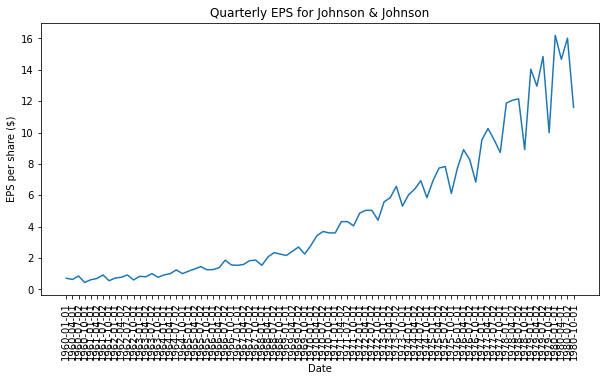

In [454]:
plt.figure(figsize=[10, 5]); # Set dimensions for figure
sns.lineplot(x=data['date'], y=data['data'])
plt.title('Quarterly EPS for Johnson & Johnson')
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.show()

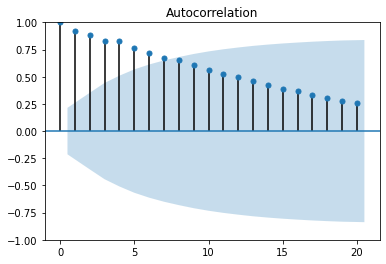

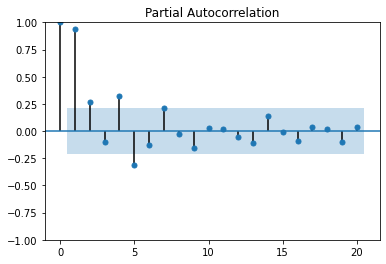

In [455]:
plot_acf(data['data']); # 자기상관 있음
plot_pacf(data['data']);

In [456]:
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}') 
print(f'p-value: {ad_fuller_result[1]}') # 정상성 없음

ADF Statistic: 2.7420165734574726
p-value: 1.0


In [457]:
# Ljung-Box test
acorr_ljungbox(data['data'], return_df=True, auto_lag=True).head(3) # 자기상관 있음

,lb_stat,lb_pvalue
1,74.486740,6.104694e-18
2,143.996707,5.389051e-32
3,205.858742,2.286448e-44


In [458]:
### 데이터 정상화
# 차분, 로그변환
data['data'] = np.log(data['data'])
data['data'] = data['data'].diff()
data = data.drop(data.index[0])

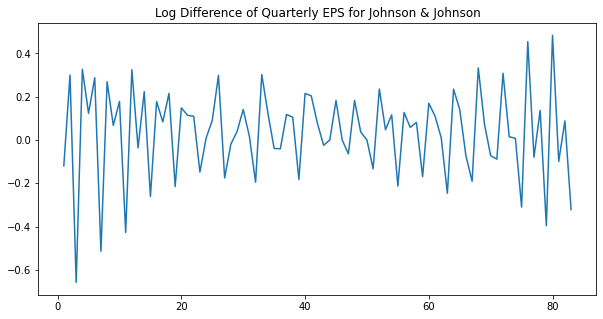

In [459]:
plt.figure(figsize=[10, 5]); # Set dimensions for figure
sns.lineplot(data=data['data'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

In [460]:
# Seasonal differencing
data['data'] = data['data'].diff(4)
data = data.drop([1, 2, 3, 4], axis=0).reset_index(drop=True)
data.head()

,date,data
0,1961-04-02,0.242778
1,1961-07-02,-0.011834
2,1961-10-01,0.144006
3,1962-01-01,-0.057351
4,1962-04-02,-0.056093


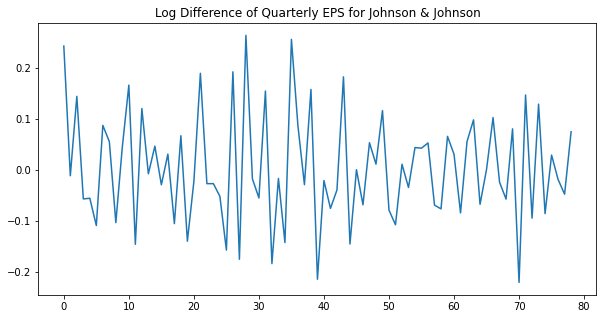

In [461]:
plt.figure(figsize=[10, 5]); # Set dimensions for figure
plt.plot(data['data'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

In [462]:
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.630805109914272
p-value: 5.721578695135916e-09


### (1) ARIMA
- AR(Autoregressive): 현 시점의 자료가 p 시점 전의 유한개의 과거 자료로 설명됨. AR(p)
- MA(Moving Average): 현 시점의 자료를 백색잡음의 선형결함으로 표현하며, 항상 정상성이 만족됨. MA(q)
- AR 모형은 ACF가 연속적인 (감소) 형태, PACF가 p+1 시차에서 절단된 형태
- MA 모형은 PACF가 연속적인 형태, ACF가 p+1 시차에서 절단된 형태
- I는 차분 횟수를 의미함

In [463]:
from statsmodels.tsa.arima.model import ARIMA

In [464]:
model = ARIMA(training, order=(2, 1, 2))
res = model.fit()
res.summary()

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                   48
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -375.875
Date:                Sun, 29 Oct 2023   AIC                            761.750
Time:                        23:07:33   BIC                            771.001
Sample:                    01-01-2013   HQIC                           765.231
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3164      0.189     -6.952      0.000      -1.688      -0.945
ar.L2         -0.3188      0.190     -1.677      0.094      -0.691       0.054
ma.L1          1.9698      0.242      8.129      0.000       1.495       2.445
ma.L2          0.9947      0.241      4.129      0.000       0.523       1.467
sigma2      4.441e+05   1.14e-06   3.91e+11      0.000    4.44e+05    4.44e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.38
Prob(Q):                              0.74   Prob(JB):                         0.83
Heteroskedasticity (H):               1.49   Skew:                            -0.21
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.82e+27. Standard errors may be unstable.
"""

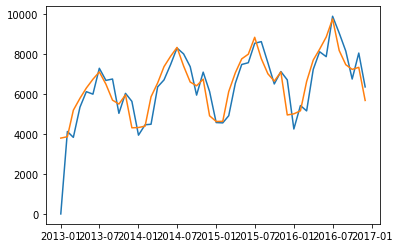

In [465]:
plt.plot(res.predict())
plt.plot(training)

In [466]:
# 학습 데이터셋으로부터 test 데이터 길이만큼 예측합니다.
forecast_data = res.forecast(steps=len(test), alpha=0.05) 

pred_y = forecast_data
pred_y

2017-01-01    5830.379461
2017-02-01    5508.176679
2017-03-01    5883.751666
2017-04-01    5492.053875
2017-05-01    5887.961699
2017-06-01    5491.651433
2017-07-01    5887.149389
2017-08-01    5492.849059
2017-09-01    5885.831773
2017-10-01    5494.201798
2017-11-01    5884.471047
2017-12-01    5495.561841
Freq: MS, Name: predicted_mean, dtype: float64

In [467]:
test_y = test # 실제 데이터
test_y

,price
day,
2017-01-01,5236
2017-02-01,5299
2017-03-01,6744
2017-04-01,7927
2017-05-01,8561
2017-06-01,8930
2017-07-01,9960
2017-08-01,8548
2017-09-01,7843


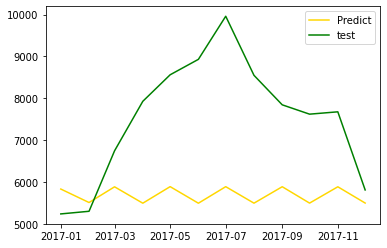

In [468]:
plt.plot(pred_y, color="gold", label='Predict') # 모델이 예상한 가격 그래프
plt.plot(test_y, color="green" , label='test') # 실제 가격 그래프
plt.legend()
plt.show()

In [469]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [470]:
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred)/y_test)) * 100

In [471]:
print("r2_score: ", r2_score(test_y, pred_y))
print("RMSE: ", mean_squared_error(test_y, pred_y, squared=False))
print("MAPE: ", MAPE(test_y, pred_y))

r2_score:  -1.6433699941173576
RMSE:  2302.404731847706
MAPE:  2017-01-01 00:00:00   NaN
2017-02-01 00:00:00   NaN
2017-03-01 00:00:00   NaN
2017-04-01 00:00:00   NaN
2017-05-01 00:00:00   NaN
2017-06-01 00:00:00   NaN
2017-07-01 00:00:00   NaN
2017-08-01 00:00:00   NaN
2017-09-01 00:00:00   NaN
2017-10-01 00:00:00   NaN
2017-11-01 00:00:00   NaN
2017-12-01 00:00:00   NaN
price                 NaN
dtype: float64


In [472]:
# Parameter search
print('Examples of parameter combinations for ARIMA...')
p = range(0, 3)
d = range(1, 2)
q = range(0, 3)

pdq = list(itertools.product(p, d, q))
pdq

Examples of parameter combinations for ARIMA...


[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2)]

In [473]:
aic = list()
for i in pdq:
    model = ARIMA(training.values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC : {round(model_fit.aic, 2)}')
    aic.append(round(model_fit.aic, 2))

# Search optimal parameters
optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

ARIMA: (0, 1, 0) >> AIC : 773.75
ARIMA: (0, 1, 1) >> AIC : 774.05
ARIMA: (0, 1, 2) >> AIC : 774.59
ARIMA: (1, 1, 0) >> AIC : 773.47
ARIMA: (1, 1, 1) >> AIC : 775.15
ARIMA: (1, 1, 2) >> AIC : 762.05
ARIMA: (2, 1, 0) >> AIC : 774.7
ARIMA: (2, 1, 1) >> AIC : 765.81
ARIMA: (2, 1, 2) >> AIC : 761.75


/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[((2, 1, 2), 761.75)]

In [474]:
# 위 최적 값으로 만든 모델 다시 Summary
# 동일한 모델이 선정됨
model_opt = ARIMA(training.values, order = optimal[0][0])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -375.875
Date:                Sun, 29 Oct 2023   AIC                            761.750
Time:                        23:07:33   BIC                            771.001
Sample:                             0   HQIC                           765.231
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3164      0.189     -6.952      0.000      -1.688      -0.945
ar.L2         -0.3188      0.190     -1.677      0.094      -0.691       0.054
ma.L1          1.9698      0.242      8.129      0.000       1.495       2.445
ma.L2          0.9947      0.241      4.129      0.000       0.523       1.467
sigma2      4.441e+05   1.14e-06   3.91e+11      0.000    4.44e+05    4.44e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.38
Prob(Q):                              0.74   Prob(JB):                         0.83
Heteroskedasticity (H):               1.49   Skew:                            -0.21
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.82e+27. Standard errors may be unstable.
"""

### (2) SARIMA
- Seasonal ARIMA
- 총 7개의 파라미터 존재. trend에 대한 부분(p, d, q)과 seasonal에 대한 부분(P, D, Q, m)
    - trend 파라미터는 ARIMA와 동일
    - P: pacf에서 계절성이 주기가 몇 번 반복 됐는지 확인
    - D: 계절성이 있는지 확인하고 계절성 차분의 필요성에 따라 1 or 0
    - Q: acf기준 계절성 주기가 몇 번 반복 됐는지 확인
    - m: 계절성 주기
- 모델 검증
    - Ljung-Box(L1): 잔차가 white noise를 따르는지 확인
        - 귀무가설: 잔차가 white noise를 따른다
        - p-value가 낮으면 white noise를 따르지 않고 시간대 별 잔차가 corrleated 되어 있는 것으로 판단
    - Jarque-Bera : 잔차의 정규성 판단
        - 귀무가설: 잔차가 normal distribution을 따른다
    - Heteroskedasticity: 각 시간대 별 잔차의 분산이 일정한지 확인
        - 귀무가설: 잔차의 분산이 일정하다

In [475]:
# !pip install pmdarima
from pmdarima import auto_arima

In [476]:
auto_model = auto_arima(training, start_p=0, d=1, start_q=0,
                        max_p=3, max_q=3, 
                        start_P=0, start_Q=0,
                        max_P=3, max_Q=3, m=12,
                        seasonal=True, information_criterion='aic',
                        trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=481.846, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=482.652, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=482.466, Time=0.05 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=483.637, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=483.669, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=481.031, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=482.740, Time=0.07 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=482.616, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=482.682, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=480.687, Time=0.02 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=482.403, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=48

In [477]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -238.344
Date:                             Sun, 29 Oct 2023   AIC                            480.687
Time:                                     23:07:34   BIC                            483.798
Sample:                                 01-01-2013   HQIC                           481.761
                                      - 12-01-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3185      0.177     -1.801      0.072      -0.665       0.028
sigma2      4.803e+04   1.64e+04      2.924      0.003    1.58e+04    8.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.15
Prob(Q):                              0.95   Prob(JB):                         0.56
Heteroskedasticity (H):               1.56   Skew:                            -0.14
Prob(H) (two-sided):                  0.45   Kurtosis:                         2.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [478]:
# 학습 데이터셋으로부터 test 데이터 길이만큼 예측
auto_pred_y = pd.DataFrame(auto_model.predict(n_periods=len(test)), index=test.index) 
auto_pred_y.columns = ['predicted_price']
auto_pred_y

,predicted_price
day,
2017-01-01,5609.436979
2017-02-01,5761.436979
2017-03-01,7225.436979
2017-04-01,8298.436979
2017-05-01,8841.436979
2017-06-01,9452.436979
2017-07-01,10359.436979
2017-08-01,8777.436979
2017-09-01,8068.436979


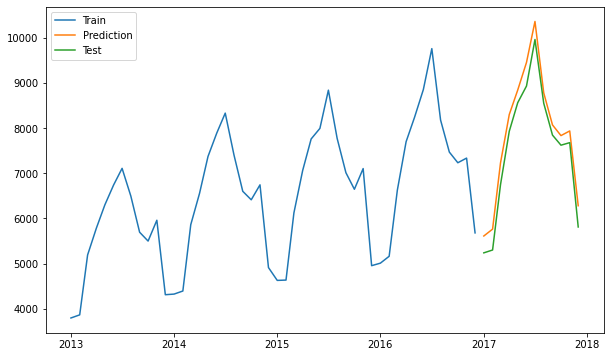

In [479]:
plt.figure(figsize=(10,6))
plt.plot(training, label="Train") # Train 데이터 
plt.plot(auto_pred_y, label="Prediction") # 모델이 예상한 그래프 
plt.plot(test, label="Test") # 실제 가격 그래프 
plt.legend(loc='upper left')
plt.show()

In [480]:
print("r2_score: ", r2_score(test_y, auto_pred_y))
print("RMSE: ", mean_squared_error(test_y, auto_pred_y, squared=False))
print("MAPE: ", MAPE(test_y, auto_pred_y))

r2_score:  0.9305467058853065
RMSE:  373.2064282752658
MAPE:  predicted_price   NaN
price             NaN
dtype: float64


In [481]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [482]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    results = []
    
    for param in parameters_list:
        model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        aic = model.aic
        results.append([param, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [483]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4

parameters = itertools.product(p, q, P, Q)
parameters_list = list(parameters)

In [ ]:
result_df = optimize_SARIMA(parameters_list, d, D, s, data['data'])

In [485]:
result_df[result_df.AIC==result_df.AIC.min()]

,"(p,q)x(P,Q)",AIC
0,"(0, 2, 0, 2)",-114.464416


In [486]:
best_model = SARIMAX(data['data'], order=(0, 2, 0), seasonal_order=(0, 2, 0, 2)).fit(dis=-1)
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              data   No. Observations:                   79
Model:             SARIMAX(0, 2, 0)x(0, 2, 0, 2)   Log Likelihood                 -61.375
Date:                           Sun, 29 Oct 2023   AIC                            124.750
Time:                                   23:08:26   BIC                            127.040
Sample:                                        0   HQIC                           125.662
                                            - 79                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.3146      0.063      4.997      0.000       0.191       0.438
===================================================================================
Ljung-Box (L1) (Q):                  14.89   Jarque-Bera (JB):                 1.54
Prob(Q):                              0.00   Prob(JB):                         0.46
Heteroskedasticity (H):               0.64   Skew:                             0.17
Prob(H) (two-sided):                  0.29   Kurtosis:                         2.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

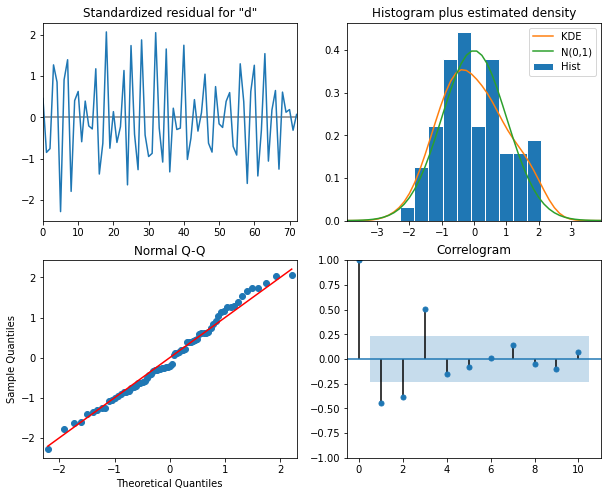

In [487]:
best_model.plot_diagnostics(figsize=(10, 8));

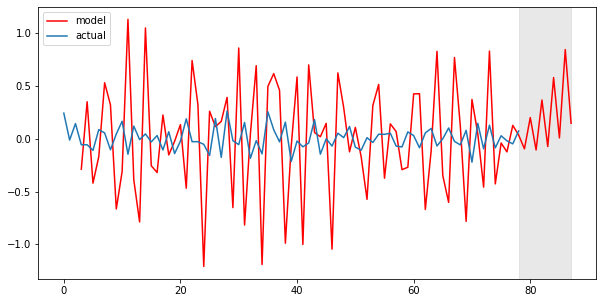

In [488]:
data['arima_model'] = best_model.fittedvalues
data['arima_model'][:2 + 1] = np.NaN # 첫 주기까지(여기서는 2)는 NaN으로 처리하는 듯

forecast = best_model.predict(start=data.shape[0], end=data.shape[0] + 8)
forecast = data['arima_model'].append(forecast)

plt.figure(figsize=(10, 5))
sns.lineplot(data=forecast, color='red', label='model')
plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
sns.lineplot(data=data['data'], label='actual')
plt.legend()
plt.show()

### (3) MARIMA
- Multi-variate ARIMA
- VAR (Vector AR)

In [489]:
air_quality = pd.read_excel('./data/AirQualityUCI.xlsx')
air_quality.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [490]:
air_quality['Date_Time'] = air_quality['Date'].astype(str) + ' ' + air_quality['Time'].astype(str)
air_quality['Date_Time'] = pd.to_datetime(air_quality.Date_Time , format = '%Y-%m-%d %H:%M:%S')
air_quality.index = air_quality.Date_Time
air_quality = air_quality.drop(['Date_Time', 'Date', 'Time'], axis=1)

In [491]:
air_quality = air_quality.dropna()
air_quality.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         9357 non-null   float64
 1   PT08.S1(CO)    9357 non-null   float64
 2   NMHC(GT)       9357 non-null   int64  
 3   C6H6(GT)       9357 non-null   float64
 4   PT08.S2(NMHC)  9357 non-null   float64
 5   NOx(GT)        9357 non-null   float64
 6   PT08.S3(NOx)   9357 non-null   float64
 7   NO2(GT)        9357 non-null   float64
 8   PT08.S4(NO2)   9357 non-null   float64
 9   PT08.S5(O3)    9357 non-null   float64
 10  T              9357 non-null   float64
 11  RH             9357 non-null   float64
 12  AH             9357 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 1023.4 KB


In [492]:
air_quality.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date_Time,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
2004-03-10 19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2004-03-10 20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
2004-03-10 21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
2004-03-10 22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [493]:
### Granger 인과검정
# VAR 예측을 수행하기 전에 해당 변수들이 모두 상호연관성이 있는가를 확인해줄 필요가 있다.
# Granger 인과검정의 영가설은 X가 Y에 영향을 미치지 않는다 이다. 즉, 검정 결과 p_value가 유의수준 0.05 이하라면 영가설을 기각하고 해당 변수를 예측모델의 인자로 사용하도록 한다.
df_pairs = pd.DataFrame(data=np.zeros((len(air_quality.columns), len(air_quality.columns))),
                        columns = ['X_'+ x for x in air_quality.columns],
                        index = ['Y_'+ x for x in air_quality.columns])

In [494]:
from statsmodels.tsa.stattools import grangercausalitytests

In [ ]:
maxlag = 14
for col_i, col in enumerate(air_quality.columns):
    for idx_i, idx in enumerate(air_quality.columns):
        outs = grangercausalitytests(air_quality[[col,idx]], maxlag=maxlag)
        pval_min = np.min([round(outs[x][0]['ssr_chi2test'][1],2) for x in range(1, maxlag + 1)])
        df_pairs.iloc[idx_i, col_i] = pval_min

In [496]:
df_pairs

,X_CO(GT),X_PT08.S1(CO),X_NMHC(GT),X_C6H6(GT),X_PT08.S2(NMHC),X_NOx(GT),X_PT08.S3(NOx),X_NO2(GT),X_PT08.S4(NO2),X_PT08.S5(O3),X_T,X_RH,X_AH
Y_CO(GT),1.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.11
Y_PT08.S1(CO),0.00,1.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.25
Y_NMHC(GT),0.00,0.0,1.00,0.0,0.01,0.00,0.0,0.0,0.0,0.01,0.00,0.0,0.00
Y_C6H6(GT),0.00,0.0,0.01,1.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.09
Y_PT08.S2(NMHC),0.00,0.0,0.00,0.0,1.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.13
Y_NOx(GT),0.00,0.0,0.00,0.0,0.00,1.00,0.0,0.0,0.0,0.00,0.00,0.0,0.06
Y_PT08.S3(NOx),0.00,0.0,0.00,0.0,0.00,0.00,1.0,0.0,0.0,0.00,0.00,0.0,0.21
Y_NO2(GT),0.00,0.0,0.00,0.0,0.00,0.00,0.0,1.0,0.0,0.00,0.00,0.0,0.21
Y_PT08.S4(NO2),0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,1.0,0.00,0.01,0.0,0.44
Y_PT08.S5(O3),0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,1.00,0.00,0.0,0.12


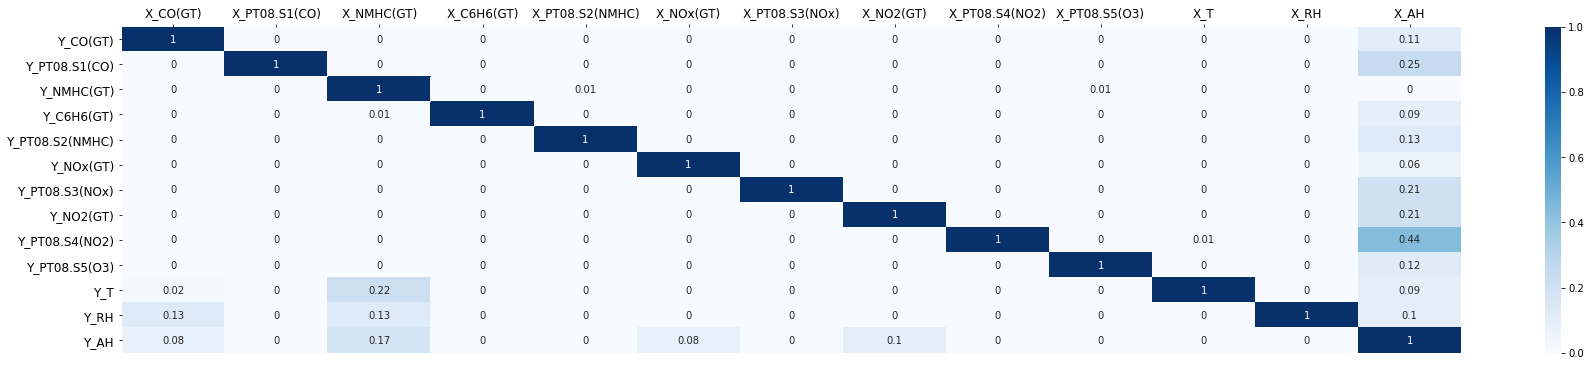

In [497]:
plt.figure(figsize=(30, 6))
ax = sns.heatmap(df_pairs, annot=True, cmap='Blues')
ax.xaxis.tick_top()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [498]:
# 상호 영향이 일부 없는 변수 제거 -> AH, T, RH
air_quality = air_quality.drop(['AH', 'T', 'RH'], axis=1)

In [499]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [500]:
### 공적분 검정(혹은 요한슨 검정)은 다중 시계열 간 적분상 균형관계가 존재하는가를 판단한다.
# 즉, Granger 검정이 단일 시계열보다 다중 시계열로 설명력을 더 얻을수 있는가? 를 확인해주었다면, 
# Cointegration 검정은 다중 시계열이 장기적 기간을 두고 안정적인 연관성을 보이는가? 를 확인해준다.
def calc_sig_dist(cols):
    out = coint_johansen(air_quality[cols], 1, 1)
    stats = [round(x,2) for x in out.lr1]
    sigs = [round(x,2) for x in out.cvt[:, 1]]
    yns = [x>y for x,y in zip(stats,sigs)]
    dist = np.mean(np.array(stats) - np.array(sigs))
    
    print('stats: ',stats)
    print('sig-level: ',sigs)
    print('significant_yn: ',[x>y for x,y in zip(stats,sigs)])
    print('dist: ', round(dist,2))

In [501]:
calc_sig_dist(air_quality.columns)

stats:  [6270.43, 4851.05, 3769.61, 2837.98, 1950.93, 1366.9, 856.81, 548.68, 294.68, 122.83]
sig-level:  [259.03, 215.13, 175.16, 139.28, 107.34, 79.34, 55.25, 35.01, 18.4, 3.84]
significant_yn:  [True, True, True, True, True, True, True, True, True, True]
dist:  2178.21


In [502]:
target_lag = 30

df_train = air_quality.iloc[:-target_lag, :]
df_test = air_quality.iloc[-target_lag:, :]

print(df_train.shape, df_test.shape)

(9327, 10) (30, 10)


In [503]:
### 정상성 확인
# 모든 변수가 정상성 만족
for col in air_quality.columns:
    adf_sample = adfuller(df_train[col], autolag='AIC') # AIC가 가장 낮은 lag(시차)를 자동 선택
    print(col, adf_sample)

CO(GT) (-9.541198717012888, 2.723730091309626e-16, 28, 9298, {'1%': -3.43105349604789, '5%': -2.8618509008205946, '10%': -2.566935487428262}, 91943.79062877542)
PT08.S1(CO) (-10.661045851202163, 4.406450662947555e-19, 36, 9290, {'1%': -3.431054102024705, '5%': -2.8618511685923385, '10%': -2.5669356299642776}, 115233.89909366149)
NMHC(GT) (-6.381669321613697, 2.2145261745632626e-08, 37, 9289, {'1%': -3.4310541778452177, '5%': -2.8618512020962417, '10%': -2.5669356477985454}, 95619.85423085194)
C6H6(GT) (-11.015559368025045, 6.169575429367305e-20, 25, 9301, {'1%': -3.4310532690754094, '5%': -2.8618508005249668, '10%': -2.5669354340404835}, 73997.24810777948)
PT08.S2(NMHC) (-10.527067029232294, 9.357807899766219e-19, 37, 9289, {'1%': -3.4310541778452177, '5%': -2.8618512020962417, '10%': -2.5669356477985454}, 117134.87743098623)
NOx(GT) (-7.7186466795971285, 1.2091274634059625e-11, 30, 9296, {'1%': -3.4310536474442865, '5%': -2.8618509677203163, '10%': -2.5669355230392616}, 111961.4859666

In [504]:
from statsmodels.tsa.api import VAR

In [505]:
# 첫 데이터를 0으로 변환하고, 첫 날 대비 변화량을 보여주는 정규화
df_train_norm = (df_train / df_train.iloc[0]) - 1
df_train_norm

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3)
Date_Time,,,,,,,,,,
2004-03-10 18:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2004-03-10 19:00:00,-0.230769,-0.049816,-0.253333,-0.209108,-0.086801,-0.379518,0.111243,-0.185841,-0.078753,-0.232939
2004-03-10 20:00:00,-0.153846,0.030882,-0.413333,-0.242718,-0.101626,-0.210843,0.079290,0.008850,-0.081265,-0.152663
2004-03-10 21:00:00,-0.153846,0.011397,-0.466667,-0.223278,-0.093018,0.036145,0.033846,0.079646,-0.063978,-0.050690
2004-03-10 22:00:00,-0.384615,-0.064522,-0.660000,-0.451408,-0.200861,-0.210843,0.140828,0.026549,-0.119385,-0.124260
...,...,...,...,...,...,...,...,...,...,...
2005-04-03 04:00:00,-0.807692,-0.375184,-2.333333,-0.832635,-0.442133,-0.501807,-0.095621,-0.436283,-0.459663,-0.535108
2005-04-03 05:00:00,-0.884615,-0.404044,-2.333333,-0.919813,-0.527260,-0.638554,0.058462,-0.590265,-0.484781,-0.629389
2005-04-03 06:00:00,-0.846154,-0.376654,-2.333333,-0.887815,-0.492826,-0.550000,0.015148,-0.515044,-0.467346,-0.587377


In [506]:
# AIC가 10 이상인 경우 보통 모델링 결과가 좋지 않은 것으로 판단함
var = VAR(df_train_norm)
var.select_order(maxlags=30).summary()

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-13.63,-13.63,1.198e-06,-13.63
1,-31.55,-31.46,1.995e-14,-31.52
2,-32.28,-32.11,9.618e-15,-32.22
3,-32.47,-32.24,7.888e-15,-32.39
4,-32.57,-32.26,7.127e-15,-32.47
5,-32.66,-32.27,6.562e-15,-32.52
6,-32.72,-32.26,6.136e-15,-32.57
7,-32.80,-32.25,5.701e-15,-32.61
8,-32.83,-32.21,5.518e-15,-32.62
9,-32.88,-32.18,5.238e-15,-32.65


In [ ]:
model = var.fit(26)
model.summary()

In [508]:
model.resid.corr()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3)
CO(GT),1.000000,0.048186,0.081251,0.032604,0.047160,0.212156,-0.023262,0.266068,0.035551,0.046328
PT08.S1(CO),0.048186,1.000000,0.156689,0.840820,0.938663,0.343308,-0.032725,0.152269,0.947824,0.893718
NMHC(GT),0.081251,0.156689,1.000000,0.043950,0.149014,0.117977,-0.114423,0.130405,0.163198,0.147755
C6H6(GT),0.032604,0.840820,0.043950,1.000000,0.763051,0.103726,0.410100,0.046415,0.808988,0.668918
PT08.S2(NMHC),0.047160,0.938663,0.149014,0.763051,1.000000,0.379361,-0.183702,0.175823,0.949612,0.903320
NOx(GT),0.212156,0.343308,0.117977,0.103726,0.379361,1.000000,-0.302086,0.754268,0.323775,0.394075
PT08.S3(NOx),-0.023262,-0.032725,-0.114423,0.410100,-0.183702,-0.302086,1.000000,-0.171382,-0.062444,-0.237575
NO2(GT),0.266068,0.152269,0.130405,0.046415,0.175823,0.754268,-0.171382,1.000000,0.137777,0.204388
PT08.S4(NO2),0.035551,0.947824,0.163198,0.808988,0.949612,0.323775,-0.062444,0.137777,1.000000,0.861668
PT08.S5(O3),0.046328,0.893718,0.147755,0.668918,0.903320,0.394075,-0.237575,0.204388,0.861668,1.000000


In [509]:
from statsmodels.stats.stattools import durbin_watson

In [510]:
durbin_res = pd.DataFrame([model.resid.columns, [round(x, 2) for x in durbin_watson(model.resid)]]).T
durbin_res.set_index([0])

,1
0,
CO(GT),2
PT08.S1(CO),2
NMHC(GT),2
C6H6(GT),2
PT08.S2(NMHC),2
NOx(GT),2.01
PT08.S3(NOx),2
NO2(GT),2.01
PT08.S4(NO2),2


In [511]:
# model의 lag
model.k_ar

26

In [512]:
ins = df_train_norm.values[-model.k_ar:] # train data의 마지막 26개

f = model.forecast(y=ins, steps=7)
df_f = pd.DataFrame(f, columns=df_train_norm.columns)

df_f_denom = (df_f +1).mul(df_train.iloc[0].to_numpy()) # 역정규화. 만약 차분을 진행했을 경우, 차분 결과도 원래 값으로 돌려줘야 함
df_f_denom.index = df_test.index[:7]

df_f_denom

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3)
Date_Time,,,,,,,,,,
2005-04-03 09:00:00,0.790922,980.163994,-189.856805,4.456266,685.096777,146.179926,875.355128,85.012979,1013.667117,777.308265
2005-04-03 10:00:00,-4.842594,1011.119754,-184.136858,6.132346,738.930692,169.147408,856.953761,88.634318,1048.168987,799.592220
2005-04-03 11:00:00,-1.658371,1018.032456,-181.903579,6.490988,758.431230,187.296992,851.855466,93.829822,1050.080061,794.476436
2005-04-03 12:00:00,-4.343543,999.296569,-180.407351,4.999279,741.625478,190.797065,853.659934,94.288850,1016.701322,759.362404
2005-04-03 13:00:00,-2.230294,992.511135,-179.264861,4.072201,740.872152,193.948209,846.067443,98.672193,1006.003043,738.989279
2005-04-03 14:00:00,-2.560825,996.546109,-178.171619,3.925700,752.267591,185.909872,837.006544,94.890493,1014.275428,740.648207
2005-04-03 15:00:00,-2.004831,989.947622,-183.747604,3.526707,750.392467,182.010419,837.626352,96.915496,1003.904757,734.446734


In [513]:
from sklearn.metrics import mean_squared_error

In [514]:
#check rmse
for i in air_quality.columns:
    print('rmse value for', i, 'is : ', np.sqrt(mean_squared_error(df_f_denom[i], df_test.iloc[:7][i])))

rmse value for CO(GT) is :  4.029034237000921
rmse value for PT08.S1(CO) is :  43.376681458869854
rmse value for NMHC(GT) is :  17.87432570853698
rmse value for C6H6(GT) is :  1.3488230502510987
rmse value for PT08.S2(NMHC) is :  38.51733541838972
rmse value for NOx(GT) is :  44.849994690447005
rmse value for PT08.S3(NOx) is :  54.49048936852103
rmse value for NO2(GT) is :  21.51949701636663
rmse value for PT08.S4(NO2) is :  88.99462674286139
rmse value for PT08.S5(O3) is :  203.9728845586682


In [515]:
def draw_subplot(axes, ax_i, col):
    d_test = df_test[col].iloc[:7]
    d_pred = df_f_denom[col]
    
    d_test.diff() > 0
    
    axes[ax_i].plot(d_test, label='real')
    axes[ax_i].plot(d_pred, label='pred')
    
    hits = (d_test.diff() < 0) == (d_pred.diff() < 0)
    for i, hit in enumerate(hits):
        if hit:
            if i==0:
                pass
            if i+1==len(hits):
                i==None
            axes[ax_i].fill_between(x=d_test.index[i-1:i+1], 
                                    y1=d_pred[i-1:i+1],
                                    y2=d_test[i-1:i+1], 
                                    color='lightpink', 
                                    alpha=0.1)       
    axes[ax_i].set_title(col)
    axes[ax_i].legend(loc=(1, 1))

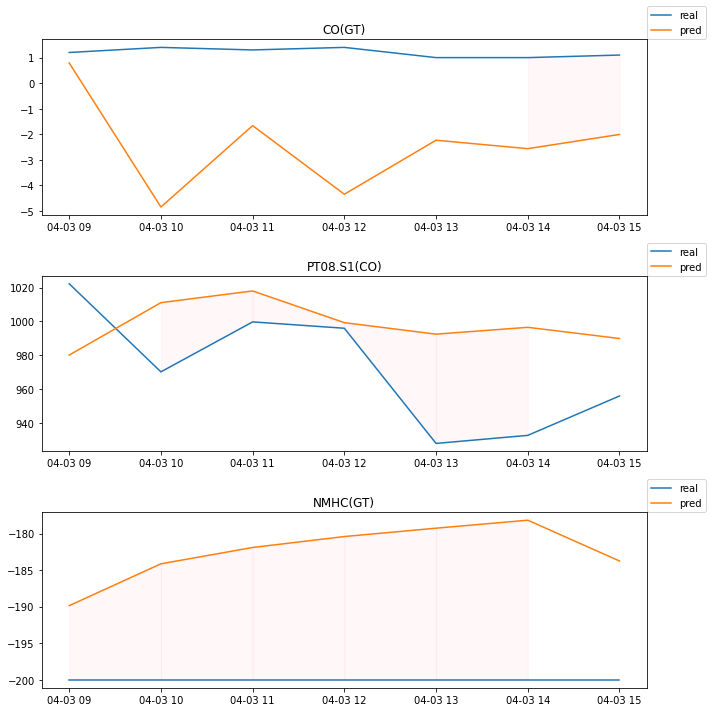

In [516]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

draw_subplot(axes, 0, 'CO(GT)')
draw_subplot(axes, 1, 'PT08.S1(CO)')
draw_subplot(axes, 2, 'NMHC(GT)')

plt.tight_layout()
plt.show()

### (4) Exponential Smoothing
- 직관적이어서 이해하기 쉽고 (ARIMA 대비 상대적으로), 또 시계열 자료의 구성요소가 변동이 느리거나 매우 규칙적(periodic)일 때 예측 정확도가 높음
- 최근 관측한 값에 높은 가중치를 주고, 먼 과거의 관측치에는 낮은 관측치를 주어 가중 평균값을 구함
    - 가중치는 현재로 부터 과거로 갈 수록 지수적으로 감소(exponential decay)시켜서 차등적으로 주는 평활 함수(smoothing function) 사용
    - 여러개의 관측치를 모아서 가중 평균을 사용하기 때문에 "평활(smoothing)"되는 효과가 있음

- 모델의 종류
    - 시계열 자료에 추세(Trend)가 있는지, 추세가 있다면 1차 선형인지 아니면 비선형 인가? 
        - 추세 없음 (No Trend)             --> Simple Exponential Smoothing
        - 1차 선형 추세 (Linear Trend)     --> Two Parameter Exponential Smoothing
        - 2차 비선형 추세 (Quadratic Trend) --> Three Parameter Smoothing
    - 시계열 자료에 계절성(Seasonality)이 있는가? 
        - 계절성 없음 (No Seasonality)
        - 계절성 있음 (with Seasonality)  --> Winters' Method
    - 시계열 자료의 계절성이 시간이 지남에 따라 고정(fixed)되어 있는지 아니면 확산(increasing)되는가? 
        - 고정(상수) 계절 변동 (fixed seasonal variation) --> Additive Model
        - 확산 계절 변동 (increasing seasonal variation) --> Multiplicative Model

In [517]:
data = pd.read_csv('./data/jj.csv')
train, test = data.iloc[:75,:], data.iloc[75:,:]

In [518]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [519]:
# Simple Exponential Smoothing
model_1 = SimpleExpSmoothing(train['data'], initialization_method="estimated").fit()
pred_1 = model_1.predict(start=test['data'].index[0], end=test['data'].index[-1])
model_1.summary() 

Dep. Variable:,data,No. Observations:,75
Model:,SimpleExpSmoothing,SSE,37.006
Optimized:,True,AIC,-48.980
Trend:,None,BIC,-44.345
Seasonal:,None,AICC,-48.409
Seasonal Periods:,None,Date:,"Sun, 29 Oct 2023"
Box-Cox:,False,Time:,23:09:04
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6392432,alpha,True
initial_level,0.6940527,l.0,True


In [520]:
# Trend
model_2 = Holt(train['data'], initialization_method="estimated").fit()
pred_2 = model_2.predict(start=test.index[0], end=test.index[-1])
model_2.summary() 

Dep. Variable:,data,No. Observations:,75
Model:,Holt,SSE,26.162
Optimized:,True,AIC,-70.990
Trend:,Additive,BIC,-61.720
Seasonal:,None,AICC,-69.755
Seasonal Periods:,None,Date:,"Sun, 29 Oct 2023"
Box-Cox:,False,Time:,23:09:05
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2673964,alpha,True
smoothing_trend,0.2673964,beta,True


In [521]:
# Multiplicative damped trend
model_3 = Holt(train['data'], exponential=True, damped_trend=True, initialization_method="estimated").fit()
pred_3 = model_3.predict(start=test.index[0], end=test.index[-1])
model_3.summary() 

Dep. Variable:,data,No. Observations:,75
Model:,Holt,SSE,20.811
Optimized:,True,AIC,-86.152
Trend:,Multiplicative,BIC,-74.565
Seasonal:,None,AICC,-84.480
Seasonal Periods:,None,Date:,"Sun, 29 Oct 2023"
Box-Cox:,False,Time:,23:09:05
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
smoothing_trend,3.545e-09,beta,True


In [522]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [523]:
# additive model for fixed seasonal variation
model_4 = ExponentialSmoothing(train['data'], seasonal_periods=4, trend='add', seasonal='add').fit()
pred_4 = model_4.predict(start=test.index[0], end=test.index[-1])
model_4.summary() 

Dep. Variable:,data,No. Observations:,75
Model:,ExponentialSmoothing,SSE,8.157
Optimized:,True,AIC,-150.396
Trend:,Additive,BIC,-131.857
Seasonal:,Additive,AICC,-146.959
Seasonal Periods:,4,Date:,"Sun, 29 Oct 2023"
Box-Cox:,False,Time:,23:09:05
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4209202,alpha,True
smoothing_trend,0.2303728,beta,True


In [524]:
# multiplicative model for increasing seasonal variation
# 시간이 흐름에 따라 분산이 점점 커지는 경우
model_5 = ExponentialSmoothing(train['data'], seasonal='mul', seasonal_periods=4).fit()
pred_5 = model_5.predict(start=test.index[0], end=test.index[-1])
model_5.summary() 

Dep. Variable:,data,No. Observations:,75
Model:,ExponentialSmoothing,SSE,12.588
Optimized:,True,AIC,-121.856
Trend:,None,BIC,-107.952
Seasonal:,Multiplicative,AICC,-119.675
Seasonal Periods:,4,Date:,"Sun, 29 Oct 2023"
Box-Cox:,False,Time:,23:09:05
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6440684,alpha,True
smoothing_seasonal,0.3559316,gamma,True


In [525]:
## forecasting for seasons
forecast_1 = model_1.forecast(9)
forecast_2 = model_2.forecast(9)
forecast_3 = model_3.forecast(9)
forecast_4 = model_4.forecast(9)
forecast_5 = model_5.forecast(9)

t_p = pd.DataFrame({'test': test['data'], 'f1': forecast_1, 'f2': forecast_2, 'f3': forecast_3, 'f4': forecast_4, 'f5': forecast_5})
t_p

,test,f1,f2,f3,f4,f5
75,8.91,11.961016,12.283881,17.011425,11.006146,10.062659
76,14.04,11.961016,12.819286,17.679422,13.917321,12.782084
77,12.96,11.961016,13.354690,18.369321,14.162288,12.782200
78,14.85,11.961016,13.890094,19.081673,13.675764,11.782636
79,9.99,11.961016,14.425499,19.817037,12.901613,10.062659
80,16.20,11.961016,14.960903,20.575981,15.812788,12.782084
81,14.67,11.961016,15.496308,21.359079,16.057755,12.782200
82,16.02,11.961016,16.031712,22.166916,15.571231,11.782636
83,11.61,11.961016,16.567117,23.000084,14.797080,10.062659


In [526]:
## evaluation metrics
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

## UDF for counting the number of parameters in model
def num_params(model):
    n_params = 0

    for p in list(model.params.values()):
        if isinstance(p, np.ndarray):
            n_params += len(p)
            #print(p)
        elif p in [np.nan, False, None]:
            pass
        elif np.isnan(float(p)):
            pass
        else:
            n_params += 1
            #print(p)
    
    return n_params

# Mean Absolute Percentage Error
def SSE(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.sum((y_test - y_pred)**2)

def ME(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(y_test - y_pred)

def RMSE(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.sqrt(np.mean((y_test - y_pred)**2))   
    #return np.sqrt(MSE(y_test - y_pred))

def MPE(y_test, y_pred): 
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean((y_test - y_pred) / y_test) * 100

def MAPE(y_test, y_pred): 
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

def AIC(y_test, y_pred, T, model):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    sse = np.sum((y_test - y_pred)**2)
    #T = len(y_train) # number of observations
    k = num_params(model) # number of parameters
    return T * np.log(sse/T) + 2*k

def SBC(y_test, y_pred, T, model):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    sse = np.sum((y_test - y_pred)**2)
    #T = len(y_train) # number of observations
    k = num_params(model) # number of parameters
    return T * np.log(sse/T) + k * np.log(T)

def APC(y_test, y_pred, T, model):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    sse = np.sum((y_test - y_pred)**2)
    #T = len(y_train) # number of observations
    k = num_params(model) # number of parameters
    return ((T+k)/(T-k)) * sse / T

def ADJ_R2(y_test, y_pred, T, model):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    sst = np.sum((y_test - np.mean(y_test))**2)
    sse = np.sum((y_test - y_pred)**2)
    #T = len(y_train) # number of observations
    k = num_params(model) # number of parameters
    r2 = 1 - sse/sst
    return 1 - ((T - 1)/(T - k)) * (1 - r2)
    

## Combining all metrics together
def eval_all(y_test, y_pred, T, model):
    sse = SSE(y_test, y_pred)
    mse = MSE(y_test, y_pred)
    rmse = RMSE(y_test, y_pred)
    me = ME(y_test, y_pred)
    mae = MAE(y_test, y_pred)
    mpe = MPE(y_test, y_pred)
    mape = MAPE(y_test, y_pred)
    aic = AIC(y_test, y_pred, T, model)
    sbc = SBC(y_test, y_pred, T, model)
    apc = APC(y_test, y_pred, T, model)
    adj_r2 = ADJ_R2(y_test, y_pred, T, model)
    
    return [sse, mse, rmse, me, mae, mpe, mape, aic, sbc, apc, adj_r2]

In [527]:
T = train.shape[0]

eval_all_df = pd.DataFrame(
    {'SES': eval_all(test['data'], forecast_1, T, model_1), 
    "Trend": eval_all(test['data'], forecast_2, T, model_2), 
    'Multiplicative T': eval_all(test['data'], forecast_3, T, model_3), 
    'Addictive S': eval_all(test['data'], forecast_4, T, model_4), 
    'Multiplicative S': eval_all(test['data'], forecast_5, T, model_5)}, 
    index=['SSE', 'MSE', 'RMSE', 'ME', 'MAE', 'MPE', 'MAPE', 'AIC', 'SBC', 'APC', 'Adj_R2']
)
eval_all_df

,SES,Trend,Multiplicative T,Addictive S,Multiplicative S
SSE,68.766127,60.415353,454.028518,28.145361,47.952044
MSE,7.640681,6.712817,50.447613,3.127262,5.328005
RMSE,2.764178,2.590910,7.102648,1.768407,2.308247
ME,1.288984,-1.175499,-6.645660,-0.961332,1.596465
MAE,2.482995,1.935436,6.645660,1.435309,1.868758
MPE,6.104896,-12.322940,-54.948402,-9.431815,10.118652
MAPE,18.770646,17.391230,54.948402,12.536836,13.155099
AIC,-2.508262,-8.218364,145.050392,-55.507916,-19.546502
SBC,2.126714,1.051588,156.637833,-34.650523,-3.324085
APC,0.967122,0.896303,6.918530,0.477618,0.770994


In [528]:
from matplotlib.ticker import MultipleLocator

No handles with labels found to put in legend.


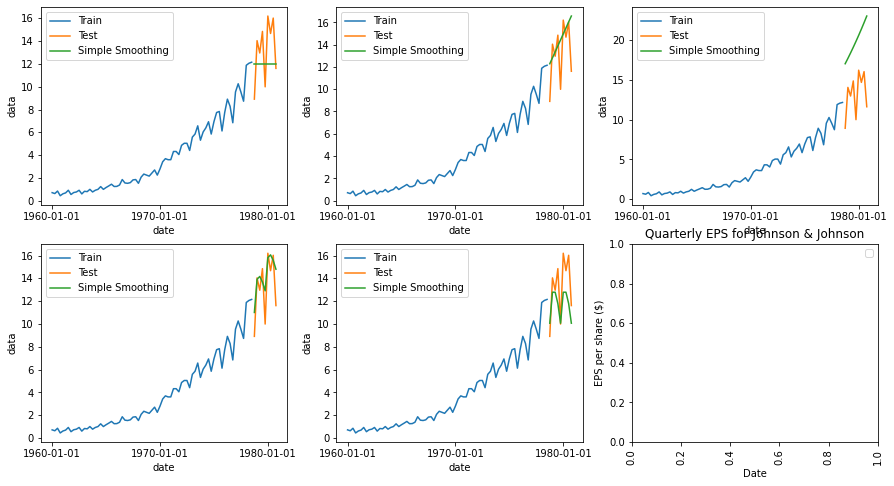

In [529]:
nrows = 2
ncols = 3
pred_idx = {1: pred_1, 2: pred_2, 3: pred_3, 4: pred_4, 5: pred_5}
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 8))
plt.title('Quarterly EPS for Johnson & Johnson')
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.legend()

for i in range(5):
    row = i // 3
    col = i % 3
    sns.lineplot(x=train['date'], y=train['data'], label='Train', ax=axes[row][col])
    sns.lineplot(x=test['date'], y=test['data'], label='Test', ax=axes[row][col])
    axes[row][col].xaxis.set_major_locator(MultipleLocator(40))
    sns.lineplot(x=pred_idx[i + 1].index, y=pred_idx[i + 1], label='Simple Smoothing', ax=axes[row][col])

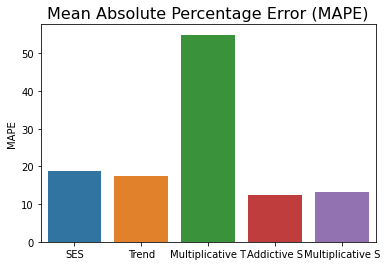

In [530]:
# horizontal bar chart
sns.barplot(x=eval_all_df.columns, y=eval_all_df.loc['MAPE', :])
plt.title('Mean Absolute Percentage Error (MAPE)', fontsize=16)
plt.show()